# 5.3-TCR reactivity selection

**Inés Sentís**

We are going to generate 3 dataframes that include the following TCRs:

- Crt1:Tumor expanded

- Crt2:Present in Tumor and expanded in blood: for this I would include everything shared

- Crt3:Top expanded clonotypes in T2 (that are not top ones in T1)

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-27"

## Libraries

In [2]:
options(warn = -1, verbose = FALSE)
suppressMessages(suppressWarnings({
library(Seurat)
library(scRepertoire)
library(here)
library(glue)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(stringr)
library(cowplot)
}))

## Parameters

In [3]:
#dr_here(show_reason = TRUE)
source(here("SCGRES_83_120/misc/paths.R"))
source(here("utils/bin.R"))
source(here("utils/style.R"))

set.seed(0)

In [4]:
# depending on clone call
mode = "nt" 
chain = "TRB"
col_name <- "cdr3"

### 1-Tumor expanded

In [5]:
source(here("SCGRES_83_120/misc/paths.R"))

tumor_obj <- readRDS(here(glue("{tcr}/{robj_dir}/5.0-tumorTCR_{mode}_{chain}.rds")))

In [6]:
cd8_clusters <- c("0","1","3","4","8","10")
cd4_clusters <- c("2","5","6","9_0", "9_1","11","13")
others <- c("7","12")

In [7]:
lvl = "Tcell_clusters"

In [8]:
df_summary <- tumor_obj@meta.data %>% 
    dplyr::filter(!is.na(cdr3)) %>%
    mutate_at(vars(!!lvl), funs(as.character(.))) %>%
    group_by(cdr3) %>%
    summarise(
        !!(lvl) := list(unique(!!sym(lvl))),
        sample_id = list(unique(sample_id)),
        Freq_Tumor = n()
  ) %>% arrange(desc(Freq_Tumor))

head(df_summary)

cdr3                                      
1 AGTGCGGGACTAGCGGGGCTGGGTCCGCGGGAGCAGTAC   
2 GCCAGCAGCGAGAACGGACAGGGATCCTACAATGAGCAGTTC
3 GCCAGCAGCGGGCAGAAAAACATTCAGTAC            
4 GCCAGCAGCTGGACAGCTCAAGCTTTC               
5 GCCAGCAGCGGGGGGACGGAGATGAACACTGAAGCTTTC   
6 GCCATCAGTGTTGTTCCCGGGTTCCCCTTCTACGAGCAGTAC
  Tcell_clusters                         sample_id              Freq_Tumor
1 8 , 0 , 3 , 10, 1                      T0_CD3pos , T0_CD45pos 177       
2 1, 0, 7, 3, 8, 4                       T0_CD3pos , T0_CD45pos 116       
3 10, 12, 0 , 8 , 1 , 3 , 4 , 7          T0_CD3pos , T0_CD45pos  90       
4 3 , 1 , 0 , 7 , 10, 8 , 4              T0_CD3pos , T0_CD45pos  88       
5 3 , 0 , 1 , 8 , 10                     T0_CD3pos , T0_CD45pos  84       
6 1 , 4 , 3 , 8 , 0 , 12, 10, 7 , 6 , 13 T0_CD3pos , T0_CD45pos  84

In [9]:
df_summary <- df_summary %>% 
    dplyr::filter(Freq_Tumor > 2) %>% 
    select(c(cdr3,Freq_Tumor ))
dim(df_summary)

[1] 823   2

Load info about which of those are found expanded in blood in OS-T data (deep TCR seq)

In [10]:
ost <- read.csv(here(glue("ext_data/counts_t_cells_in_blood_found_in_tumor_T1234567.csv")))

In [11]:
colnames(ost) <- c("cdr3", "counts_T1_OS", "counts_T2_3_OS", "counts_T4_OS", "counts_T5_OS","counts_T6_OS","counts_T7_OS")

In [12]:
head(ost)

cdr3                                    counts_T1_OS counts_T2_3_OS
1 GCCAGCAGCCAAGGGGGCAATCAGCCCCAGCAT       46           2             
2 GCCAGCAGCTTACAGAACACTGAAGCTTTC          41           7             
3 GCCAGCAGCTTACAGGGCAATCAGCCCCAGCAT       25           9             
4 GCCAGCAGACAGAACACTGAAGCTTTC             22           2             
5 GCCAGCAGCTTGTTGGGGGTCCCATCCTACGAGCAGTAC 21           0             
6 GCCAGTAGTATGGGCACTGAAGCTTTC             20           1             
  counts_T4_OS counts_T5_OS counts_T6_OS counts_T7_OS
1 0            1             0            0          
2 4            1            17            4          
3 3            3             4           17          
4 0            1             2            5          
5 1            0             0            0          
6 1            1             0            0

In [13]:
df_summary <- left_join(df_summary, ost,  by="cdr3")
df_summary %>% 
    dplyr::filter(!is.na(counts_T2_3_OS))

cdr3                                             Freq_Tumor counts_T1_OS
1   GCCAGCAGCCAACTAGCGGGCTCCTACAATGAGCAGTTC          56          0          
2   GCCAGCAGCGGATCGAACTCCTACGAGCAGTAC                54          1          
3   GCCAGCAGCTTAGACAACTATGGCTACACC                   44          2          
4   GCCAGCAGCCAAGGGGGCAATCAGCCCCAGCAT                22         46          
5   GCCAGCAGTGGGGGGGTGACAGGGTCGGGTCAGCCCCAGCAT       20          0          
6   GCCAGCAGTTTAGGTTACGAGCAGTAC                      20          0          
7   GCCAGCTCAATTGGGGCCAACGTCCTGACT                   20          0          
8   GCCAGCAGCTTCGGGACCCCCTACGAGCAGTAC                18          0          
9   AGTGCTAGTCCCCGGGGCCAGAACACTGAAGCTTTC             16          1          
10  GCCAGCACACTGATGCAGGGATACACCGGGGAGCTGTTT          15          1          
11  GCCAGCAGCGGACTAGCGGGAGGGCCCTACAATGAGCAGTTC       15          1          
12  GCCAGCGGTCAGGGAAGGGCCACAGATACGCAGTAT             14         10          
13  GCCAGCAGCTCGGGACTAGTAGAGTACAATGAGCAGTTC          13          2          
14  GCCAGCAGCTTAGCCAGAGGCACAGATACGCAGTAT             13          0          
15  GCCAGCAGCTTGCACAGGGACACAGATACGCAGTAT             13          1          
16  GCCAGCAGTTTCGGGGGCTATGGCTACACC                   13          1          
17  GCCACCAGTGATTCACGGACAGGGGGACGCAATCAGCCCCAGCAT    12          3          
18  GCCAGCAGTTTCGGGGGGGACGGGGGGACCCAGTAC             12          0          
19  GCCAGCAGTTTTAGCAATCAGCCCCAGCAT                   12          0          
20  GCCAGCAGCCCTCTTACAGGGGGCTATGGCTACACC             11          3          
21  GCCAGCAGCTTAGACAGGGCCACCAATCAGCCCCAGCAT          11          3          
22  GCCAGCAGCTTAGAGATGAACACTGAAGCTTTC                11          4          
23  GCCAGCAGCTTGGCGGGGGGCTCCTACAATGAGCAGTTC          11          0          
24  GCCAGCAGTTACGGGGAAAAACTGTTT                      11          0          
25  GCCAGCAGCCGGGACAACTACGAGCAGTAC                   10          0          
26  GCCAGCAGCCGTCAGGGGATCGTGCAGTAT                   10          1          
27  GCCAGCAGCGTGGGGAGACGTCTGGAGACCCAGTAC             10          1          
28  GCCAGCAGTTTAAGGTCTCCAGGGAGATCGTCGGGAAACACCATATAT 10          4          
29  GCCAGCAATGAGCAGTTC                                9          1          
30  GCCAGCAGCGAGGGCCCTAGCGGGAGCTCCTACAATGAGCAGTTC     9          0          
⋮   ⋮                                                ⋮          ⋮           
121 GCCAGCAGCTTAACCCGGGACACAGATACGCAGTAT             3          0           
122 GCCAGCAGCTTAATATGGGCCAACGTCCTGACT                3          4           
123 GCCAGCAGCTTACGGGGTGGTGAAAAACTGTTT                3          2           
124 GCCAGCAGCTTACTAGCGTACGAGCAGTAC                   3          0           
125 GCCAGCAGCTTAGAGGGGACAGGGTTGAACATTCAGTAC          3          1           
126 GCCAGCAGCTTAGGGGAAAATGAGCAGTTC                   3          0           
127 GCCAGCAGCTTATGGGGGACTAACTATGGCTACACC             3          8           
128 GCCAGCAGCTTCAGCTCCTATAATTCACCCCTCCAC             3          0           
129 GCCAGCAGCTTCTCCATACTAGCGGGGGGATCCTACAATGAGCAGTTC 3          1           
130 GCCAGCAGCTTGGAGGGGTACTATGGCTACACC                3          0           
131 GCCAGCAGCTTGGGAACTCCATCGGGTGAAAAACTGTTT          3          0           
132 GCCAGCAGCTTGGGACTAGCGGGGGTCACAGATACGCAGTAT       3          1           
133 GCCAGCAGCTTGGTCACCAGCGGGATAAACAATGAGCAGTTC       3          3           
134 GCCAGCAGCTTTAGGGGGACTAGCGGGAATCAAGAGACCCAGTAC    3          0           
135 GCCAGCAGTCGCTCCGGGACTACCTACAATGAGCAGTTC          3          9           
136 GCCAGCAGTGAAGGCAGGGGGATTGAGCCCCAGCAT             3          2           
137 GCCAGCAGTGAAGGGGGAGGTACTAATGAAAAACTGTTT          3          0           
138 GCCAGCAGTGACTCGCAGGGGAAAGCTTTC                   3          0           
139 GCCAGCAGTGAGGGGACCTGGACAGATACGCAGTAT             3          0           
140 GCCAGCAGTGAGGGTTACGAGCAGTAC                      3          2           


In [14]:
df_summary %>% 
    arrange(desc(Freq_Tumor)) %>%
head(n=20)

cdr3                                                   Freq_Tumor
1  AGTGCGGGACTAGCGGGGCTGGGTCCGCGGGAGCAGTAC                177       
2  GCCAGCAGCGAGAACGGACAGGGATCCTACAATGAGCAGTTC             116       
3  GCCAGCAGCGGGCAGAAAAACATTCAGTAC                          90       
4  GCCAGCAGCTGGACAGCTCAAGCTTTC                             88       
5  GCCAGCAGCGGGGGGACGGAGATGAACACTGAAGCTTTC                 84       
6  GCCATCAGTGTTGTTCCCGGGTTCCCCTTCTACGAGCAGTAC              84       
7  GCCAGCAGCCAAGACCCGGGACTAGAGTACTACAATGAGCAGTTC           67       
8  GCCAGCAGTGAAGCTGGGGAAATATGGTATTCACCCCTCCAC              67       
9  GCCAGTAGTACAGGGGTGAACACTGAAGCTTTC                       61       
10 GCTAGTGGTTTTACTAGCAATGAGCAGTTC                          59       
11 GCCAGCAGCCAACTAGCGGGCTCCTACAATGAGCAGTTC                 56       
12 GCCAGCAGCTTAATGGGAACAGGGATGGATGGCTACACC                 55       
13 GCCAGCAGCGGATCGAACTCCTACGAGCAGTAC                       54       
14 GCCAGCAGCGTAGCTAGCGGGGGGCTCCTTGGAGTCGGGGCCAACGTCCTGACT  53       
15 GCCAGCAGTTTATGGGCGGGGGGCTCTGAAGCTTTC                    52       
16 GCCAGCAGCCTAACCGGGGGAAGCACAGATACGCAGTAT                 47       
17 GCCAGCAGCTTAGACAACTATGGCTACACC                          44       
18 GCCAGCAGTTTGGGACGGAACTATGGCTACACC                       43       
19 AGTGCTAGAGATCGACACTCCTACGAGCAGTAC                       39       
20 GCCAGCAGCTTAGAACTAACTTGGGGCTCCTACAATGAGCAGTTC           38       
   counts_T1_OS counts_T2_3_OS counts_T4_OS counts_T5_OS counts_T6_OS
1  NA           NA             NA           NA           NA          
2  NA           NA             NA           NA           NA          
3  NA           NA             NA           NA           NA          
4  NA           NA             NA           NA           NA          
5  NA           NA             NA           NA           NA          
6  NA           NA             NA           NA           NA          
7  NA           NA             NA           NA           NA          
8  NA           NA             NA           NA           NA          
9  NA           NA             NA           NA           NA          
10 NA           NA             NA           NA           NA          
11  0            2              0            0            0          
12 NA           NA             NA           NA           NA          
13  1            0              0            0            0          
14 NA           NA             NA           NA           NA          
15 NA           NA             NA           NA           NA          
16 NA           NA             NA           NA           NA          
17  2            5             18           15           20          
18 NA           NA             NA           NA           NA          
19 NA           NA             NA           NA           NA          
20 NA           NA             NA           NA           NA          
   counts_T7_OS
1  NA          
2  NA          
3  NA          
4  NA          
5  NA          
6  NA          
7  NA          
8  NA          
9  NA          
10 NA          
11  0          
12 NA          
13  0          
14 NA          
15 NA          
16 NA          
17  1          
18 NA          
19 NA          
20 NA

In [15]:
write_csv(df_summary, here(glue("{tcr}/{robj_dir}/5.3-Crt1_exp_T0.csv")),na = "")

In [16]:
n=11 # number of top ones
color_tops <- c('#e31a1c','#fb9a99','#a6cee3','#1f78b4','#b2df8a','#33a02c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a')
names(color_tops) = paste("top", seq(1:10), sep='')
color_tops["top17"] <- '#ffff99'

In [17]:
tumor_obj@meta.data$top_clonotypes_T0 = NA
for (i in seq(1:n)) {
    if (i < 11) {
        top <- df_summary[i,][[col_name]]
        tumor_obj@meta.data <- tumor_obj@meta.data %>%
            mutate(top_clonotypes_T0 = case_when(!!as.name(col_name) == top ~ paste("top", i, sep=''),
                                              TRUE ~ top_clonotypes_T0))    
    } else {
        top = "GCCAGCAGCTTAGACAACTATGGCTACACC" # manually selected/interesting case
        tumor_obj@meta.data <- tumor_obj@meta.data %>%
            mutate(top_clonotypes_T0 = case_when(!!as.name(col_name) == top ~ paste("top","17", sep=''),
                                              TRUE ~ top_clonotypes_T0))  
    }
}

In [18]:
df_plot <- tumor_obj@meta.data %>% 
    dplyr::filter(!is.na(!!as.name(col_name))) %>%
    dplyr::filter(!is.na(top_clonotypes_T0)) %>%
    group_by(top_clonotypes_T0, !!as.name(col_name),!!as.name(lvl)) %>%
    summarise(
        sample_id = list(unique(sample_id)),
        count = n()
  ) %>% arrange(desc(count)) %>%
    arrange(as.numeric(gsub(".*?(\\d+)$", "\\1", top_clonotypes_T0))) 
head(df_plot)

`summarise()` has grouped output by 'top_clonotypes_T0', 'cdr3'. You can override using the `.groups` argument.


top_clonotypes_T0 cdr3                                       Tcell_clusters
1 top1              AGTGCGGGACTAGCGGGGCTGGGTCCGCGGGAGCAGTAC    0             
2 top1              AGTGCGGGACTAGCGGGGCTGGGTCCGCGGGAGCAGTAC    3             
3 top1              AGTGCGGGACTAGCGGGGCTGGGTCCGCGGGAGCAGTAC    1             
4 top1              AGTGCGGGACTAGCGGGGCTGGGTCCGCGGGAGCAGTAC    8             
5 top1              AGTGCGGGACTAGCGGGGCTGGGTCCGCGGGAGCAGTAC    10            
6 top2              GCCAGCAGCGAGAACGGACAGGGATCCTACAATGAGCAGTTC 0             
  sample_id              count
1 T0_CD3pos , T0_CD45pos 84   
2 T0_CD3pos , T0_CD45pos 30   
3 T0_CD3pos , T0_CD45pos 27   
4 T0_CD3pos , T0_CD45pos 23   
5 T0_CD3pos , T0_CD45pos 13   
6 T0_CD3pos , T0_CD45pos 52

In [19]:
names(color_tops) <- unique(paste(df_plot$top_clonotypes_T0, df_plot[[col_name]], sep='_'))

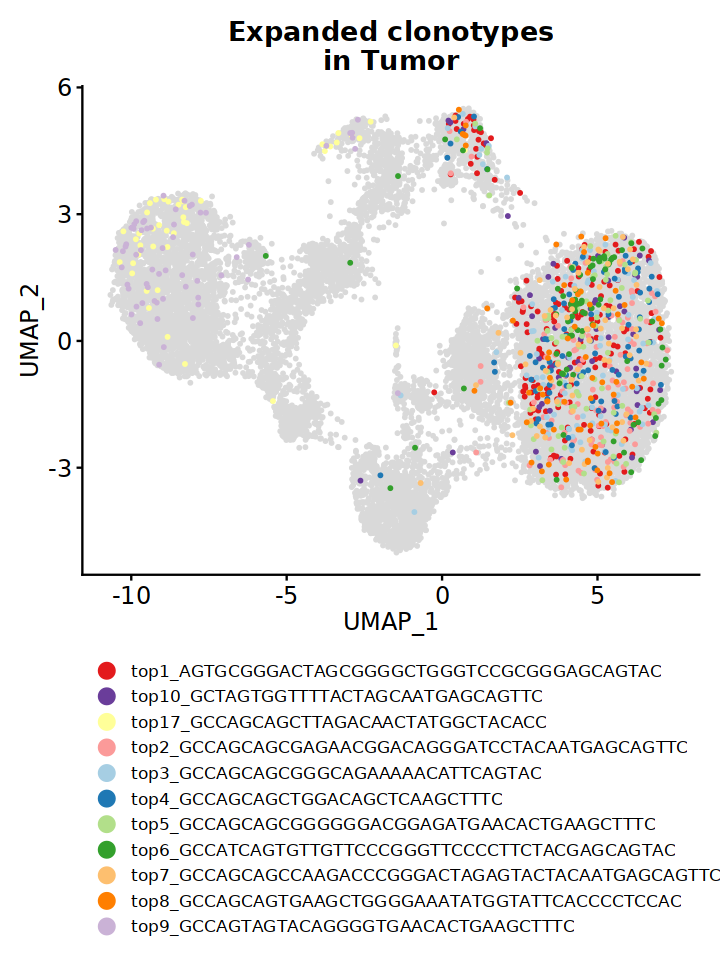

In [20]:
options(repr.plot.width = 6, repr.plot.height = 8, warn=-1,verbose = FALSE)

tumor_obj <- highlightClonotypes(tumor_obj, 
              cloneCall=col_name, 
              sequence = unique(df_plot[[col_name]]))
tumor_obj$highlight <- factor(tumor_obj$highlight, levels = unique(df_plot[[col_name]]))
tumor_obj$highlight <- paste(tumor_obj$top_clonotypes_T0, tumor_obj$highlight, sep='_')

plt <- DimPlot(tumor_obj, group.by = "highlight", 
        cols=color_tops, na.value="#d9d9d9",
        pt.size = 0.6, order=T)  + 
  theme(legend.position = "bottom",
       legend.box="vertical", legend.margin=margin(),
       axis.text.x = element_text(size = 14),
              axis.text.y = element_text(size = 14),
              text = element_text(size = 14),
              legend.text = element_text(size = 10)) + 
       guides(color = guide_legend(nrow = 11, ncol=1,
                                  override.aes = list(size = 4))) + 
       labs(title=glue("Expanded clonotypes\nin Tumor")) 

plt

In [21]:
ggsave(plot = plt, width = 6, height = 8, dpi = 300, 
       file = here::here(glue::glue("{tcr}/{plt_dir}/5.3-tumorUMAP_top_expanded_Tumor.png")))

In [22]:
df_plot <- tumor_obj@meta.data %>% 
    dplyr::filter(!is.na(!!as.name(col_name))) %>%
    dplyr::filter(!is.na(top_clonotypes_T0)) %>%
    group_by(top_clonotypes_T0, !!as.name(col_name),!!as.name(lvl)) %>%
    summarise(
        sample_id = list(unique(sample_id)),
        count = n()
  ) %>% arrange(desc(count)) %>%
    arrange(as.numeric(gsub(".*?(\\d+)$", "\\1", top_clonotypes_T0))) 
df_plot

`summarise()` has grouped output by 'top_clonotypes_T0', 'cdr3'. You can override using the `.groups` argument.


top_clonotypes_T0 cdr3                                         
1  top1              AGTGCGGGACTAGCGGGGCTGGGTCCGCGGGAGCAGTAC      
2  top1              AGTGCGGGACTAGCGGGGCTGGGTCCGCGGGAGCAGTAC      
3  top1              AGTGCGGGACTAGCGGGGCTGGGTCCGCGGGAGCAGTAC      
4  top1              AGTGCGGGACTAGCGGGGCTGGGTCCGCGGGAGCAGTAC      
5  top1              AGTGCGGGACTAGCGGGGCTGGGTCCGCGGGAGCAGTAC      
6  top2              GCCAGCAGCGAGAACGGACAGGGATCCTACAATGAGCAGTTC   
7  top2              GCCAGCAGCGAGAACGGACAGGGATCCTACAATGAGCAGTTC   
8  top2              GCCAGCAGCGAGAACGGACAGGGATCCTACAATGAGCAGTTC   
9  top2              GCCAGCAGCGAGAACGGACAGGGATCCTACAATGAGCAGTTC   
10 top2              GCCAGCAGCGAGAACGGACAGGGATCCTACAATGAGCAGTTC   
11 top2              GCCAGCAGCGAGAACGGACAGGGATCCTACAATGAGCAGTTC   
12 top3              GCCAGCAGCGGGCAGAAAAACATTCAGTAC               
13 top3              GCCAGCAGCGGGCAGAAAAACATTCAGTAC               
14 top3              GCCAGCAGCGGGCAGAAAAACATTCAGTAC               
15 top3              GCCAGCAGCGGGCAGAAAAACATTCAGTAC               
16 top3              GCCAGCAGCGGGCAGAAAAACATTCAGTAC               
17 top3              GCCAGCAGCGGGCAGAAAAACATTCAGTAC               
18 top3              GCCAGCAGCGGGCAGAAAAACATTCAGTAC               
19 top3              GCCAGCAGCGGGCAGAAAAACATTCAGTAC               
20 top4              GCCAGCAGCTGGACAGCTCAAGCTTTC                  
21 top4              GCCAGCAGCTGGACAGCTCAAGCTTTC                  
22 top4              GCCAGCAGCTGGACAGCTCAAGCTTTC                  
23 top4              GCCAGCAGCTGGACAGCTCAAGCTTTC                  
24 top4              GCCAGCAGCTGGACAGCTCAAGCTTTC                  
25 top4              GCCAGCAGCTGGACAGCTCAAGCTTTC                  
26 top4              GCCAGCAGCTGGACAGCTCAAGCTTTC                  
27 top5              GCCAGCAGCGGGGGGACGGAGATGAACACTGAAGCTTTC      
28 top5              GCCAGCAGCGGGGGGACGGAGATGAACACTGAAGCTTTC      
29 top5              GCCAGCAGCGGGGGGACGGAGATGAACACTGAAGCTTTC      
30 top5              GCCAGCAGCGGGGGGACGGAGATGAACACTGAAGCTTTC      
⋮  ⋮                 ⋮                                            
44 top7              GCCAGCAGCCAAGACCCGGGACTAGAGTACTACAATGAGCAGTTC
45 top7              GCCAGCAGCCAAGACCCGGGACTAGAGTACTACAATGAGCAGTTC
46 top7              GCCAGCAGCCAAGACCCGGGACTAGAGTACTACAATGAGCAGTTC
47 top7              GCCAGCAGCCAAGACCCGGGACTAGAGTACTACAATGAGCAGTTC
48 top7              GCCAGCAGCCAAGACCCGGGACTAGAGTACTACAATGAGCAGTTC
49 top8              GCCAGCAGTGAAGCTGGGGAAATATGGTATTCACCCCTCCAC   
50 top8              GCCAGCAGTGAAGCTGGGGAAATATGGTATTCACCCCTCCAC   
51 top8              GCCAGCAGTGAAGCTGGGGAAATATGGTATTCACCCCTCCAC   
52 top8              GCCAGCAGTGAAGCTGGGGAAATATGGTATTCACCCCTCCAC   
53 top8              GCCAGCAGTGAAGCTGGGGAAATATGGTATTCACCCCTCCAC   
54 top8              GCCAGCAGTGAAGCTGGGGAAATATGGTATTCACCCCTCCAC   
55 top9              GCCAGTAGTACAGGGGTGAACACTGAAGCTTTC            
56 top9              GCCAGTAGTACAGGGGTGAACACTGAAGCTTTC            
57 top9              GCCAGTAGTACAGGGGTGAACACTGAAGCTTTC            
58 top9              GCCAGTAGTACAGGGGTGAACACTGAAGCTTTC            
59 top9              GCCAGTAGTACAGGGGTGAACACTGAAGCTTTC            
60 top9              GCCAGTAGTACAGGGGTGAACACTGAAGCTTTC            
61 top10             GCTAGTGGTTTTACTAGCAATGAGCAGTTC               
62 top10             GCTAGTGGTTTTACTAGCAATGAGCAGTTC               
63 top10             GCTAGTGGTTTTACTAGCAATGAGCAGTTC               
64 top10             GCTAGTGGTTTTACTAGCAATGAGCAGTTC               
65 top10             GCTAGTGGTTTTACTAGCAATGAGCAGTTC               
66 top10             GCTAGTGGTTTTACTAGCAATGAGCAGTTC               
67 top17             GCCAGCAGCTTAGACAACTATGGCTACACC               
68 top17             GCCAGCAGCTTAGACAACTATGGCTACACC               
69 top17             GCCAGCAGCTTAGACAACTATGGCTACACC               
70 top17             GCCAGCAGCTTAGACAACTATGGCTACACC               
71 top17             GCCAGCAGCTTAGACAACTATGGCTACAC

In [23]:
df_plot$top_clonotypes_T0 <- factor(df_plot$top_clonotypes_T0, levels = unique(df_plot$top_clonotypes_T0))

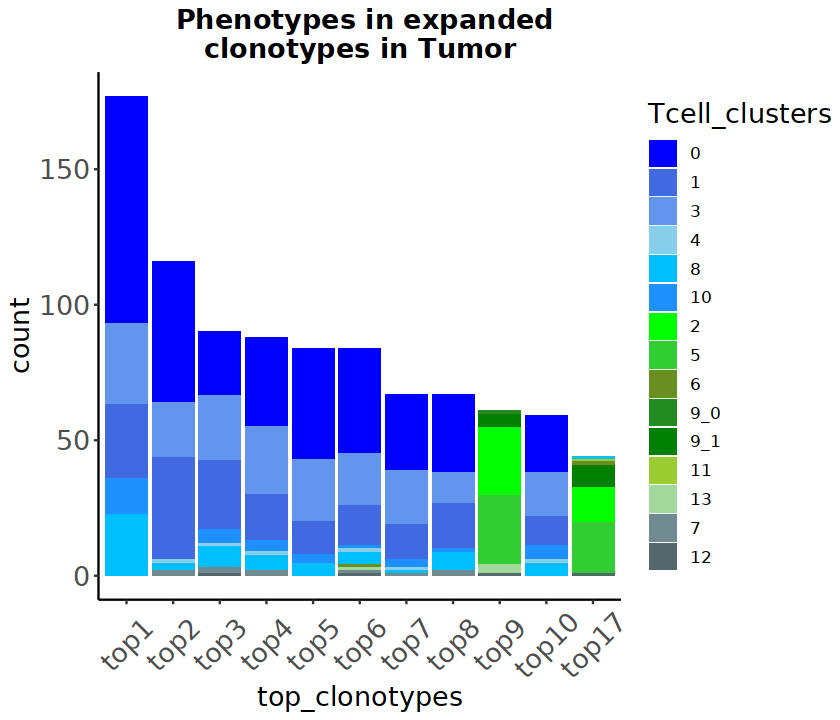

In [24]:
options(repr.plot.width = 7, repr.plot.height = 6, warn=-1,verbose = FALSE)
# Create a stacked bar plot
plt_top11 <- ggplot(df_plot, aes_string(x = "top_clonotypes_T0", y = "count", fill = lvl)) +
  geom_bar(stat = "identity") +

  labs(title = " Phenotypes in expanded\nclonotypes in Tumor",
       x = "top_clonotypes",
       y = "count") +
       scale_fill_manual(breaks = names(tumor_pal),
                             values = unname(tumor_pal)) + 
  theme_classic() + 
  theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
        axis.text.x = element_text(size = 16,angle = 45, vjust = 0.5, hjust=0.5),  
        axis.text.y = element_text(size = 16),
        text = element_text(size = 16),
        legend.text = element_text(size = 10))
plt_top11

In [25]:
ggsave(plot = plt_top11, width = 7, height = 6, dpi = 300, 
       file = here::here(glue::glue("{tcr}/{plt_dir}/5.3-barplot_top_tumor.svg")))

### 2-Present in Tumor, expanded in Blood

In [26]:
source(here("SCGRES_83_120/misc/paths.R"))
pbmc_obj <- readRDS(here(glue("{tcr}/{robj_dir}/5.0-pbmcTCR_{mode}_{chain}.rds")))

In [27]:
tumor_freq <- tumor_obj@meta.data %>% 
    dplyr::filter(!is.na(cdr3)) %>%
    group_by(cdr3) %>%
    summarise(
        sample_id = list(unique(sample_id)),
        Freq_Tumor = n()
  ) %>% arrange(desc(Freq_Tumor))
head(tumor_freq)

cdr3                                       sample_id              Freq_Tumor
1 AGTGCGGGACTAGCGGGGCTGGGTCCGCGGGAGCAGTAC    T0_CD3pos , T0_CD45pos 177       
2 GCCAGCAGCGAGAACGGACAGGGATCCTACAATGAGCAGTTC T0_CD3pos , T0_CD45pos 116       
3 GCCAGCAGCGGGCAGAAAAACATTCAGTAC             T0_CD3pos , T0_CD45pos  90       
4 GCCAGCAGCTGGACAGCTCAAGCTTTC                T0_CD3pos , T0_CD45pos  88       
5 GCCAGCAGCGGGGGGACGGAGATGAACACTGAAGCTTTC    T0_CD3pos , T0_CD45pos  84       
6 GCCATCAGTGTTGTTCCCGGGTTCCCCTTCTACGAGCAGTAC T0_CD3pos , T0_CD45pos  84

In [28]:
pbmc_freq <- pbmc_obj@meta.data %>% 
    dplyr::filter(!is.na(cdr3)) %>%
    group_by(cdr3) %>%
    summarize(
        timepoint = list(unique(timepoint)),
        Freq_Blood = n()
  ) %>% arrange(desc(Freq_Blood))
head(pbmc_freq)

cdr3                                    timepoint              Freq_Blood
1 GCCACCAGTGAGGCAGGGAATGTGCAGTAC          T2, T3, T4, T5, T6, T7 215       
2 GCCAGCAGTTTAGGTCAGTTCTACCAAGAGACCCAGTAC T7                     127       
3 GCCAGCAGTACGGGGACCAATCAGCCCCAGCAT       T7                     100       
4 GCCAGCAGCTTAGGAAGGGACTATTACGATGAGCAGTTC T7                      94       
5 AGTGCTAGCCTCTATGGCTACACC                T7                      70       
6 GCCAGCATTTGCGAGCAGTAC                   T7                      54

In [29]:
colnames(pbmc_freq) <- c("cdr3",'Samples','Freq')
colnames(tumor_freq) <- c("cdr3",'Samples','Freq')

In [30]:
pbmc_freq$Sample <- "Blood"
tumor_freq$Sample <- "Tumor"

In [31]:
df_all <- rbind(pbmc_freq, tumor_freq)

In [32]:
df_summary <- df_all %>% 
     select(c("cdr3",  "Sample", "Freq")) %>%
     pivot_wider(id_cols=c(cdr3), names_from = Sample, 
                values_from = Freq, values_fill = 0)
colnames(df_summary) <-  c("cdr3", "Freq_Blood", "Freq_Tumor")

In [33]:
df_summary <- df_summary %>% 
    dplyr::filter(Freq_Blood>0 & Freq_Tumor>0) 
df_summary

cdr3                                                Freq_Blood Freq_Tumor
1  AGCGTGAAAGGACTAGTTATGACCGAGGGGGAGACCCAGTAC          4           1        
2  GCCAGCAGCCCATCCCGGGACAGGTTCGATGGCTACACC             4           2        
3  GCCAGCAGCCAATCTAGGGCGGGAGACAATGAGCAGTTC             3           6        
4  GCCAGCAGTTTAGGGTACGAGCAGTAC                         3           3        
5  GCCAGCTCACCGACAGGGGGCACAGATACGCAGTAT                3           1        
6  GCCAGCAGCTTAGGAGGGGGACTAGCGGGACTGAGCACAGATACGCAGTAT 2           1        
7  GCCATCAGTGAGTCTCGTCTGTTCACTGAAGCTTTC                2           3        
8  GCCAGCAGCCAAGACAGGAACACTGAAGCTTTC                   1           1        
9  GCCAGCAGCCAAGACAGGGTGAACACTGAAGCTTTC                1           1        
10 GCCAGCAGCCAAGATAGCGGGGGGGCCTACGAGCAGTAC             1           1        
11 GCCAGCAGCCAAGATCGCGCCGGGACTAGCAATGAGCAGTTC          1           2        
12 GCCAGCAGCCAAGCGGGACCCAGCACAGATACGCAGTAT             1           1        
13 GCCAGCAGCCAATCCTACGAGCAGTAC                         1           1        
14 GCCAGCAGCCCTAGGACTAGTCGTCGCAGCACAGATACGCAGTAT       1           2        
15 GCCAGCAGCCCTCTTACAGGGGGCTATGGCTACACC                1          11        
16 GCCAGCAGCCGGGACAACTATGGCTACACC                      1           4        
17 GCCAGCAGCCTTACATATGAGGGGGCTGAAGCTTTC                1           1        
18 GCCAGCAGCGAAACTCATTGGAACACTGAAGCTTTC                1           3        
19 GCCAGCAGCGAAAGGACAGGGCTTAGCAATCAGCCCCAGCAT          1           2        
20 GCCAGCAGCGCCGGGGCTAGCGGGGCGTACCAAGAGACCCAGTAC       1           1        
21 GCCAGCAGCGTAGGGGCCGGGGAGCTGTTT                      1           1        
22 GCCAGCAGCTCCCCGGACAGGAGAGATCAGCCCCAGCAT             1           1        
23 GCCAGCAGCTTAAACAGGGACATCGCAGATACGCAGTAT             1           1        
24 GCCAGCAGCTTAAGGGGCACCGGGGAGCTGTTT                   1           1        
25 GCCAGCAGCTTACGGCCGGTTCCCGACAATGAGCAGTTC             1           1        
26 GCCAGCAGCTTAGACACCTACGAGCAGTAC                      1           2        
27 GCCAGCAGCTTAGGAGGGGATGGCGAGACCCAGTAC                1           9        
28 GCCAGCAGCTTAGGGAACACTGAAGCTTTC                      1           1        
29 GCCAGCAGCTTAGGTGGGGCGGGCAATGAGCAGTTC                1           2        
30 GCCAGCAGCTTCACAGATACGCAGTAT                         1           1        
31 GCCAGCAGCTTGCCGGCCGATACGCAGTAT                      1           1        
32 GCCAGCAGCTTGCGGACTAGCGGGGGTTCCACAGATACGCAGTAT       1           2        
33 GCCAGCAGCTTGGGGGGAGATACGCAGTAT                      1           1        
34 GCCAGCAGCTTGGGGTACGAGCAGTAC                         1           6        
35 GCCAGCAGCTTGGTCACCAGCGGGATAAACAATGAGCAGTTC          1           3        
36 GCCAGCAGGACAGGGGGCACTGAAGCTTTC                      1           1        
37 GCCAGCAGTCCGGGACTAGTTTACAATGAGCAGTTC                1           1        
38 GCCAGCAGTGACAGGGGGTATGGCTACACC                      1           1        
39 GCCAGCAGTGTCAGTCTTCTCTCCTATAATTCACCCCTCCAC          1           1        
40 GCCAGCAGTTACACCTACAATGAGCAGTTC                      1           1        
41 GCCAGCAGTTACTACAATGAGCAGTTC                         1           8        
42 GCCAGCAGTTACTCCGGGGAGCTGTTT                         1           1        
43 GCCAGCAGTTTACAGGGCAATCAGCCCCAGCAT                   1           1        
44 GCCAGCAGTTTGGGACAGAACACTGAAGCTTTC                   1           3        
45 GCCAGCGGGTTCCCACTGGGAGGCCAAGAGACCCAGTAC             1           1        
46 GCCAGTAGTACAGGGAACACTGAAGCTTTC                      1           1        
47 GCCAGTAGTATAGGGACTAGCTCCTACAATGAGCAGTTC             1           7        
48 GCCAGTAGTATGGGGGCCGGGGAGCTGTTT                      1           1        
49 GCCATCTCTCTCATGCACAGCAATACCTATGGCTACACC             1           6

In [34]:
write_csv(df_summary, here(glue("{tcr}/{robj_dir}/5.3-Crt2_shared.csv")))

### 3-Top expanded ones in T2

In [35]:
df_summary <- pbmc_obj@meta.data %>%
  dplyr::filter(!is.na(cdr3)) %>%
  group_by(cdr3) %>%
  summarise(
    timepoints = list(unique(timepoint)),
    count = n()
  ) %>%
  filter(count > 1) %>%
  arrange(desc(count)) 
df_summary

cdr3                                             timepoints            
1    GCCACCAGTGAGGCAGGGAATGTGCAGTAC                   T2, T3, T4, T5, T6, T7
2    GCCAGCAGTTTAGGTCAGTTCTACCAAGAGACCCAGTAC          T7                    
3    GCCAGCAGTACGGGGACCAATCAGCCCCAGCAT                T7                    
4    GCCAGCAGCTTAGGAAGGGACTATTACGATGAGCAGTTC          T7                    
5    AGTGCTAGCCTCTATGGCTACACC                         T7                    
6    GCCAGCATTTGCGAGCAGTAC                            T7                    
7    GCCAGCATACGGGGACCAACGAACACCGGGGAGCTGTTT          T7                    
8    GCCAGCAGCCCACGGCCGTCCGGGACAGGGAGCTCCTACGAGCAGTAC T7                    
9    GCCAGCAGTTTCGGGGCTTCAGACACTGAAGCTTTC             T2, T3                
10   AGTGCTAGAGCTTATCGGACAGGGGGCAATGAGCAGTTC          T2, T3                
11   GCCAGCAGCCAAGACATAGGGTCATACGGAGCTTTC             T7                    
12   GCCAGCAGCCCCAGAGCCGGCGGGAACGCGAACACCGGGGAGCTGTTT T7                    
13   GCCAGCAGCGGGACAGGGGGAAACTACGAGCAGTAC             T7                    
14   GCCAGCAGCATTCGACAGCCCGGAAACACCATATAT             T7                    
15   GCCAGCAGCTTGAAACAGGCCCATAATTCACCCCTCCAC          T2, T3, T4, T5, T6, T7
16   GCCAGCAGCCAAGAAATGGGGGGGGCAGGGGCCAACGTCCTGACT    T5, T6                
17   GCCAGCAGTTTAGGGGCTAGCACAGATACGCAGTAT             T2, T5                
18   GCCAGCAGCCCCCGGGGGGGAGTCCGGTACGAGCAGTAC          T7                    
19   GCCAGTAGTATTAATCCTAGAGCAGGTGAGCAGTTC             T7                    
20   GCCAGCAGTCTAGGGGCTAGCACAGATACGCAGTAT             T2                    
21   GCCAGCTCACAGGGGCCCTCCTACGAGCAGTAC                T3, T6, T7            
22   GCTAGTGGTTTGGGGAATGAGCAGTTC                      T2                    
23   GCCAGCAGAGAAGGACTTAGCAATCAGCCCCAGCAT             T7                    
24   GCCAGCAGCCAAGTCTTGTGGGGCTACGAGCAGTAC             T7                    
25   GCCAGCTCACCACGGTGGGGCCAGGGATCAGATACGCAGTAT       T7                    
26   AGTGCTAGACAAGACCCACTAGCGGGGGACACAGCAGATACGCAGTAT T3, T6                
27   GCCAGCAGCTATAAACAGGGAGGTGAGCAGTTC                T2, T4, T5, T6        
28   GCCAGCAGTTTAGGAAGGGCCTCCTACGAGCAGTAC             T7                    
29   GCCAGCAGTTTCGCGCAGGTTTATAACTATGGCTACACC          T7                    
30   GCCAGCAGTTTGGGGGCGGGAGGGAAGACAGATACGCAGTAT       T7                    
⋮    ⋮                                                ⋮                     
992  GCCAGTCTCCGGCTGGGGGACAATCAGCCCCAGCAT             T7                    
993  GCCAGTGGTGAACAGGGACTGAATCAGCCCCAGCAT             T2                    
994  GCCATCACTAGCGGGGGGGCAGATACGCAGTAT                T3, T6                
995  GCCATCAGAGAGGGTCGGGGCCACGAGCAGTAC                T7                    
996  GCCATCAGAGGACTAGCGGCCCAAGAGACCCAGTAC             T1                    
997  GCCATCAGCGCGGGCTGGGTCCAAGAGACCCAGTAC             T7                    
998  GCCATCAGGAAGGAGCCCTCTGGAAACACCATATAT             T6, T7                
999  GCCATCAGGGGAAGGGCTTTCTCCTACGAGCAGTAC             T6                    
1000 GCCATCAGTAGGACTAGCGGCACAGATACGCAGTAT             T6                    
1001 GCCATCAGTCTCCGGCAGCGGGAGGGTCCTTACAATGAGCAGTTC    T7                    
1002 GCCATCAGTGAGACAGGGATAGGGAACACTGAAGCTTTC          T6                    
1003 GCCATCAGTGAGAGGGCGGGAATAAGCTACGAGCAGTAC          T7                    
1004 GCCATCAGTGAGCGGGCAGGAGTTAACTATGGCTACACC          T7                    
1005 GCCATCAGTGAGTCAGGGGGAGAGACCCAGTAC                T1, T2                
1006 GCCATCAGTGAGTCGGGGGGCTATGGCTACACC                T1                    
1007 GCCATCAGTGAGTCTCGTCTGTTCACTGAAGCTTTC             T3                    
1008 GCCATCAGTGCTCTAGCGGCGTGGGAGACCCAGTAC             T6, T7                
1009 GCCATCAGTTCTGGGACCCGAAACACCGGGGAGCTGTTT          T2                    
1010 GCCATCAGTTTAGGGGGGGACACTGAAGCTTTC                T2, T7                
1011 GCCATCCGGCAGGGGGGCTCCTACAATGAGCAGTTC             T7                    
1

Most abundant clonotypes in T2 from the total

In [36]:
df_summary <- df_summary %>%
  filter(str_detect(timepoints, as.character("T2"))) 
df_summary

cdr3                                                timepoints            
1   GCCACCAGTGAGGCAGGGAATGTGCAGTAC                      T2, T3, T4, T5, T6, T7
2   GCCAGCAGTTTCGGGGCTTCAGACACTGAAGCTTTC                T2, T3                
3   AGTGCTAGAGCTTATCGGACAGGGGGCAATGAGCAGTTC             T2, T3                
4   GCCAGCAGCTTGAAACAGGCCCATAATTCACCCCTCCAC             T2, T3, T4, T5, T6, T7
5   GCCAGCAGTTTAGGGGCTAGCACAGATACGCAGTAT                T2, T5                
6   GCCAGCAGTCTAGGGGCTAGCACAGATACGCAGTAT                T2                    
7   GCTAGTGGTTTGGGGAATGAGCAGTTC                         T2                    
8   GCCAGCAGCTATAAACAGGGAGGTGAGCAGTTC                   T2, T4, T5, T6        
9   GCCAGCAGCCCGCTTCACTATGGCTACACC                      T2, T3, T6, T7        
10  GCCAGCATCCTATCCCGGGACAGGAGGGATACGCAGTAT             T2, T3, T4            
11  GCCAGCAGCCAAAACTCGGCGACAGGATGGACTGAAGCTTTC          T2, T3                
12  GCCAGCAGTCCCGTCTCCTACGAGCAGTAC                      T2, T3                
13  GCCAGCAGCTTCAAACGACAGGGTGGAGGCTACACC                T2                    
14  GCCAGCAGTCGGGAAGGGGAGACCCAGTAC                      T2, T3, T6, T7        
15  GCTAGTGGTTTGGGCAATGAGCAGTTC                         T2, T6, T7            
16  GCCAGCAGCTCCCCCGAGACGAACACTGAAGCTTTC                T2, T3, T5, T6, T7    
17  AGCGTTGTGGCAGGACACAATGAGCAGTTC                      T2, T3                
18  GCCAGCAGCCCCTCAGCGGGGGGATACAATGAGCAGTTC             T2, T3                
19  GCCAGCAGCTTAGCGGCACCGACGTTGGGCTACACC                T2, T6                
20  GCCAGCAGCTTTAGAGCGGGGATCCAAGAGACCCAGTAC             T2, T3, T7            
21  GCCAGCAGTTCCGGGGGGACTGAAGCTTTC                      T2, T3, T5, T6        
22  GCCAGCAGCCAAGACGGGCAGGGATACTATGGCTACACC             T2, T3, T7            
23  GCCAGCAGCCAAGTCGCCAACACTGAAGCTTTC                   T2, T3, T6, T7        
24  GCCAGCAGCGAGGGACTAGCGGGGGGGTACAATGAGCAGTTC          T2                    
25  GCCAGCAGCTTGGAGAAGGGCACAGATACGCAGTAT                T2                    
26  GCCAGCAGCTTTACTAGCAATGAGCAGTTC                      T2, T3, T4            
27  GCCAGCAGTGAAGCTCTGTTACAGGGGTCCTCAACTAATGAAAAACTGTTT T2, T3, T7            
28  GCCAGCAGTTTACACTCTGGAAACACCATATAT                   T2                    
29  GCCAGCTCACCCACAGGGAGTTCAGATACGCAGTAT                T2, T3                
30  GCCAGCTCACCTTACGGGACACCTTTCACAGATACGCAGTAT          T2, T3, T6            
⋮   ⋮                                                   ⋮                     
209 GCCAGCAGTGGACTAGCGGGGGGGTACGAGCAGTAC                T2, T3                
210 GCCAGCAGTGTCTTTCCCCGAAGTAGCGGGACCTTCAATGAGCAGTTC    T2                    
211 GCCAGCAGTGTGGGCGGACCGAACACTGAAGCTTTC                T2                    
212 GCCAGCAGTTACCGGGCTAGCGGGGTCCCCGGGGAGCTGTTT          T2                    
213 GCCAGCAGTTACTCCCGGGGAGGCTACGAGCAGTAC                T2                    
214 GCCAGCAGTTACTCGAATCCACGGAAGGAAAAACTGTTT             T2                    
215 GCCAGCAGTTACTCGAGTATAGGGACAGGGCCGGAAAAACTGTTT       T1, T2                
216 GCCAGCAGTTCTCCCCGTGGGGCTTCACCCCTCCAC                T2                    
217 GCCAGCAGTTTACAGACTAGAGGAGATACGCAGTAT                T2                    
218 GCCAGCAGTTTATCAGGCGGGGATTGGGAGACCCAGTAC             T2                    
219 GCCAGCAGTTTATGGGCTAGCGGGGCCTACGAGCAGTAC             T2                    
220 GCCAGCAGTTTGTGGTACCTAACGGATACGCAGTAT                T2                    
221 GCCAGCAGTTTTCAGGGCTATGGCTACACC                      T2, T3                
222 GCCAGCAGTTTTGGACAGCTCCCCAATCAGCCCCAGCAT             T2                    
223 GCCAGCGCCGCAGGGGGAAATCAGCCCCAGCAT                   T2                    
224 GCCAGCGGCGAGAGGGAGACTAATGAAAAACTGTTT                T2                    
225 GCCAGCTCACCCCCCGGGACAGGATTGGCAGCTTTC                T2, T3                
226 GCCAGCTCACCGTCAGGGGACGCCTACGAGCAGTAC                T2, T6                
227 GCCAGCTCCCGCACTAGCGGGGGGGAAGGTGAGCAGTTC           

Another way to get similar information

In [37]:
df_T1 <- pbmc_obj@meta.data %>%
  dplyr::filter(!is.na(cdr3)) %>%
  dplyr::filter(timepoint == "T1") %>%
  group_by(cdr3) %>%
  summarise(
    timepoints = list(unique(timepoint)),
    count = n()
  ) %>%
  filter(count > 1) 

In [38]:
df_T2 <- pbmc_obj@meta.data %>%
  dplyr::filter(!is.na(cdr3)) %>%
  dplyr::filter(timepoint == "T2") %>%
  group_by(cdr3) %>%
  summarise(
    timepoints = list(unique(timepoint)),
    count = n()
  ) %>%
  filter(count > 1) 

In [39]:
df_T3 <- pbmc_obj@meta.data %>%
  dplyr::filter(!is.na(cdr3)) %>%
  dplyr::filter(timepoint == "T3") %>%
  group_by(cdr3) %>%
  summarise(
    timepoints = list(unique(timepoint)),
    count = n()
  ) %>%
  filter(count > 1) 

In [40]:
df_T4 <- pbmc_obj@meta.data %>%
  dplyr::filter(!is.na(cdr3)) %>%
  dplyr::filter(timepoint == "T4") %>%
  group_by(cdr3) %>%
  summarise(
    timepoints = list(unique(timepoint)),
    count = n()
  ) %>%
  filter(count > 1) 

In [41]:
df_T5 <- pbmc_obj@meta.data %>%
  dplyr::filter(!is.na(cdr3)) %>%
  dplyr::filter(timepoint == "T5") %>%
  group_by(cdr3) %>%
  summarise(
    timepoints = list(unique(timepoint)),
    count = n()
  ) %>%
  filter(count > 1) 

In [42]:
df_T6 <- pbmc_obj@meta.data %>%
  dplyr::filter(!is.na(cdr3)) %>%
  dplyr::filter(timepoint == "T6") %>%
  group_by(cdr3) %>%
  summarise(
    timepoints = list(unique(timepoint)),
    count = n()
  ) %>%
  filter(count > 1) 

In [43]:
df_T7 <- pbmc_obj@meta.data %>%
  dplyr::filter(!is.na(cdr3)) %>%
  dplyr::filter(timepoint == "T7") %>%
  group_by(cdr3) %>%
  summarise(
    timepoints = list(unique(timepoint)),
    count = n()
  ) %>%
  filter(count > 1) 

In [44]:
df_all <- rbind(df_T1,df_T2,df_T3,df_T4,df_T5,df_T6,df_T7)
tail(df_all)

cdr3                                             timepoints count
1 GCCATCGCGGCGGCCGTACCGCTCACTGAAGCTTTC             T7         7    
2 GCCGGAACATCGGGACTAGCGGGCCAAGAGACCCAGTAC          T7         2    
3 GCCGGGGGACAGGCCTCCTACGAGCAGTAC                   T7         2    
4 GCTAGTGGTGCCTGGACAGGGGGCCTAAGGAAACCTGAAGCTTTC    T7         2    
5 GCTAGTGGTTTGTGGGGGTTGGACACTGAAGCTTTC             T7         2    
6 GCTAGTGGTTTTGGACTAGCGGGAGGTACCCATTACAATGAGCAGTTC T7         2

In [45]:
df_summary <- df_all %>% 
     pivot_wider(id_cols=c(cdr3), names_from = timepoints, 
                values_from = count, values_fill = 0) %>%
     dplyr::filter(T2 > 3) %>%
     arrange(desc(T2))
df_summary

cdr3                                       T1 T2  T3 T4 T5 T6 T7
1  GCCACCAGTGAGGCAGGGAATGTGCAGTAC             0  126 19 4  2  47 17
2  GCCAGCAGTTTCGGGGCTTCAGACACTGAAGCTTTC       0   44  0 0  0   0  0
3  AGTGCTAGAGCTTATCGGACAGGGGGCAATGAGCAGTTC    0   39  5 0  0   0  0
4  GCCAGCAGTTTAGGGGCTAGCACAGATACGCAGTAT       0   29  0 0  0   0  0
5  GCCAGCAGCTTGAAACAGGCCCATAATTCACCCCTCCAC    0   24  0 0  0   7  0
6  GCCAGCAGTCTAGGGGCTAGCACAGATACGCAGTAT       0   22  0 0  0   0  0
7  GCTAGTGGTTTGGGGAATGAGCAGTTC                0   22  0 0  0   0  0
8  GCCAGCAGTCCCGTCTCCTACGAGCAGTAC             0   11  0 0  0   0  0
9  GCCAGCATCCTATCCCGGGACAGGAGGGATACGCAGTAT    0   11  0 0  0   0  0
10 GCCAGCAGCCAAAACTCGGCGACAGGATGGACTGAAGCTTTC 0   10  2 0  0   0  0
11 GCCAGCAGCTTCAAACGACAGGGTGGAGGCTACACC       0   10  0 0  0   0  0
12 GCCAGCAGCTATAAACAGGGAGGTGAGCAGTTC          0    7  0 2  2   9  0
13 GCTAGTGGTTTGGGCAATGAGCAGTTC                0    7  0 0  0   2  0
14 GCCAGCAGCCCGCTTCACTATGGCTACACC             0    6  3 0  0   6  2
15 GCCAGCAGCGAGGGACTAGCGGGGGGGTACAATGAGCAGTTC 0    5  0 0  0   0  0
16 GCCAGCAGCTTAGCGGCACCGACGTTGGGCTACACC       0    5  0 0  0   0  0
17 GCCAGCAGCTTGGAGAAGGGCACAGATACGCAGTAT       0    5  0 0  0   0  0
18 GCCAGCAGTCGGGAAGGGGAGACCCAGTAC             0    5  0 0  0   3  0
19 GCCAGCAGTTTACACTCTGGAAACACCATATAT          0    5  0 0  0   0  0
20 GCCAGTAGTCAACAGGGCTACTATGGCTACACC          0    5  0 0  0   0  0
21 GCCATCAGTGAATTTTTGGGACTAGCGGGATGGGGGCAGTTC 0    5  0 0  0   0  0
22 AGCGTGAAAGGACTAGTTATGACCGAGGGGGAGACCCAGTAC 0    4  0 0  0   0  0
23 AGTGCTAGAGACCCGGGACAGGGGGCTCCTGAGACCCAGTAC 0    4  0 0  0   0  0
24 AGTGCTGATAAAGACAGGGCCAAAAACATTCAGTAC       0    4  0 0  0   0  0
25 GCCAGCAGCCAGAGGAGGTCCTACGAGCAGTAC          0    4  0 0  0   0  0
26 GCCAGCAGCCCATCCCGGGACAGGTTCGATGGCTACACC    0    4  0 0  0   0  0
27 GCCAGCAGCCCCTCAGCGGGGGGATACAATGAGCAGTTC    0    4  2 0  0   0  0
28 GCCAGCAGCTTTAGAGCGGGGATCCAAGAGACCCAGTAC    0    4  0 0  0   0  0
29 GCCAGCAGTTTTGGACAGGCCTACGAGCAGTAC          0    4  0 0  0   0  0
30 GCCAGTAGTACCACGGCAGACTCCTACGAGCAGTAC       0    4  0 0  0   0  0

In [46]:
write_csv(df_summary, here(glue("{tcr}/{robj_dir}/5.3-Crt3_top_T2.csv")))

#### Check selected pre and de novo 

In [47]:
tcr_dn <- read_csv(here(glue("ext_data/de_novo_cdr3.csv")))
tcr_dn$deepTCR <- "de novo"
tcr_pre <- read_csv(here(glue("ext_data/pre_existing_cdr3.csv")))
tcr_pre$deepTCR <- "pre-existing"

all_tcr <- rbind(tcr_pre, tcr_dn)

Rows: 10 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): cdr3, ranking
dbl (2): counts_t1, counts_t2_3

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 9 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): cdr3
dbl (3): counts_t1, counts_t2_3, ranking

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [48]:
df_summary <- tumor_obj@meta.data %>% 
    dplyr::filter(cdr3 %in% all_tcr$cdr3) %>%
    group_by(cdr3) %>%
    summarise(
        Freq_Tumor = n()
  ) %>% arrange(desc(Freq_Tumor))
df_summary

cdr3 Freq_Tumor

## Vizualization

TCRs present at T0 in the tumor that then appear as expanded in specific timepoint

In [49]:
source(here("SCGRES_99_100/sc_analysis/misc/paths.R"))
thelper_obj <- readRDS(here(glue("{annot}/{robj_dir}/4.2.2-subset_thelper.rds")))

In [50]:
tumor_pal <- c(tumor_pal, th_pal)
tumor_pal

0           1           3           4           8          10 
  "#0000FF"   "#4169E1"   "#6495ED"   "#87CEEB"   "#00BFFF"   "#1E90FF" 
          2           5           6         9_0         9_1          11 
  "#00FF00"   "#32CD32"   "#6B8E23"   "#228B22"   "#008000"   "#9ACD32" 
         13           7          12          S0          S1          S2 
  "#a1d99b" "#6f8a91ff" "#53676cff" "#aad400ff" "#89a02cff" "#eef4d7ff" 
         S3          S4          S5 
  "#9ACD32"   "#00BFFF" "#d4ff2aff"

In [51]:
source(here("SCGRES_83_120/misc/paths.R"))
seurat_tcr <- readRDS(here(glue("{tcr}/{robj_dir}/5.0-tumorTCR_{mode}_{chain}.rds")))

In [52]:
df1 <- seurat_tcr@meta.data
df2 <- thelper_obj@meta.data

In [53]:
df1 <- merge(df1, df2["CD4_nonTreg"], all.x=T, by = "row.names")

In [54]:
df1 <- df1 %>%
  mutate(Tcell_clusters_all = if_else(is.na(CD4_nonTreg), Tcell_clusters, CD4_nonTreg))

In [55]:
seurat_tcr@meta.data$Tcell_clusters_all <- df1$Tcell_clusters_all

In [56]:
df_summary <- read_csv(here(glue("{tcr}/{robj_dir}/5.3-Crt1_exp_T0.csv")))

head(df_summary, n=30)

Rows: 823 Columns: 8
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): cdr3
dbl (7): Freq_Tumor, counts_T1_OS, counts_T2_3_OS, counts_T4_OS, counts_T5_O...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


cdr3                                                   Freq_Tumor
1  AGTGCGGGACTAGCGGGGCTGGGTCCGCGGGAGCAGTAC                177       
2  GCCAGCAGCGAGAACGGACAGGGATCCTACAATGAGCAGTTC             116       
3  GCCAGCAGCGGGCAGAAAAACATTCAGTAC                          90       
4  GCCAGCAGCTGGACAGCTCAAGCTTTC                             88       
5  GCCAGCAGCGGGGGGACGGAGATGAACACTGAAGCTTTC                 84       
6  GCCATCAGTGTTGTTCCCGGGTTCCCCTTCTACGAGCAGTAC              84       
7  GCCAGCAGCCAAGACCCGGGACTAGAGTACTACAATGAGCAGTTC           67       
8  GCCAGCAGTGAAGCTGGGGAAATATGGTATTCACCCCTCCAC              67       
9  GCCAGTAGTACAGGGGTGAACACTGAAGCTTTC                       61       
10 GCTAGTGGTTTTACTAGCAATGAGCAGTTC                          59       
11 GCCAGCAGCCAACTAGCGGGCTCCTACAATGAGCAGTTC                 56       
12 GCCAGCAGCTTAATGGGAACAGGGATGGATGGCTACACC                 55       
13 GCCAGCAGCGGATCGAACTCCTACGAGCAGTAC                       54       
14 GCCAGCAGCGTAGCTAGCGGGGGGCTCCTTGGAGTCGGGGCCAACGTCCTGACT  53       
15 GCCAGCAGTTTATGGGCGGGGGGCTCTGAAGCTTTC                    52       
16 GCCAGCAGCCTAACCGGGGGAAGCACAGATACGCAGTAT                 47       
17 GCCAGCAGCTTAGACAACTATGGCTACACC                          44       
18 GCCAGCAGTTTGGGACGGAACTATGGCTACACC                       43       
19 AGTGCTAGAGATCGACACTCCTACGAGCAGTAC                       39       
20 GCCAGCAGCTTAGAACTAACTTGGGGCTCCTACAATGAGCAGTTC           38       
21 GCCAGCAGCCCAACAGCGGGGACAGAGGCAGATACGCAGTAT              35       
22 GCCAGCAGCGTAGCGGCTGTGGTTGGGACAGATACGCAGTAT              33       
23 GCCAGCAGCTTTTATAGCGGGGGCCCCTACAATGAGCAGTTC              33       
24 GCCAGCAGTGAGCAGGGCACAGATACGCAGTAT                       32       
25 GCCAGCAGCTTAGGGACAGGGGGGACTAGCGAGGAAGAGACCCAGTAC        31       
26 GCCAGCAGCCAAGTGTTGAACACTGAAGCTTTC                       30       
27 GCCAGCAGCTCCGACAATAATTCACCCCTCCAC                       30       
28 GCTAGTGGTTTGTCGACAGCTTATGGCTACACC                       28       
29 GCCAGCAGCCAAGTCGCCAGCAGAGAAAAACTGTTT                    27       
30 GCCAGTAGTCCCCTTAACTATGGCTACACC                          27       
   counts_T1_OS counts_T2_3_OS counts_T4_OS counts_T5_OS counts_T6_OS
1  NA           NA             NA           NA           NA          
2  NA           NA             NA           NA           NA          
3  NA           NA             NA           NA           NA          
4  NA           NA             NA           NA           NA          
5  NA           NA             NA           NA           NA          
6  NA           NA             NA           NA           NA          
7  NA           NA             NA           NA           NA          
8  NA           NA             NA           NA           NA          
9  NA           NA             NA           NA           NA          
10 NA           NA             NA           NA           NA          
11  0            2              0            0            0          
12 NA           NA             NA           NA           NA          
13  1            0              0            0            0          
14 NA           NA             NA           NA           NA          
15 NA           NA             NA           NA           NA          
16 NA           NA             NA           NA           NA          
17  2            5             18           15           20          
18 NA           NA             NA           NA           NA          
19 NA           NA             NA           NA           NA          
20 NA           NA             NA           NA           NA          
21 NA           NA             NA           NA           NA          
22 NA           NA             NA           NA           NA          
23 NA           NA             NA           NA           NA          
24 NA           NA             NA           NA           NA          
25 NA           NA             NA           NA           NA          
26 NA           NA             NA           

In [57]:
pheno_bar <- function(df_plot, col, title, dict_colors) {
    
    plt <- ggplot(df_plot, aes_string(x = "cdr3", y = "count", fill = col)) +
          geom_bar(stat = "identity") +
          labs(title = title,
               y = "count") +
    #      ylim(0,170) +
          scale_fill_discrete(drop=FALSE) +
          scale_x_discrete(drop=FALSE) +
          scale_fill_manual(breaks = names(dict_colors),
                                     values = unname(dict_colors)) +
          theme_classic() + 
          theme(plot.title = element_text(hjust = 0.5,size=14, face='bold'),
                axis.text.x = element_text(size = 12,
                                           angle = 90, vjust = 0.5, hjust=1),  
                axis.text.y = element_text(size = 14),
                text = element_text(size = 14),
                legend.text = element_text(size = 10)) 
    return(plt)  
}

Expanded in T1 found more than 1

In [58]:
df_plot <- df_summary %>% 
    dplyr::filter(counts_T1_OS > 1) %>%
    arrange(desc(counts_T1_OS))
df_plot

cdr3                                                Freq_Tumor counts_T1_OS
1  GCCAGCAGCCAAGGGGGCAATCAGCCCCAGCAT                   22         46          
2  GCCAGCAGCTTGTTGGGGGTCCCATCCTACGAGCAGTAC              4         21          
3  GCCAGCAGCTTGGGGTACGAGCAGTAC                          6         12          
4  GCCAGCAGCCGGGACAACTATGGCTACACC                       4         11          
5  GCCAGCGGTCAGGGAAGGGCCACAGATACGCAGTAT                14         10          
6  GCCAGCAGTCGCTCCGGGACTACCTACAATGAGCAGTTC              3          9          
7  GCCAGCAGTTTACTAGCGGGCACAGATACGCAGTAT                 3          9          
8  AGTGCCCAGGGGCCTCCCGGGACTAAAACAGATACGCAGTAT           6          8          
9  GCCAGCAGCTTATGGGGGACTAACTATGGCTACACC                 3          8          
10 GCCAGCAGTTTACAGGGCACAGATACGCAGTAT                    9          7          
11 GCCAGCAGTTACTACAATGAGCAGTTC                          8          7          
12 GCCAGCAGCTTGAGGGACGCCCAAAGCGGCTACACC                 6          6          
13 AGTGCTAGGCAGGGGGGCCACGAGCAGTAC                       3          6          
14 GCCAGCTCACAGAACACTGAAGCTTTC                          4          5          
15 GCCAGCAGCCAAGGGAACACTGAAGCTTTC                       3          5          
16 GCCAGCAGTTTAGGGTACGAGCAGTAC                          3          5          
17 GCCAGCTCACCACTCCCCTACGAGCAGTAC                       3          5          
18 GCCAGCAGCTTAGAGATGAACACTGAAGCTTTC                   11          4          
19 GCCAGCAGTTTAAGGTCTCCAGGGAGATCGTCGGGAAACACCATATAT    10          4          
20 GCCAGCAGCCAAGACCCAGGGTCTGGAAACACCATATAT              7          4          
21 GCCAGCAGCTTATCGGCGGTTGGCTATGGGGGGTCTGTCTACGAGCAGTAC  6          4          
22 GCCAGCAGCCTTTCAGTAAAAGTCTACACCGGGGAGCTGTTT           4          4          
23 GCCAGCAGTCAACGGGGCTACGAGCAGTAC                       4          4          
24 GCCAGCAGCTTAATATGGGCCAACGTCCTGACT                    3          4          
25 GCCACCAGTGATTCACGGACAGGGGGACGCAATCAGCCCCAGCAT       12          3          
26 GCCAGCAGCCCTCTTACAGGGGGCTATGGCTACACC                11          3          
27 GCCAGCAGCTTAGACAGGGCCACCAATCAGCCCCAGCAT             11          3          
28 GCCAGCAGTTTAATGTTGTTGGGATATCAGCCCCAGCAT              5          3          
29 GCCAGCAGTTACGGGACTAGCGGCACAGATACGCAGTAT              4          3          
30 AGTGCTAGAGCAGGGGGCACTGAAGCTTTC                       3          3          
31 GCCAGCAACCACTTCCAGGGAAAGGGTGCAACTAATGAAAAACTGTTT     3          3          
32 GCCAGCAGCTTGGTCACCAGCGGGATAAACAATGAGCAGTTC           3          3          
33 GCCAGCAGCTTAGACAACTATGGCTACACC                      44          2          
34 GCCAGCAGCTCGGGACTAGTAGAGTACAATGAGCAGTTC             13          2          
35 AGTGCTCCCAAGACTAGCGGGGCGCTTCGCACAGATACGCAGTAT        7          2          
36 AGTGCGGGACTAGCGGCCTACAATGAGCAGTTC                    5          2          
37 GCCAGCAGCCCCTTTCGACGAGGGCCCAACTATGGCTACACC           5          2          
38 GCCAGCAGCGTAGGGACAACCTACGAGCAGTAC                    5          2          
39 GCCAGCAGCTTGGGATATGGCTACACC                          4          2          
40 GCCAGCAGTTGGACAGGGGGCTACGAGCAGTAC                    4          2          
41 GCCAGCAGTTTAGGGACAGCTAACTATGGCTACACC                 4          2          
42 AGTGCTGGGAAGGCAGGTCAAGAGACCCAGTAC                    3          2          
43 GCCAGCAGCCTCCAAGAGACCCAGTAC                          3          2          
44 GCCAGCAGCGCGGGACAGGGAGGGATTGAAGCTTTC                 3          2          
45 GCCAGCAGCTTACGGGGTGGTGAAAAACTGTTT                    3          2          
46 GCCAGCAGTGAAGGCAGGGGGATTGAGCCCCAGCAT                 3          2          
47 GCCAGCAGTGAGGGTTACGAGCAGTAC                          3          2          
48 GCCAGCAGTTACTCGACAGGGTACGAGCAGTAC                    3          2          
49 GCCAGCAGTTGGGGACAGTCTGGGGCCAACGTCCTGACT              3          2          
   counts_T2_3_OS counts_T4_OS counts_T5_OS counts_T6

In [59]:
print(dim(df_plot))
print(length(unique(df_plot$cdr3)))

[1] 49  8
[1] 49


In [60]:
seurat_tcr <- highlightClonotypes(seurat_tcr, 
              cloneCall="cdr3", 
              sequence = unique(df_plot$cdr3))

In [61]:
barcodes <- seurat_tcr@meta.data %>%
    dplyr::filter(!is.na(highlight)) %>%
   rownames_to_column(var = "Barcode") %>%
    pull(Barcode)


In [62]:
tp = "OS-T T1"

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


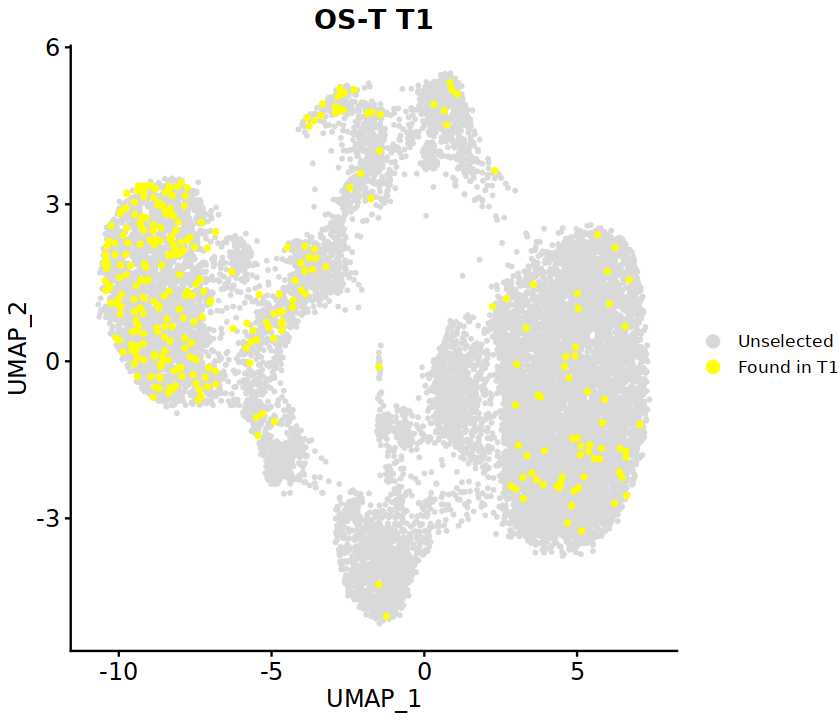

In [63]:
options(repr.plot.width = 7, repr.plot.height = 6, warn=-1,verbose = FALSE)

plt <- DimPlot(seurat_tcr, group.by = "highlight",
               cells.highlight=barcodes, 
                 na.value="#d9d9d9", label.color="OST-T1",
        pt.size = 0.6)  + 
  scale_color_manual(labels = c("Unselected", "Found in T1"), values = c("#d9d9d9", "#ffff00ff")) +
  theme(axis.text.x = element_text(size = 14),
              axis.text.y = element_text(size = 14),
              text = element_text(size = 14),
              legend.text = element_text(size = 10),
       plot.margin = unit(c(0, 0, 0, 0), "cm")) + 
       labs(title=tp) 

plt

In [64]:
list_plots <- list(plt+NoLegend())

In [65]:
yellow_pheno <- seurat_tcr@meta.data %>%
    dplyr::filter(!is.na(highlight)) %>%
    select(c("cdr3", lvl, "Tcell_clusters_all"))

head(yellow_pheno)

cdr3                                      
T0_CD3pos_AAACCTGCACTTCTGC-1 GCCAGCAGTTTAATGTTGTTGGGATATCAGCCCCAGCAT   
T0_CD3pos_AAACCTGCATCACGAT-1 GCCAGCTCACCACTCCCCTACGAGCAGTAC            
T0_CD3pos_AAACCTGGTAATCGTC-1 GCCAGCAGCTTGAGGGACGCCCAAAGCGGCTACACC      
T0_CD3pos_AAAGATGAGTGTACGG-1 GCCAGCAGTCGCTCCGGGACTACCTACAATGAGCAGTTC   
T0_CD3pos_AAAGTAGCACGACTCG-1 GCCAGCAGCTTAGACAGGGCCACCAATCAGCCCCAGCAT   
T0_CD3pos_AACACGTTCACAGTAC-1 GCCAGCAGCTTGGTCACCAGCGGGATAAACAATGAGCAGTTC
                             Tcell_clusters Tcell_clusters_all
T0_CD3pos_AAACCTGCACTTCTGC-1 1              1                 
T0_CD3pos_AAACCTGCATCACGAT-1 6              S1                
T0_CD3pos_AAACCTGGTAATCGTC-1 2              2                 
T0_CD3pos_AAAGATGAGTGTACGG-1 5              5                 
T0_CD3pos_AAAGTAGCACGACTCG-1 6              S0                
T0_CD3pos_AACACGTTCACAGTAC-1 2              2

`summarise()` has grouped output by 'cdr3'. You can override using the `.groups` argument.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


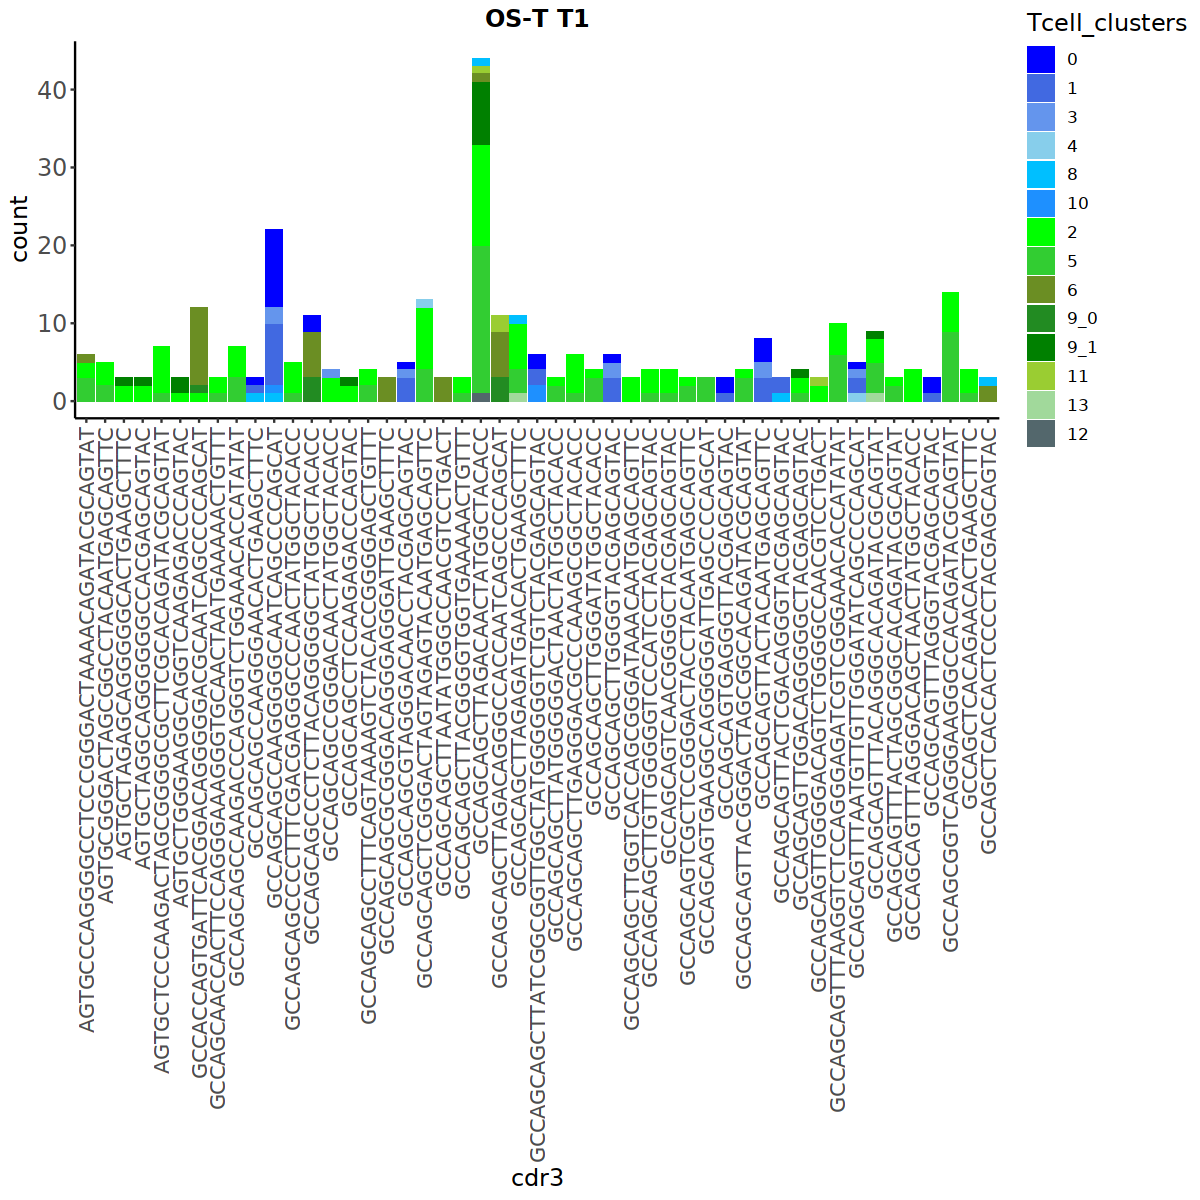

In [66]:
options(repr.plot.width = 10, repr.plot.height = 10, warn=-1,verbose = FALSE)
df_plot <- yellow_pheno %>% group_by(cdr3, !!as.name(lvl)) %>%
        summarise(
        count = n()
  ) %>% arrange(desc(count))

barplt <- pheno_bar(df_plot, lvl, tp,tumor_pal)
barplt

In [67]:
list_plots <- c(list_plots,list(barplt+NoLegend()))

In [68]:
proportions <- prop.table(table(yellow_pheno$Tcell_clusters))
proportions


          0           3           1          10           4           8 
0.079113924 0.028481013 0.082278481 0.009493671 0.006329114 0.018987342 
         11           6         9_0         9_1           2           5 
0.012658228 0.101265823 0.022151899 0.047468354 0.332278481 0.250000000 
         13           7          12 
0.006329114 0.000000000 0.003164557 

In [69]:
# fix order
proportions <- prop.table(table(yellow_pheno$Tcell_clusters))
keys_to_move <- c("6", "9_0", "11")
elements_to_move <- proportions[keys_to_move]
remaining_elements <- proportions[!(names(proportions) %in% keys_to_move)]
proportions <- c(remaining_elements, elements_to_move)

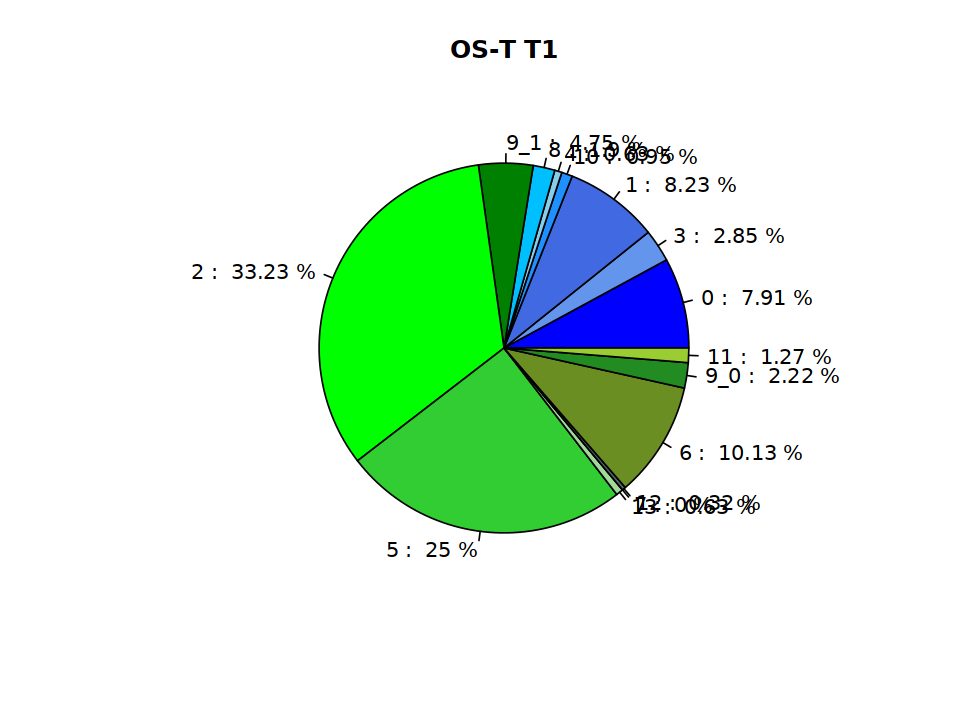

In [70]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)
pie(proportions, 
    labels = paste(names(proportions), ": ", 
                   round(proportions * 100, 2), "%"), 
     main = tp, col = unlist(tumor_pal[names(proportions)]))

In [71]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)

svg(here(glue("{tcr}/{plt_dir}/5.3-Tcells_pie_prop_{tp}.svg")))
pie(proportions, 
   labels = names(proportions), 
     main =tp, col = unlist(tumor_pal[names(proportions)]), cex=2)
dev.off()

png 
  2

In [72]:
proportions <- prop.table(table(yellow_pheno$Tcell_clusters_all))

In [73]:
# keep same order as before
keys_to_move <- names(proportions)[grepl("S", names(proportions))]
elements_to_move <- proportions[keys_to_move]
remaining_elements2 <- proportions[!(names(proportions) %in% keys_to_move)]
remaining_elements2 = remaining_elements2[names(remaining_elements)]
proportions <- c(remaining_elements, elements_to_move)

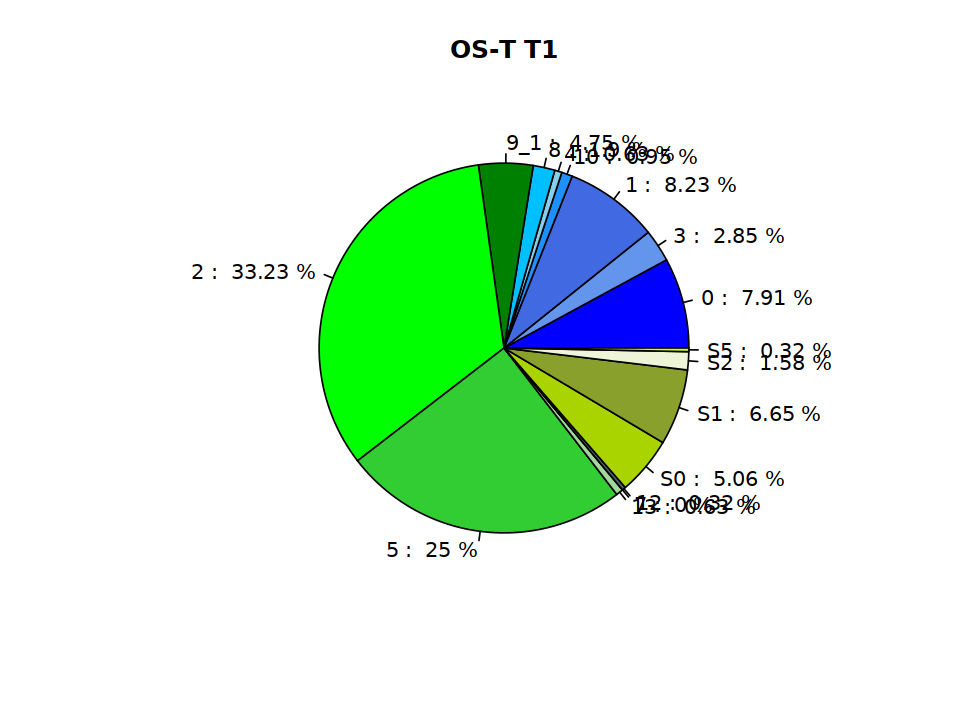

In [74]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)
pie(proportions, 
    labels = paste(names(proportions), ": ", 
                   round(proportions * 100, 2), "%"), 
     main = tp, col = unlist(tumor_pal[names(proportions)]))

In [75]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)

svg(here(glue("{tcr}/{plt_dir}/5.3-Tcells_pie_prop_{tp}_h.svg")))
pie_plot <- pie(proportions, 
   labels = names(proportions), 
     main =tp, col = unlist(tumor_pal[names(proportions)]), cex=2)
dev.off()

png 
  2

Expanded in T2/T3 found more than 1

In [76]:
df_plot <- df_summary %>% 
    dplyr::filter(counts_T2_3_OS > 1) %>%
    arrange(desc(counts_T2_3_OS	))
df_plot

cdr3                                          Freq_Tumor counts_T1_OS
1  GCCATCAGTGAGTCTCGTCTGTTCACTGAAGCTTTC           3          0          
2  GCCAGCAGCTTTAGGGGGACTAGCGGGAATCAAGAGACCCAGTAC  3          0          
3  GCCAGCAGCCGGGACAACTATGGCTACACC                 4         11          
4  GCCAGCAGCCACCGACGATACAATGAGCAGTTC              4          0          
5  GCCAGCAGTTACTACAATGAGCAGTTC                    8          7          
6  GCCATCTCTCTCATGCACAGCAATACCTATGGCTACACC        6          0          
7  GCCAGCAGCTTAGACAACTATGGCTACACC                44          2          
8  GCCAGCAGCTTGGTCACCAGCGGGATAAACAATGAGCAGTTC     3          3          
9  GCCAGCTCAATTGGGGCCAACGTCCTGACT                20          0          
10 GCCAGCAGCCGGGACAACTACGAGCAGTAC                10          0          
11 GCCAGTAGTACCGGGACTAGCTCCTACAATGAGCAGTTC        9          0          
12 GCCAGCAGCGCGGGACAGGGAGGGATTGAAGCTTTC           3          2          
13 GCCAGCAGTTTAGGGTACGAGCAGTAC                    3          5          
14 GCCAGCAGCCAACTAGCGGGCTCCTACAATGAGCAGTTC       56          0          
15 GCCAGCAGCCAAGGGGGCAATCAGCCCCAGCAT             22         46          
16 GCCAGCAGCTTAGATCGGCAGGTTGGCTACACC              5          0          
17 GCCAGCAGTTGGACAGGGGGCTACGAGCAGTAC              4          2          
18 GCCAGCAGTTTACTAGCGGGCACAGATACGCAGTAT           3          9          
19 GCCAGCAGTTTGGGACAGAACACTGAAGCTTTC              3          1          
   counts_T2_3_OS counts_T4_OS counts_T5_OS counts_T6_OS counts_T7_OS
1  18              1            1            1           15          
2  12              2            1            0            0          
3   9             10            2           14            0          
4   8              5            0            0            0          
5   6              3            2            0            5          
6   6              1            2            0            1          
7   5             18           15           20            1          
8   5             20            5           14            3          
9   3              0            0            0            0          
10  3              0            0            0            0          
11  3              5            0            0            0          
12  3              0            0            2            1          
13  3              0            0            3            2          
14  2              0            0            0            0          
15  2              0            1            0            0          
16  2              0            0            0            0          
17  2              3            5            1            0          
18  2              1            1            1            1          
19  2              5            1            4            2

In [77]:
print(dim(df_plot))
print(length(unique(df_plot$cdr3)))

[1] 19  8
[1] 19


In [78]:
seurat_tcr <- highlightClonotypes(seurat_tcr, 
              cloneCall="cdr3", 
              sequence = unique(df_plot$cdr3))

In [79]:
barcodes <- seurat_tcr@meta.data %>%
    dplyr::filter(!is.na(highlight)) %>%
   rownames_to_column(var = "Barcode") %>%
    pull(Barcode)


In [80]:
tp = "OS-T T2/3"

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


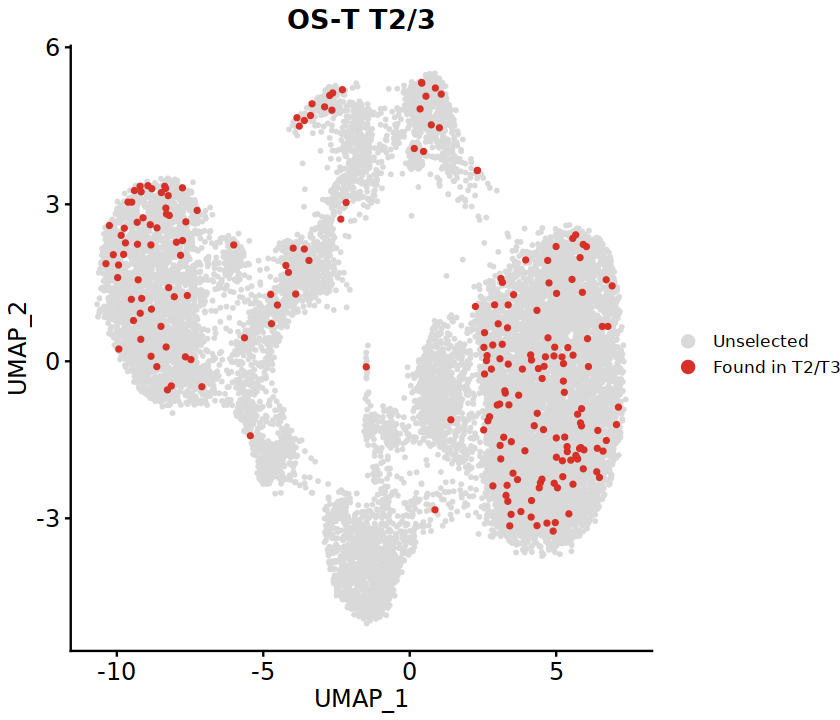

In [81]:
options(repr.plot.width = 7, repr.plot.height = 6, warn=-1,verbose = FALSE)

plt <- DimPlot(seurat_tcr, group.by = "highlight",
               cells.highlight=barcodes, 
                 na.value="#d9d9d9", label.color="OST-T2/3",
        pt.size = 0.6)  + 
  scale_color_manual(labels = c("Unselected", "Found in T2/T3"), values = c("#d9d9d9", "#d73027")) +
  theme(axis.text.x = element_text(size = 14),
              axis.text.y = element_text(size = 14),
              text = element_text(size = 14),
              legend.text = element_text(size = 10),
       plot.margin = unit(c(0, 0, 0, 0), "cm")) + 
       labs(title=tp) 

plt + theme(plot.margin = unit(c(0, 0, 0, 0), "cm"))

In [82]:
list_plots <- c(list_plots,list(plt+NoLegend()))

In [83]:
red_pheno <- seurat_tcr@meta.data %>%
    dplyr::filter(!is.na(highlight)) %>%
    select(c("cdr3", lvl, "Tcell_clusters_all"))

head(red_pheno)

cdr3                                      
T0_CD3pos_AAAGATGAGATCCCAT-1 GCCATCTCTCTCATGCACAGCAATACCTATGGCTACACC   
T0_CD3pos_AAAGATGTCATCGATG-1 GCCAGCAGCCAACTAGCGGGCTCCTACAATGAGCAGTTC   
T0_CD3pos_AACACGTTCACAGTAC-1 GCCAGCAGCTTGGTCACCAGCGGGATAAACAATGAGCAGTTC
T0_CD3pos_AACTTTCAGCAGCCTC-1 GCCAGCAGCCAACTAGCGGGCTCCTACAATGAGCAGTTC   
T0_CD3pos_AACTTTCTCACATACG-1 GCCAGCAGTTTACTAGCGGGCACAGATACGCAGTAT      
T0_CD3pos_AAGACCTAGAGCTATA-1 GCCAGCAGCCAAGGGGGCAATCAGCCCCAGCAT         
                             Tcell_clusters Tcell_clusters_all
T0_CD3pos_AAAGATGAGATCCCAT-1 6              S0                
T0_CD3pos_AAAGATGTCATCGATG-1 3              3                 
T0_CD3pos_AACACGTTCACAGTAC-1 2              2                 
T0_CD3pos_AACTTTCAGCAGCCTC-1 10             10                
T0_CD3pos_AACTTTCTCACATACG-1 5              5                 
T0_CD3pos_AAGACCTAGAGCTATA-1 0              0

`summarise()` has grouped output by 'cdr3'. You can override using the `.groups` argument.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


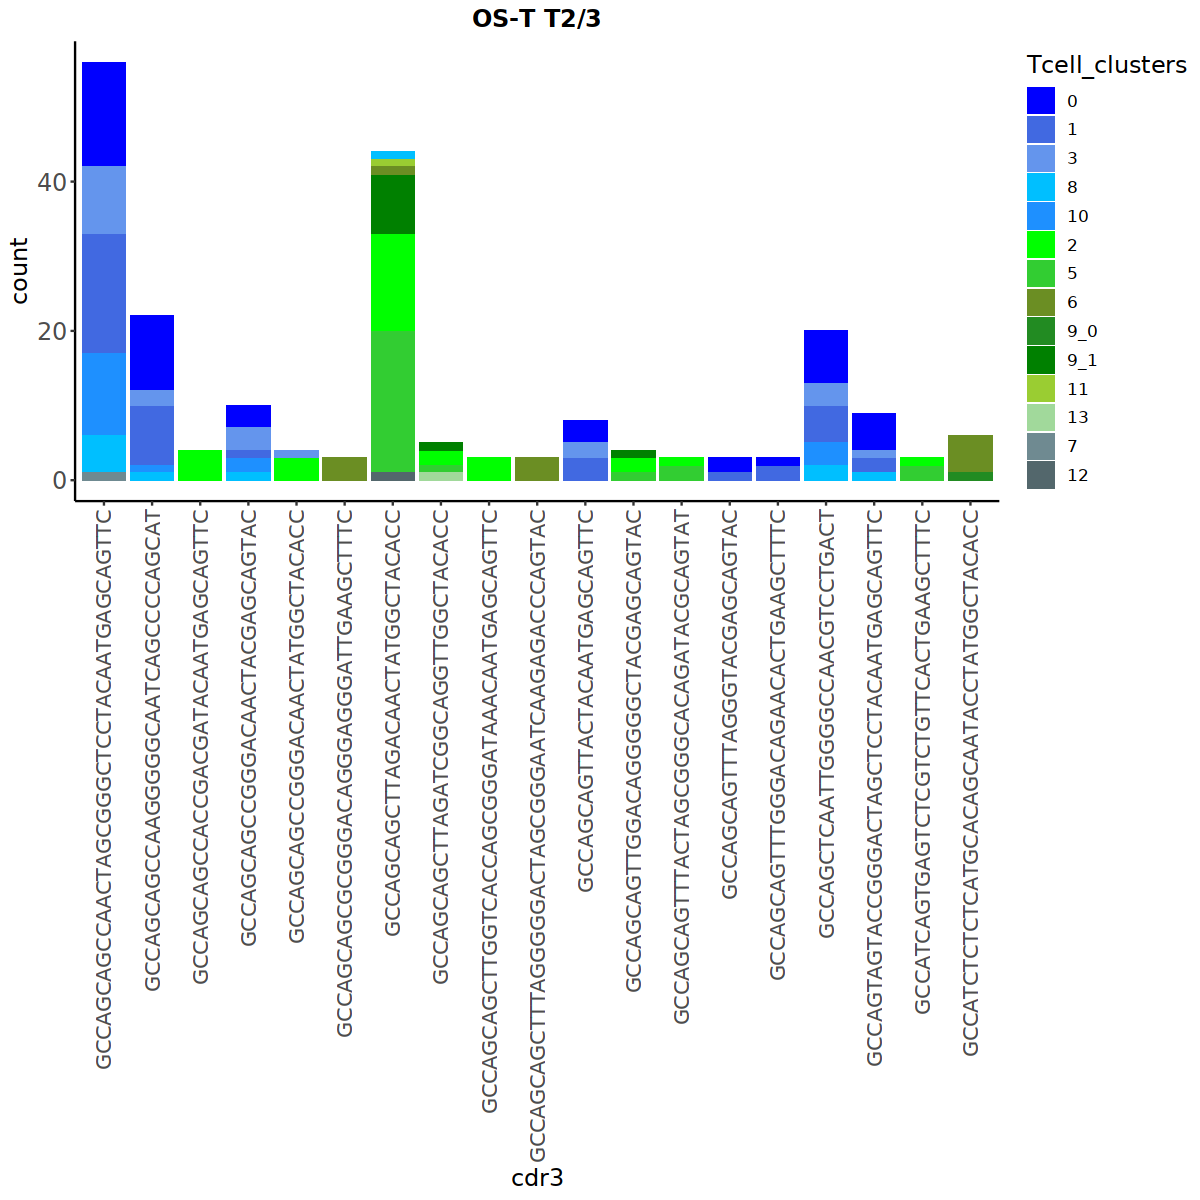

In [84]:
options(repr.plot.width = 10, repr.plot.height = 10, warn=-1,verbose = FALSE)
df_plot <- red_pheno %>% group_by(cdr3, !!as.name(lvl)) %>%
        summarise(
        count = n()
  ) %>% arrange(desc(count))

barplt <- pheno_bar(df_plot, lvl, tp,tumor_pal)
barplt

In [85]:
list_plots <- c(list_plots,list(barplt+NoLegend()))

In [86]:
proportions <- prop.table(table(red_pheno$Tcell_clusters))

In [87]:
# fix order
proportions <- prop.table(table(red_pheno$Tcell_clusters))
keys_to_move <- c("6", "9_0", "11")
elements_to_move <- proportions[keys_to_move]
remaining_elements <- proportions[!(names(proportions) %in% keys_to_move)]
proportions <- c(remaining_elements, elements_to_move)

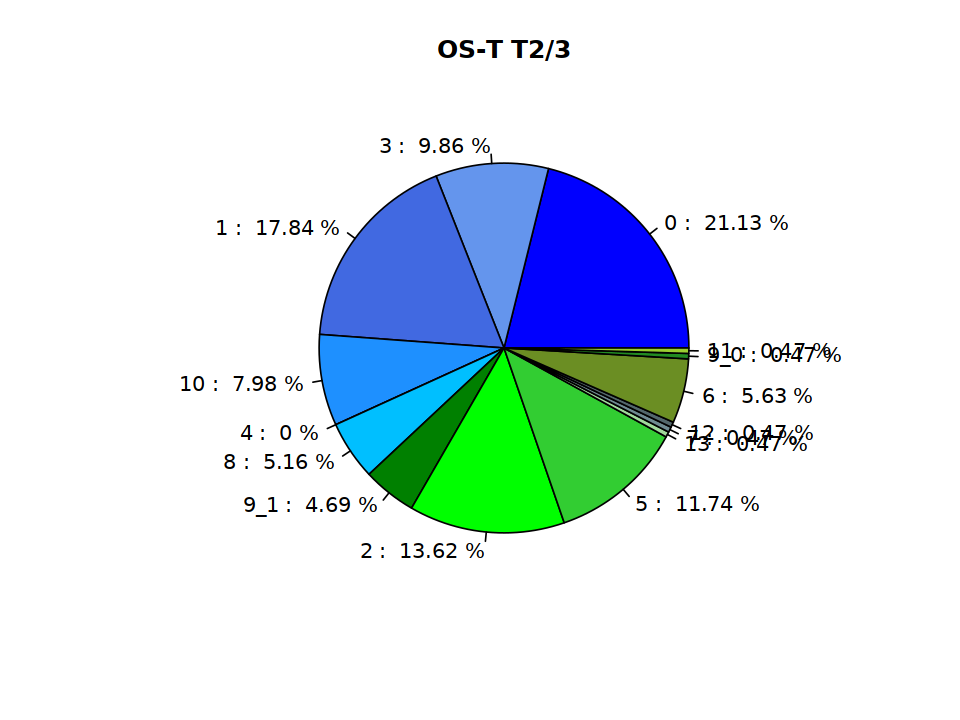

In [88]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)
pie(proportions, 
    labels = paste(names(proportions), ": ", 
                   round(proportions * 100, 2), "%"), 
     main = tp, col = unlist(tumor_pal[names(proportions)]))

In [89]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)

svg(here(glue("{tcr}/{plt_dir}/5.3-Tcells_pie_prop_OS-T2a3.svg")))
pie(proportions, 
   labels = names(proportions), 
     main =tp, col = unlist(tumor_pal[names(proportions)]), cex=2)
dev.off()

png 
  2

In [90]:
proportions <- prop.table(table(red_pheno$Tcell_clusters_all))

In [91]:
# keep same order as before
keys_to_move <- names(proportions)[grepl("S", names(proportions))]
elements_to_move <- proportions[keys_to_move]
remaining_elements2 <- proportions[!(names(proportions) %in% keys_to_move)]
remaining_elements2 = remaining_elements2[names(remaining_elements)]
proportions <- c(remaining_elements, elements_to_move)

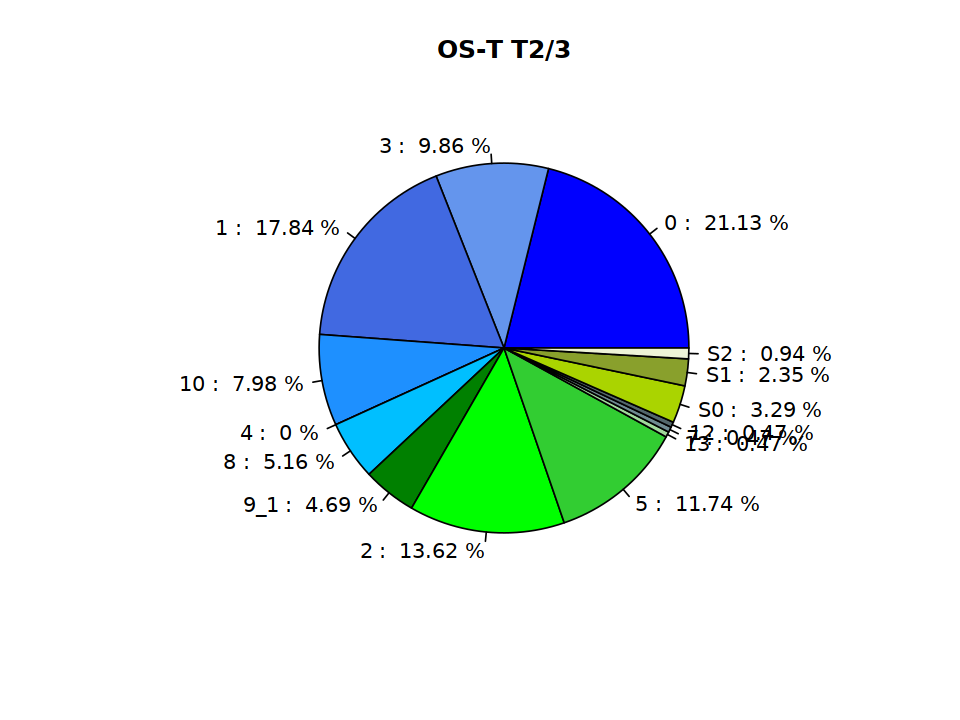

In [92]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)
pie(proportions, 
    labels = paste(names(proportions), ": ", 
                   round(proportions * 100, 2), "%"), 
     main = tp, col = unlist(tumor_pal[names(proportions)]))

In [93]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)

svg(here(glue("{tcr}/{plt_dir}/5.3-Tcells_pie_prop_T2a3_h.svg")))
pie_plot <- pie(proportions, 
   labels = names(proportions), 
     main =tp, col = unlist(tumor_pal[names(proportions)]), cex=2)
dev.off()

png 
  2

Expanded in T4 found more than 1

In [94]:
df_plot <- df_summary %>% 
    dplyr::filter(counts_T4_OS > 1) %>%
    arrange(desc(counts_T4_OS))
df_plot

cdr3                                                   Freq_Tumor
1  GCCAGCAGCCAATCTAGGGCGGGAGACAATGAGCAGTTC                 6        
2  GCCAGCATCTTAAGTAGCCCCCCTGGGGCCCAGTAC                    4        
3  GCCAGCAGCTTGGTCACCAGCGGGATAAACAATGAGCAGTTC              3        
4  GCCAGCAGCTTAGACAACTATGGCTACACC                         44        
5  GCCAGCAGTGGGGGGGTGACAGGGTCGGGTCAGCCCCAGCAT             20        
6  GCCAGCAGCGAAACTCATTGGAACACTGAAGCTTTC                    3        
7  GCCAGCAGCCGGGACAACTATGGCTACACC                          4        
8  GCCAGCAGTTTAACCCGGGACACTGAAGCTTTC                       3        
9  GCCAGCGGACAGGGGGCTTCCACAGATACGCAGTAT                    8        
10 GCCAGCAGTTACGGAGGAGATACGCAGTAT                          3        
11 GCCAGCAGCTTAGCCAGAGGCACAGATACGCAGTAT                   13        
12 GCCAGCAGCTTAGGAGGGGATGGCGAGACCCAGTAC                    9        
13 GCCAGCAGTTTAATCGAACTGACTAGCGGGAGGTTGGGGTACAATGAGCAGTTC  8        
14 GCCAGCAGCTTGGGAACTCCATCGGGTGAAAAACTGTTT                 3        
15 GCCAGCAGCTTAGACAGGGCCACCAATCAGCCCCAGCAT                11        
16 GCCAGTAGTACCGGGACTAGCTCCTACAATGAGCAGTTC                 9        
17 GCCAGCAGCCACCGACGATACAATGAGCAGTTC                       4        
18 GCCAGCAGTTTGGGACAGAACACTGAAGCTTTC                       3        
19 GCCAGCAGCCCTCTTACAGGGGGCTATGGCTACACC                   11        
20 GCCAGCAGTTACGGGGAAAAACTGTTT                            11        
21 GCCAGCAGCGAGGGCCCTAGCGGGAGCTCCTACAATGAGCAGTTC           9        
22 GCCAGCAGTTACTACAATGAGCAGTTC                             8        
23 AGTGCTCGAATCAGGGAAAAGAACACTGAAGCTTTC                    4        
24 GCCAGCAGTTGGACAGGGGGCTACGAGCAGTAC                       4        
25 GCCAGCTCACAGAACACTGAAGCTTTC                             4        
26 GCCAGCAGCCAATACGGGGGTTCCTATAATTCACCCCTCCAC              3        
27 AGTGCTATAAGCCGCAGCTCCTACGAGCAGTAC                       5        
28 GCCAGCAGTTTTAGGGCTAGCGGCAAGCAGTAC                       4        
29 GCCAGCAGCATTAAAGGGAGGACCCAGTAC                          3        
30 GCCAGCAGCGTACATAACTATGGCTACACC                          3        
31 GCCAGCAGCTTACGGGGTGGTGAAAAACTGTTT                       3        
32 GCCAGCAGCTTTAGGGGGACTAGCGGGAATCAAGAGACCCAGTAC           3        
33 GCCAGCAGTGAAGGGGGAGGTACTAATGAAAAACTGTTT                 3        
34 GCCAGCTCACCACTCCCCTACGAGCAGTAC                          3        
   counts_T1_OS counts_T2_3_OS counts_T4_OS counts_T5_OS counts_T6_OS
1   0            0             74           28            2          
2   0            0             70           11            3          
3   3            5             20            5           14          
4   2            5             18           15           20          
5   0            0             12            3            1          
6   1            0             12            9            4          
7  11            9             10            2           14          
8   0            0              9            2            0          
9   1            0              8            2            1          
10  0            0              8            3            0          
11  0            0              7            1            0          
12  0            0              7            4            2          
13  0            0              7            3            1          
14  0            0              7            0            0          
15  3            0              5            0            2          
16  0            3              5            0            0          
17  0            8              5            0            0          
18  1            2              5            1            4          
19  3            0              4            0            0          
20  0            0              3            2           10          
21  0            1              3            0            0          
22  7            6              3            2  

In [95]:
print(dim(df_plot))
print(length(unique(df_plot$cdr3)))

[1] 34  8
[1] 34


In [96]:
seurat_tcr <- highlightClonotypes(seurat_tcr, 
              cloneCall="cdr3", 
              sequence = unique(df_plot$cdr3))

In [97]:
orange_pheno <- seurat_tcr@meta.data %>%
    dplyr::filter(!is.na(highlight)) %>%
    select(c("cdr3", lvl,"Tcell_clusters_all"))

In [98]:
barcodes <- seurat_tcr@meta.data %>%
    dplyr::filter(!is.na(highlight)) %>%
   rownames_to_column(var = "Barcode") %>%
    pull(Barcode)

In [99]:
tp <- "OS-T T4"

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


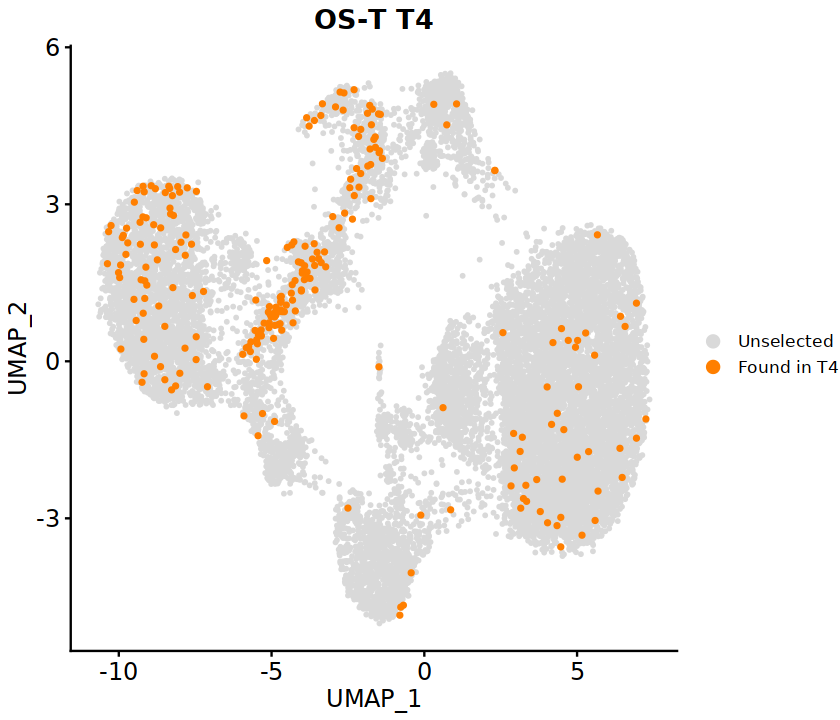

In [100]:
options(repr.plot.width = 7, repr.plot.height = 6, warn=-1,verbose = FALSE)

plt <- DimPlot(seurat_tcr, group.by = "highlight",
               cells.highlight=barcodes, 
                 na.value="#d9d9d9", 
        pt.size = 0.6)  +  
  scale_color_manual(labels = c("Unselected", "Found in T4"), values = c("#d9d9d9","#ff7f00")) +
  theme(axis.text.x = element_text(size = 14),
              axis.text.y = element_text(size = 14),
              text = element_text(size = 14),
              legend.text = element_text(size = 10),
       plot.margin = unit(c(0, 0, 0, 0), "cm")) + 
       labs(title=tp) 

plt + theme(plot.margin = unit(c(0, 0, 0, 0), "cm"))

In [101]:
list_plots <- c(list_plots,list(plt+NoLegend()))

`summarise()` has grouped output by 'cdr3'. You can override using the `.groups` argument.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


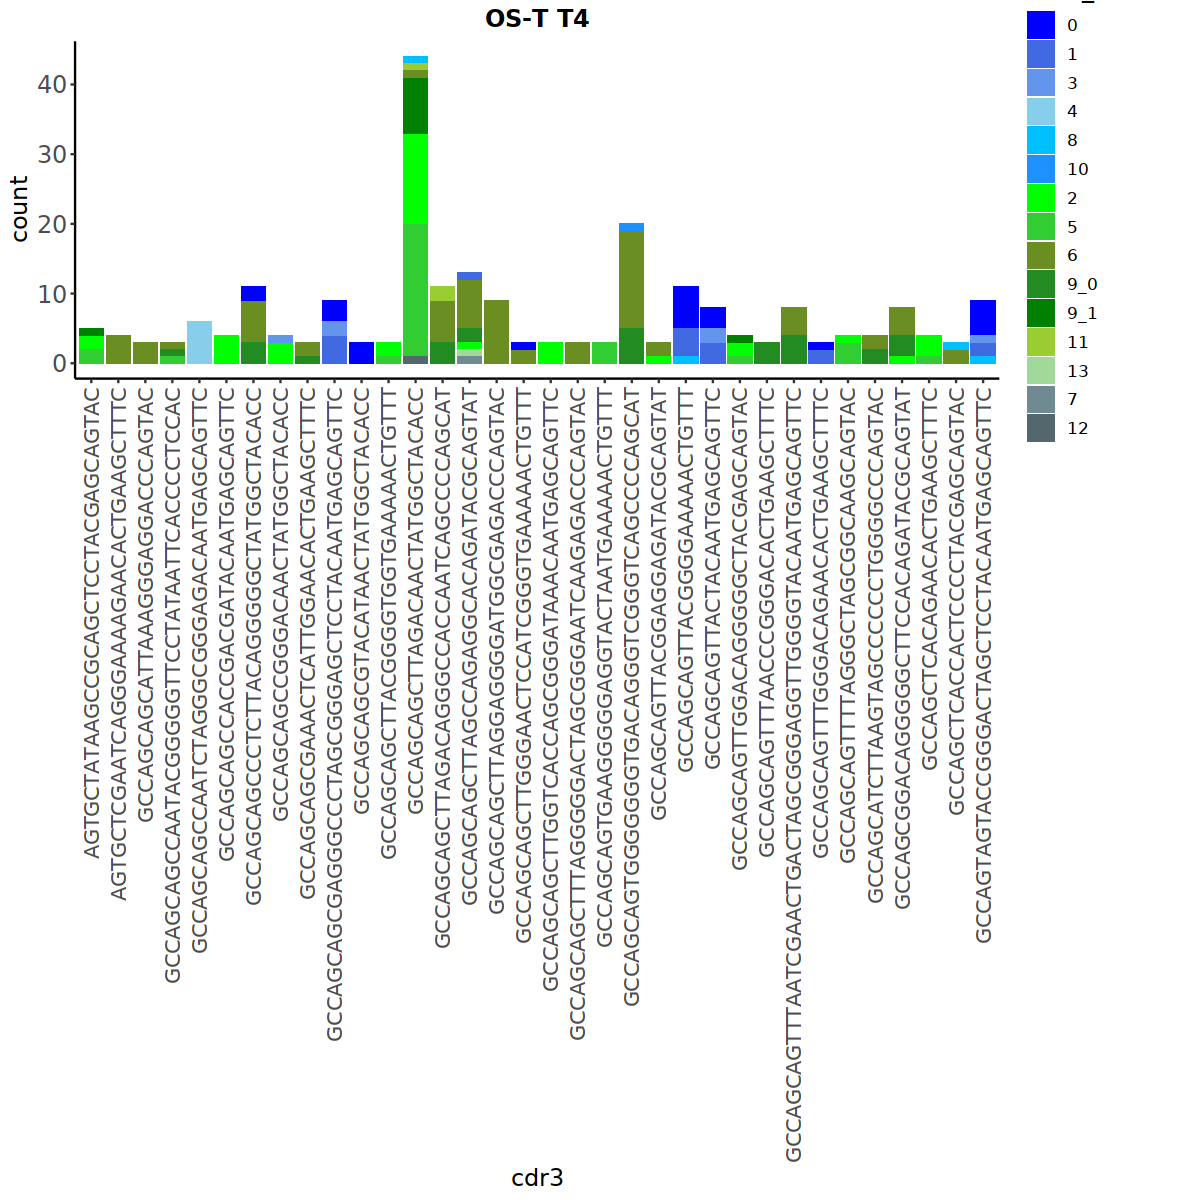

In [102]:
options(repr.plot.width = 10, repr.plot.height = 10, warn=-1,verbose = FALSE)
df_plot <- orange_pheno %>% group_by(cdr3, !!as.name(lvl)) %>%
        summarise(
        count = n()
  ) %>% arrange(desc(count))

barplt <- pheno_bar(df_plot, lvl, tp,tumor_pal)
barplt

In [103]:
list_plots <- c(list_plots,list(barplt+NoLegend()))

In [104]:
proportions <- prop.table(table(orange_pheno$Tcell_clusters))

In [105]:
# fix order
proportions <- prop.table(table(orange_pheno$Tcell_clusters))
keys_to_move <- c("6", "9_0", "11")
elements_to_move <- proportions[keys_to_move]
remaining_elements <- proportions[!(names(proportions) %in% keys_to_move)]
proportions <- c(remaining_elements, elements_to_move)

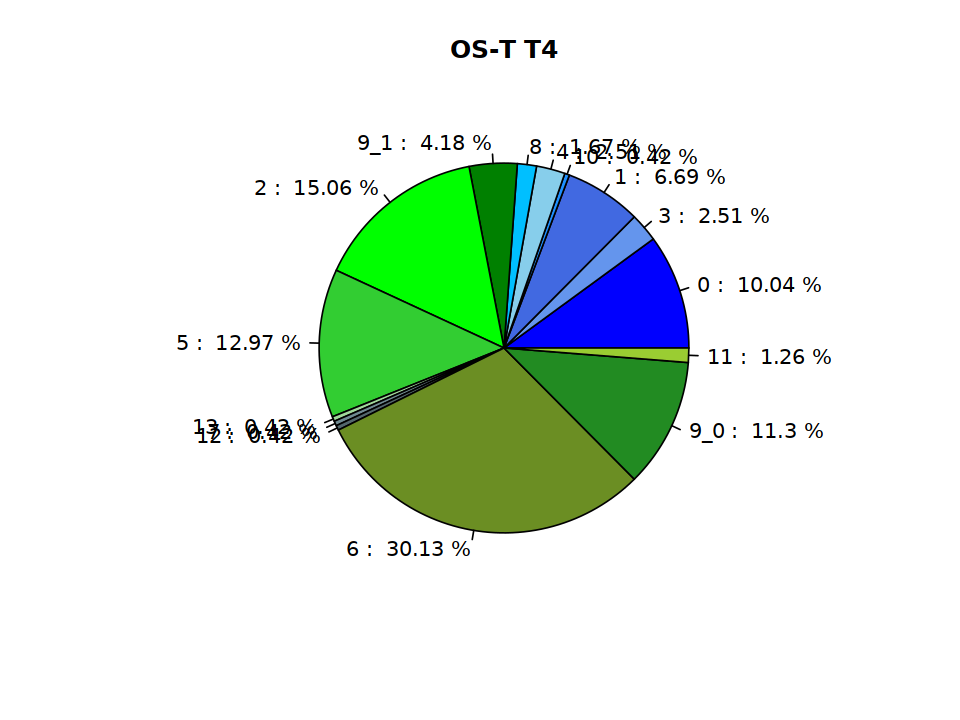

In [106]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)
pie(proportions, 
    labels = paste(names(proportions), ": ", 
                   round(proportions * 100, 2), "%"), 
     main = tp, col = unlist(tumor_pal[names(proportions)]))

In [107]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)

svg(here(glue("{tcr}/{plt_dir}/5.3-Tcells_pie_prop_{tp}.svg")))
pie(proportions, 
   labels = names(proportions), 
     main =tp, col = unlist(tumor_pal[names(proportions)]), cex=2)
dev.off()

png 
  2

In [108]:
proportions <- prop.table(table(orange_pheno$Tcell_clusters_all))

In [109]:
# keep same order as before
keys_to_move <- names(proportions)[grepl("S", names(proportions))]
elements_to_move <- proportions[keys_to_move]
remaining_elements2 <- proportions[!(names(proportions) %in% keys_to_move)]
remaining_elements2 = remaining_elements2[names(remaining_elements)]
proportions <- c(remaining_elements, elements_to_move)

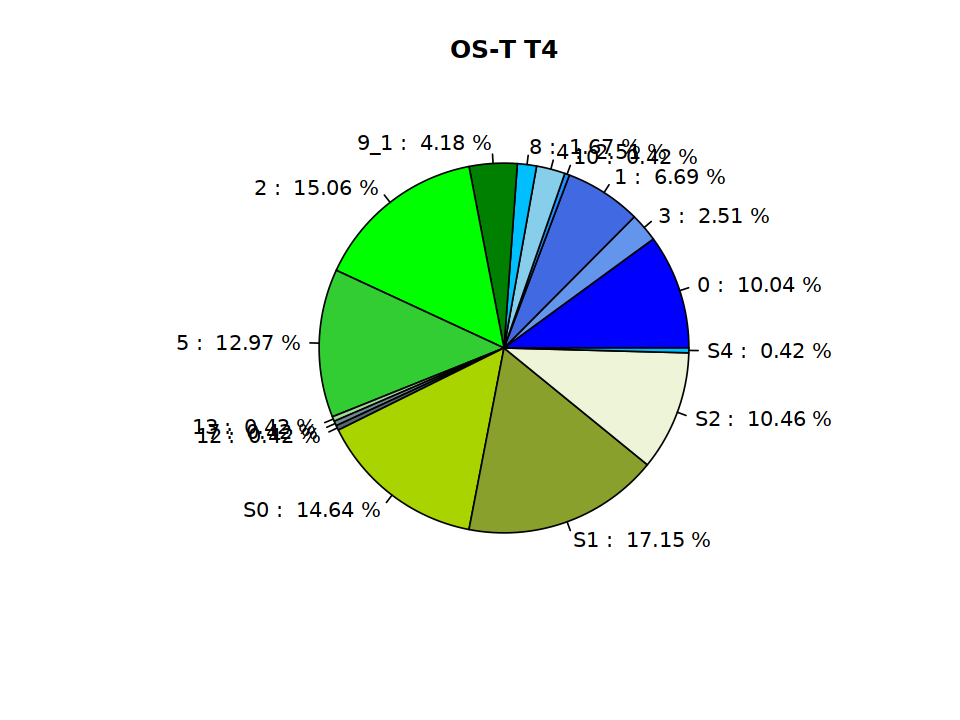

In [110]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)
pie(proportions, 
    labels = paste(names(proportions), ": ", 
                   round(proportions * 100, 2), "%"), 
     main = tp, col = unlist(tumor_pal[names(proportions)]))

In [111]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)

svg(here(glue("{tcr}/{plt_dir}/5.3-Tcells_pie_prop_{tp}_h.svg")))
pie_plot <- pie(proportions, 
   labels = names(proportions), 
     main =tp, col = unlist(tumor_pal[names(proportions)]), cex=2)
dev.off()

png 
  2

Expanded in T5 found more than 1

In [112]:
df_plot <- df_summary %>% 
    dplyr::filter(counts_T5_OS > 1) %>%
    arrange(desc(counts_T5_OS))
df_plot

cdr3                                                   Freq_Tumor
1  GCCAGCAGCTTGCACAGGGACACAGATACGCAGTAT                   13        
2  GCCAGCAGCTTAACCCGGGACACAGATACGCAGTAT                    3        
3  GCCAGCAGCCAATCTAGGGCGGGAGACAATGAGCAGTTC                 6        
4  GCCAGCAGCTTAGACAACTATGGCTACACC                         44        
5  GCCAGCATCTTAAGTAGCCCCCCTGGGGCCCAGTAC                    4        
6  GCCAGCAGCGAAACTCATTGGAACACTGAAGCTTTC                    3        
7  GCCAGCAGTTGGACAGGGGGCTACGAGCAGTAC                       4        
8  GCCAGCAGCTTGGTCACCAGCGGGATAAACAATGAGCAGTTC              3        
9  GCCAGCAGCTTAGGAGGGGATGGCGAGACCCAGTAC                    9        
10 GCCAGCAGCTTGGGACACAGCACAGATACGCAGTAT                    8        
11 GCCAGCAGCTTAGCCAGGAACACTGAAGCTTTC                       6        
12 GCCAGCAGTTTTAGGGCTAGCGGCAAGCAGTAC                       4        
13 GCCAGCAGTGGGGGGGTGACAGGGTCGGGTCAGCCCCAGCAT             20        
14 GCCAGCAGTTTAATCGAACTGACTAGCGGGAGGTTGGGGTACAATGAGCAGTTC  8        
15 AGTGCTATAAGCCGCAGCTCCTACGAGCAGTAC                       5        
16 GCCAGCAGCCAAGGGAACACTGAAGCTTTC                          3        
17 GCCAGCAGCCAATACGGGGGTTCCTATAATTCACCCCTCCAC              3        
18 GCCAGCAGTTACGGAGGAGATACGCAGTAT                          3        
19 GCCAGCAGTTTCGGGGGGGACGGGGGGACCCAGTAC                   12        
20 GCCAGCAGTTACGGGGAAAAACTGTTT                            11        
21 GCCAGCAGTTACTACAATGAGCAGTTC                             8        
22 GCCAGCGGACAGGGGGCTTCCACAGATACGCAGTAT                    8        
23 GCCAGCAGCCGACTAGCGGGAGATACGCAGTAT                       6        
24 GCCATCTCTCTCATGCACAGCAATACCTATGGCTACACC                 6        
25 GCCAGCAGCCGGGACAACTATGGCTACACC                          4        
26 GCCAGCAGTTTAACCCGGGACACTGAAGCTTTC                       3        
   counts_T1_OS counts_T2_3_OS counts_T4_OS counts_T5_OS counts_T6_OS
1   1           0               0           50           10          
2   0           0               0           34            1          
3   0           0              74           28            2          
4   2           5              18           15           20          
5   0           0              70           11            3          
6   1           0              12            9            4          
7   2           2               3            5            1          
8   3           5              20            5           14          
9   0           0               7            4            2          
10  0           0               1            4            0          
11  0           0               0            4            0          
12  0           0               2            4            1          
13  0           0              12            3            1          
14  0           0               7            3            1          
15  0           0               2            3            0          
16  5           0               0            3            0          
17  0           0               3            3            0          
18  0           0               8            3            0          
19  0           0               0            2            1          
20  0           0               3            2           10          
21  7           6               3            2            0          
22  1           0               8            2            1          
23  1           0               1            2            0          
24  0           6               1            2            0          
25 11           9              10            2           14          
26  0           0               9            2            0          
   counts_T7_OS
1   4          
2   1          
3   1          
4   1          
5   5          
6  14          
7   0          
8   3          
9   3          
10  4          
11  0          
12  0          
13  0          
14  5          
15  0     

In [113]:
print(dim(df_plot))
print(length(unique(df_plot$cdr3)))

[1] 26  8
[1] 26


In [114]:
seurat_tcr <- highlightClonotypes(seurat_tcr, 
              cloneCall="cdr3", 
              sequence = unique(df_plot$cdr3))

In [115]:
purple_pheno <- seurat_tcr@meta.data %>%
    dplyr::filter(!is.na(highlight)) %>%
    select(c("cdr3", lvl,"Tcell_clusters_all"))

In [116]:
barcodes <- seurat_tcr@meta.data %>%
    dplyr::filter(!is.na(highlight)) %>%
    rownames_to_column(var = "Barcode") %>%
    pull(Barcode)

In [117]:
head(seurat_tcr@meta.data)

orig.ident    nCount_RNA nFeature_RNA
T0_CD3pos_AAACCTGAGCAGCCTC-1 SCGRES_99_100 1718        912        
T0_CD3pos_AAACCTGAGCAGCGTA-1 SCGRES_99_100 5583       1906        
T0_CD3pos_AAACCTGAGCTAACTC-1 SCGRES_99_100 9529       3297        
T0_CD3pos_AAACCTGAGGGTGTTG-1 SCGRES_99_100 4068       1554        
T0_CD3pos_AAACCTGAGGTGTTAA-1 SCGRES_99_100 5378       2152        
T0_CD3pos_AAACCTGCAAGCGAGT-1 SCGRES_99_100 2656       1117        
                             sample_org     timepoint replicate sample_id
T0_CD3pos_AAACCTGAGCAGCCTC-1 CC2269CD3pos_1 T0        1         T0_CD3pos
T0_CD3pos_AAACCTGAGCAGCGTA-1 CC2269CD3pos_1 T0        1         T0_CD3pos
T0_CD3pos_AAACCTGAGCTAACTC-1 CC2269CD3pos_1 T0        1         T0_CD3pos
T0_CD3pos_AAACCTGAGGGTGTTG-1 CC2269CD3pos_1 T0        1         T0_CD3pos
T0_CD3pos_AAACCTGAGGTGTTAA-1 CC2269CD3pos_1 T0        1         T0_CD3pos
T0_CD3pos_AAACCTGCAAGCGAGT-1 CC2269CD3pos_1 T0        1         T0_CD3pos
                             pct_mt   percent.ribo doublet_score ⋯
T0_CD3pos_AAACCTGAGCAGCCTC-1 4.016298 18.62631     0.03559951    ⋯
T0_CD3pos_AAACCTGAGCAGCGTA-1 1.970267 29.84059     0.14168766    ⋯
T0_CD3pos_AAACCTGAGCTAACTC-1 1.899465 15.11176     0.07415991    ⋯
T0_CD3pos_AAACCTGAGGGTGTTG-1 2.261554 31.98132     0.40553360    ⋯
T0_CD3pos_AAACCTGAGGTGTTAA-1 1.822239 19.41242     0.09983242    ⋯
T0_CD3pos_AAACCTGCAAGCGAGT-1 3.049699 20.36898     0.02405428    ⋯
                             barcode                     
T0_CD3pos_AAACCTGAGCAGCCTC-1 T0_CD3pos_AAACCTGAGCAGCCTC-1
T0_CD3pos_AAACCTGAGCAGCGTA-1 T0_CD3pos_AAACCTGAGCAGCGTA-1
T0_CD3pos_AAACCTGAGCTAACTC-1 NA                          
T0_CD3pos_AAACCTGAGGGTGTTG-1 T0_CD3pos_AAACCTGAGGGTGTTG-1
T0_CD3pos_AAACCTGAGGTGTTAA-1 T0_CD3pos_AAACCTGAGGTGTTAA-1
T0_CD3pos_AAACCTGCAAGCGAGT-1 T0_CD3pos_AAACCTGCAAGCGAGT-1
                             CTgene                   
T0_CD3pos_AAACCTGAGCAGCCTC-1 TRBV5-6.NA.TRBJ1-2.TRBC1 
T0_CD3pos_AAACCTGAGCAGCGTA-1 TRBV5-1.NA.TRBJ1-2.TRBC1 
T0_CD3pos_AAACCTGAGCTAACTC-1 NA                       
T0_CD3pos_AAACCTGAGGGTGTTG-1 TRBV3-1.NA.TRBJ2-1.TRBC2 
T0_CD3pos_AAACCTGAGGTGTTAA-1 TRBV12-3.NA.TRBJ2-1.TRBC2
T0_CD3pos_AAACCTGCAAGCGAGT-1 TRBV6-1.NA.TRBJ1-6.TRBC1 
                             CTnt                                            
T0_CD3pos_AAACCTGAGCAGCCTC-1 TGTGCCAGCAGCTTGTGGGGTAAAAGTCTTGGCTACACCTTC      
T0_CD3pos_AAACCTGAGCAGCGTA-1 TGCGCCAGCAGCTTGGATAACTATGGCTACACCTTC            
T0_CD3pos_AAACCTGAGCTAACTC-1 NA                                              
T0_CD3pos_AAACCTGAGGGTGTTG-1 TGTGCCAGCAGCCTCTATGACAGGGAAAGCGGCAATGAGCAGTTCTTC
T0_CD3pos_AAACCTGAGGTGTTAA-1 TGTGCCAGCAGTGCCGGGACTTCATACAATGAGCAGTTCTTC      
T0_CD3pos_AAACCTGCAAGCGAGT-1 TGTGCCAGCAGTGAAGCTGGGGAAATATGGTATTCACCCCTCCACTTT
                             CTaa            
T0_CD3pos_AAACCTGAGCAGCCTC-1 CASSLWGKSLGYTF  
T0_CD3pos_AAACCTGAGCAGCGTA-1 CASSLDNYGYTF    
T0_CD3pos_AAACCTGAGCTAACTC-1 NA              
T0_CD3pos_AAACCTGAGGGTGTTG-1 CASSLYDRESGNEQFF
T0_CD3pos_AAACCTGAGGTGTTAA-1 CASSAGTSYNEQFF  
T0_CD3pos_AAACCTGCAAGCGAGT-1 CASSEAGEIWYSPLHF
                             CTstrict                                                                                                                                   
T0_CD3pos_AAACCTGAGCAGCCTC-1 TRAV29/DV5.TRAJ40.TRAC_TGTGCAGCAAGCGCGGGAACCTACAAATACATCTTT_TRBV5-6.NA.TRBJ1-2.TRBC1_TGTGCCAGCAGCTTGTGGGGTAAAAGTCTTGGCTACACCTTC            
T0_CD3pos_AAACCTGAGCAGCGTA-1 NA_NA_TRBV5-1.NA.TRBJ1-2.TRBC1_TGCGCCAGCAGCTTGGATAACTATGGCTACACCTTC                                                                        
T0_CD3pos_AAACCTGAGCTAACTC-1 NA                                                                                                                                         
T0_CD3pos_AAACCTGAGGGTGTTG-1 TRAV29/DV5.TRAJ49.TRAC_TGTGCAGCAAGCCTACCGAACACCGGTAACCAGTTCTATTTT_TRBV3-1.NA.TRBJ2-1.TRBC2_TGTGCCAGCAGCCTCTATGACAGGGAAAGCGGCAATGAGCAGTTCTTC
T0_CD3pos_AAACCTGAGGTGTTAA-1 TRAV35.TRAJ48.TRAC_TGTGCTGGGCGCGGATCTAAC

In [118]:
tp = "OS-T T5"

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


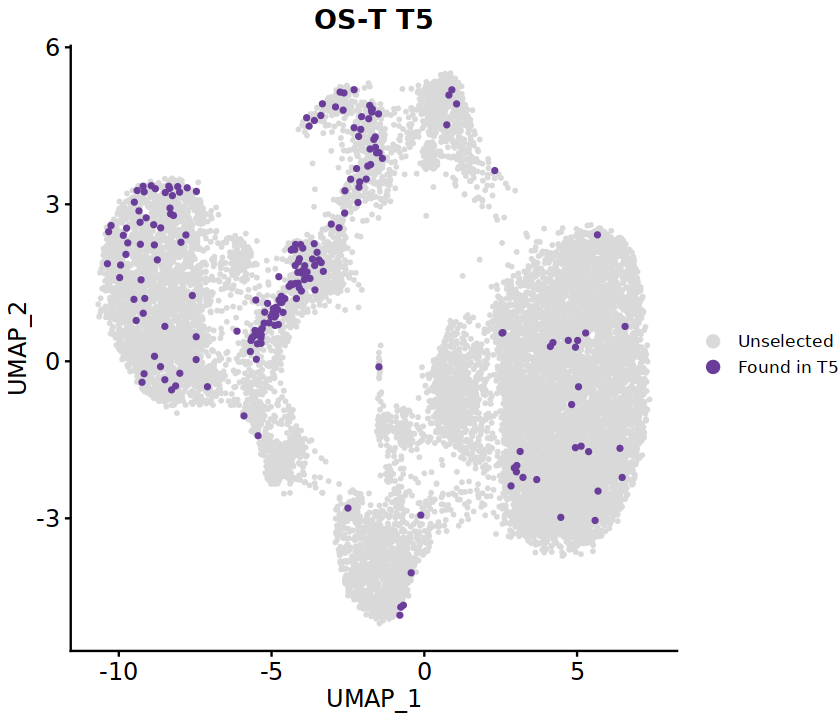

In [119]:
options(repr.plot.width = 7, repr.plot.height = 6, warn=-1,verbose = FALSE)

plt <- DimPlot(seurat_tcr, group.by = "highlight",
               cells.highlight=barcodes, 
                 na.value="#d9d9d9", 
        pt.size = 0.6)  +  
  scale_color_manual(labels = c("Unselected", "Found in T5"), values = c("#d9d9d9", "#6a3d9a")) +
  theme(axis.text.x = element_text(size = 14),
              axis.text.y = element_text(size = 14),
              text = element_text(size = 14),
              legend.text = element_text(size = 10),
       plot.margin = unit(c(0, 0, 0, 0), "cm")) + 
       labs(title=tp)

plt

In [120]:
list_plots <- c(list_plots,list(plt+NoLegend()))

`summarise()` has grouped output by 'cdr3'. You can override using the `.groups` argument.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


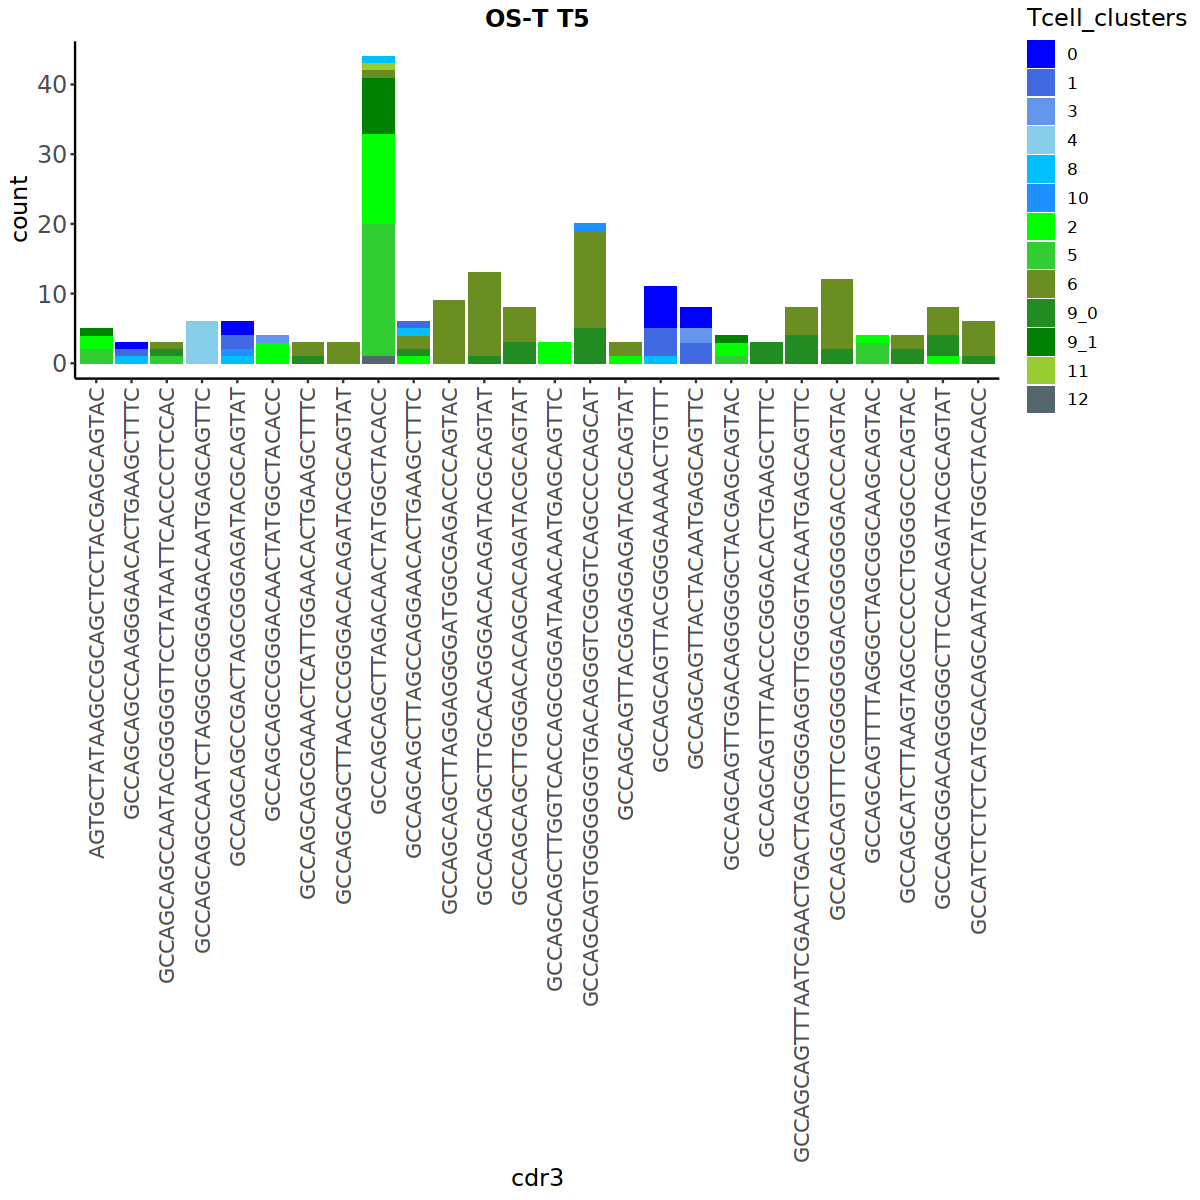

In [121]:
options(repr.plot.width = 10, repr.plot.height = 10, warn=-1,verbose = FALSE)
df_plot <- purple_pheno %>% group_by(cdr3, !!as.name(lvl)) %>%
        summarise(
        count = n()
  ) %>% arrange(desc(count))

barplt <- pheno_bar(df_plot, lvl,tp,tumor_pal)
barplt

In [122]:
list_plots <- c(list_plots,list(barplt+NoLegend()))

In [123]:
proportions <- prop.table(table(purple_pheno$Tcell_clusters))

In [124]:
# fix order
proportions <- prop.table(table(purple_pheno$Tcell_clusters))
keys_to_move <- c("6", "9_0", "11")
elements_to_move <- proportions[keys_to_move]
remaining_elements <- proportions[!(names(proportions) %in% keys_to_move)]
proportions <- c(remaining_elements, elements_to_move)

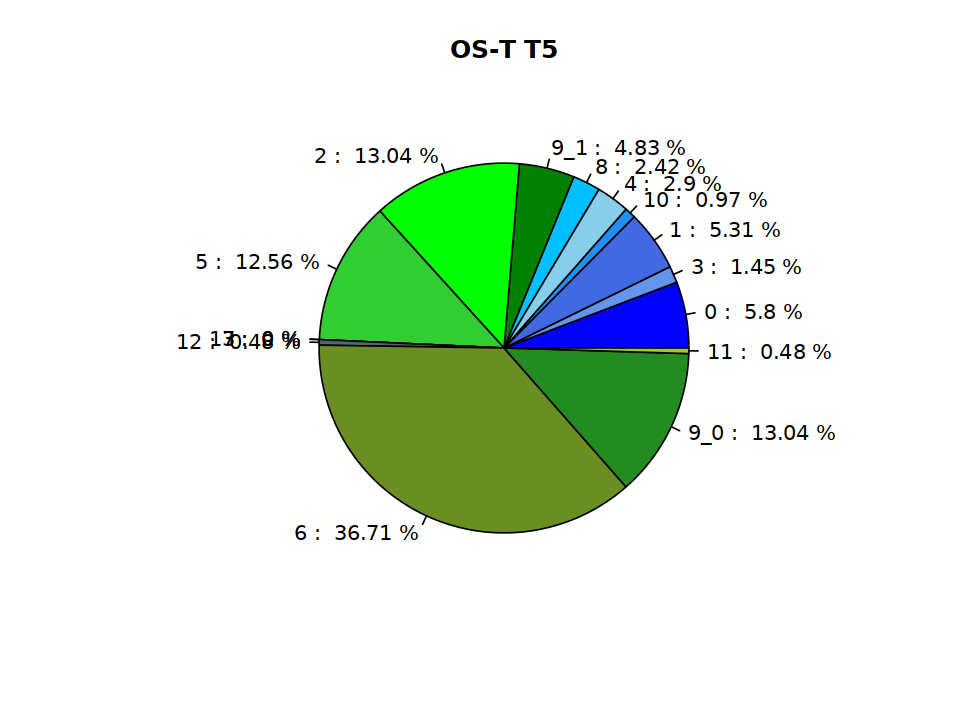

In [125]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)
pie(proportions, 
    labels = paste(names(proportions), ": ", 
                   round(proportions * 100, 2), "%"), 
     main = tp, col = unlist(tumor_pal[names(proportions)]))

In [126]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)

svg(here(glue("{tcr}/{plt_dir}/5.3-Tcells_pie_prop_{tp}.svg")))
pie_plot <- pie(proportions, 
   labels = names(proportions), 
     main =tp, col = unlist(tumor_pal[names(proportions)]), cex=2)
dev.off()

png 
  2

In [127]:
proportions <- prop.table(table(purple_pheno$Tcell_clusters_all))

In [128]:
# keep same order as before
keys_to_move <- names(proportions)[grepl("S", names(proportions))]
elements_to_move <- proportions[keys_to_move]
remaining_elements2 <- proportions[!(names(proportions) %in% keys_to_move)]
remaining_elements2 = remaining_elements2[names(remaining_elements)]
proportions <- c(remaining_elements, elements_to_move)

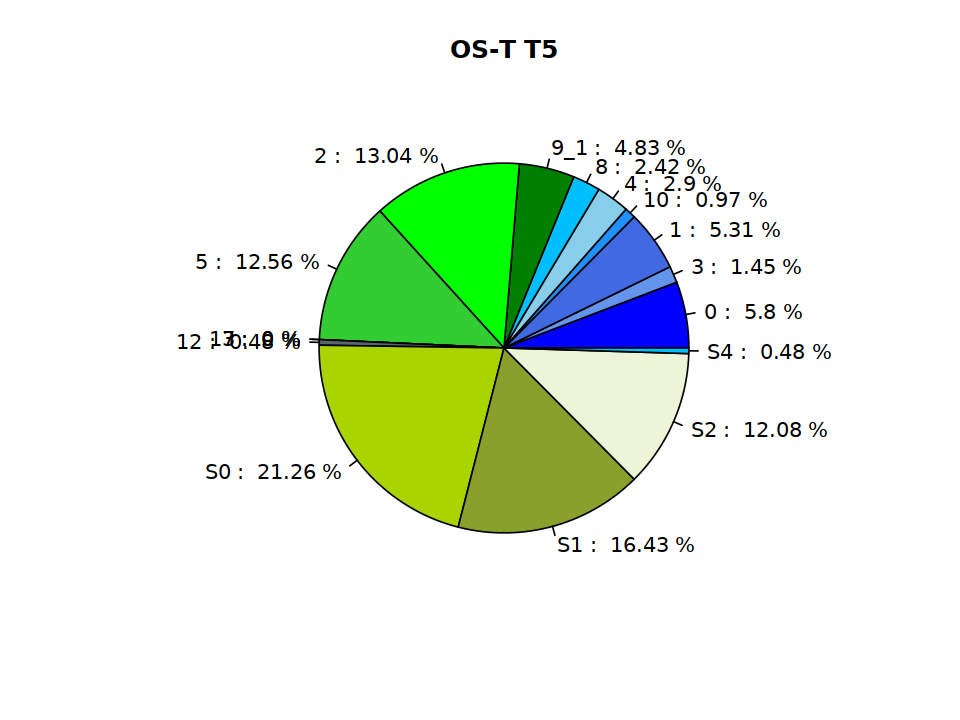

In [129]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)
pie(proportions, 
    labels = paste(names(proportions), ": ", 
                   round(proportions * 100, 2), "%"), 
     main = tp, col = unlist(tumor_pal[names(proportions)]))

In [130]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)

svg(here(glue("{tcr}/{plt_dir}/5.3-Tcells_pie_prop_{tp}_h.svg")))
pie_plot <- pie(proportions, 
   labels = names(proportions), 
     main =tp, col = unlist(tumor_pal[names(proportions)]), cex=2)
dev.off()

png 
  2

Expanded in T6 found more than 1

In [131]:
df_plot <- df_summary %>% 
    dplyr::filter(counts_T6_OS > 1) %>%
    arrange(desc(counts_T6_OS))
df_plot

cdr3                                       Freq_Tumor counts_T1_OS
1  GCCAGCAGCTTAGACAACTATGGCTACACC             44          2          
2  GCCAGCAGCCGGGACAACTATGGCTACACC              4         11          
3  GCCAGCAGCTTGGTCACCAGCGGGATAAACAATGAGCAGTTC  3          3          
4  GCCAGCAGCTTGCACAGGGACACAGATACGCAGTAT       13          1          
5  GCCAGCAGTTACGGGGAAAAACTGTTT                11          0          
6  GCCAGCAGCGAAACTCATTGGAACACTGAAGCTTTC        3          1          
7  GCCAGCAGTTTGGGACAGAACACTGAAGCTTTC           3          1          
8  GCCAGCAGCCAAGACCCAGGGTCTGGAAACACCATATAT     7          4          
9  GCCAGCAGCTTGGGGTACGAGCAGTAC                 6         12          
10 AGTGCTCGAATCAGGGAAAAGAACACTGAAGCTTTC        4          0          
11 GCCAGCATCTTAAGTAGCCCCCCTGGGGCCCAGTAC        4          0          
12 GCCAGCAGTTTAGGGTACGAGCAGTAC                 3          5          
13 GCCAGCAGCTTAGACAGGGCCACCAATCAGCCCCAGCAT    11          3          
14 GCCAGCAGCTTAGGAGGGGATGGCGAGACCCAGTAC        9          0          
15 GCCACCAGTGATTTGAATGAGCAGTTC                 7          1          
16 GCCAGCAGCCAATCTAGGGCGGGAGACAATGAGCAGTTC     6          0          
17 GCCAGCAGCGCGGGACAGGGAGGGATTGAAGCTTTC        3          2          
   counts_T2_3_OS counts_T4_OS counts_T5_OS counts_T6_OS counts_T7_OS
1  5              18           15           20            1          
2  9              10            2           14            0          
3  5              20            5           14            3          
4  0               0           50           10            4          
5  0               3            2           10            0          
6  0              12            9            4           14          
7  2               5            1            4            2          
8  0               0            0            3            1          
9  1               0            1            3            5          
10 0               3            0            3            3          
11 0              70           11            3            5          
12 3               0            0            3            2          
13 0               5            0            2            0          
14 0               7            4            2            3          
15 0               0            0            2            0          
16 0              74           28            2            1          
17 3               0            0            2            1

In [132]:
print(dim(df_plot))
print(length(unique(df_plot$cdr3)))

[1] 17  8
[1] 17


In [133]:
seurat_tcr <- highlightClonotypes(seurat_tcr, 
              cloneCall="cdr3", 
              sequence = unique(df_plot$cdr3))

In [134]:
pink_pheno <- seurat_tcr@meta.data %>%
    dplyr::filter(!is.na(highlight)) %>%
    select(c("cdr3", lvl,"Tcell_clusters_all"))

In [135]:
barcodes <- seurat_tcr@meta.data %>%
    dplyr::filter(!is.na(highlight)) %>%
    rownames_to_column(var = "Barcode") %>%
    pull(Barcode)

In [136]:
head(seurat_tcr@meta.data)

orig.ident    nCount_RNA nFeature_RNA
T0_CD3pos_AAACCTGAGCAGCCTC-1 SCGRES_99_100 1718        912        
T0_CD3pos_AAACCTGAGCAGCGTA-1 SCGRES_99_100 5583       1906        
T0_CD3pos_AAACCTGAGCTAACTC-1 SCGRES_99_100 9529       3297        
T0_CD3pos_AAACCTGAGGGTGTTG-1 SCGRES_99_100 4068       1554        
T0_CD3pos_AAACCTGAGGTGTTAA-1 SCGRES_99_100 5378       2152        
T0_CD3pos_AAACCTGCAAGCGAGT-1 SCGRES_99_100 2656       1117        
                             sample_org     timepoint replicate sample_id
T0_CD3pos_AAACCTGAGCAGCCTC-1 CC2269CD3pos_1 T0        1         T0_CD3pos
T0_CD3pos_AAACCTGAGCAGCGTA-1 CC2269CD3pos_1 T0        1         T0_CD3pos
T0_CD3pos_AAACCTGAGCTAACTC-1 CC2269CD3pos_1 T0        1         T0_CD3pos
T0_CD3pos_AAACCTGAGGGTGTTG-1 CC2269CD3pos_1 T0        1         T0_CD3pos
T0_CD3pos_AAACCTGAGGTGTTAA-1 CC2269CD3pos_1 T0        1         T0_CD3pos
T0_CD3pos_AAACCTGCAAGCGAGT-1 CC2269CD3pos_1 T0        1         T0_CD3pos
                             pct_mt   percent.ribo doublet_score ⋯
T0_CD3pos_AAACCTGAGCAGCCTC-1 4.016298 18.62631     0.03559951    ⋯
T0_CD3pos_AAACCTGAGCAGCGTA-1 1.970267 29.84059     0.14168766    ⋯
T0_CD3pos_AAACCTGAGCTAACTC-1 1.899465 15.11176     0.07415991    ⋯
T0_CD3pos_AAACCTGAGGGTGTTG-1 2.261554 31.98132     0.40553360    ⋯
T0_CD3pos_AAACCTGAGGTGTTAA-1 1.822239 19.41242     0.09983242    ⋯
T0_CD3pos_AAACCTGCAAGCGAGT-1 3.049699 20.36898     0.02405428    ⋯
                             barcode                     
T0_CD3pos_AAACCTGAGCAGCCTC-1 T0_CD3pos_AAACCTGAGCAGCCTC-1
T0_CD3pos_AAACCTGAGCAGCGTA-1 T0_CD3pos_AAACCTGAGCAGCGTA-1
T0_CD3pos_AAACCTGAGCTAACTC-1 NA                          
T0_CD3pos_AAACCTGAGGGTGTTG-1 T0_CD3pos_AAACCTGAGGGTGTTG-1
T0_CD3pos_AAACCTGAGGTGTTAA-1 T0_CD3pos_AAACCTGAGGTGTTAA-1
T0_CD3pos_AAACCTGCAAGCGAGT-1 T0_CD3pos_AAACCTGCAAGCGAGT-1
                             CTgene                   
T0_CD3pos_AAACCTGAGCAGCCTC-1 TRBV5-6.NA.TRBJ1-2.TRBC1 
T0_CD3pos_AAACCTGAGCAGCGTA-1 TRBV5-1.NA.TRBJ1-2.TRBC1 
T0_CD3pos_AAACCTGAGCTAACTC-1 NA                       
T0_CD3pos_AAACCTGAGGGTGTTG-1 TRBV3-1.NA.TRBJ2-1.TRBC2 
T0_CD3pos_AAACCTGAGGTGTTAA-1 TRBV12-3.NA.TRBJ2-1.TRBC2
T0_CD3pos_AAACCTGCAAGCGAGT-1 TRBV6-1.NA.TRBJ1-6.TRBC1 
                             CTnt                                            
T0_CD3pos_AAACCTGAGCAGCCTC-1 TGTGCCAGCAGCTTGTGGGGTAAAAGTCTTGGCTACACCTTC      
T0_CD3pos_AAACCTGAGCAGCGTA-1 TGCGCCAGCAGCTTGGATAACTATGGCTACACCTTC            
T0_CD3pos_AAACCTGAGCTAACTC-1 NA                                              
T0_CD3pos_AAACCTGAGGGTGTTG-1 TGTGCCAGCAGCCTCTATGACAGGGAAAGCGGCAATGAGCAGTTCTTC
T0_CD3pos_AAACCTGAGGTGTTAA-1 TGTGCCAGCAGTGCCGGGACTTCATACAATGAGCAGTTCTTC      
T0_CD3pos_AAACCTGCAAGCGAGT-1 TGTGCCAGCAGTGAAGCTGGGGAAATATGGTATTCACCCCTCCACTTT
                             CTaa            
T0_CD3pos_AAACCTGAGCAGCCTC-1 CASSLWGKSLGYTF  
T0_CD3pos_AAACCTGAGCAGCGTA-1 CASSLDNYGYTF    
T0_CD3pos_AAACCTGAGCTAACTC-1 NA              
T0_CD3pos_AAACCTGAGGGTGTTG-1 CASSLYDRESGNEQFF
T0_CD3pos_AAACCTGAGGTGTTAA-1 CASSAGTSYNEQFF  
T0_CD3pos_AAACCTGCAAGCGAGT-1 CASSEAGEIWYSPLHF
                             CTstrict                                                                                                                                   
T0_CD3pos_AAACCTGAGCAGCCTC-1 TRAV29/DV5.TRAJ40.TRAC_TGTGCAGCAAGCGCGGGAACCTACAAATACATCTTT_TRBV5-6.NA.TRBJ1-2.TRBC1_TGTGCCAGCAGCTTGTGGGGTAAAAGTCTTGGCTACACCTTC            
T0_CD3pos_AAACCTGAGCAGCGTA-1 NA_NA_TRBV5-1.NA.TRBJ1-2.TRBC1_TGCGCCAGCAGCTTGGATAACTATGGCTACACCTTC                                                                        
T0_CD3pos_AAACCTGAGCTAACTC-1 NA                                                                                                                                         
T0_CD3pos_AAACCTGAGGGTGTTG-1 TRAV29/DV5.TRAJ49.TRAC_TGTGCAGCAAGCCTACCGAACACCGGTAACCAGTTCTATTTT_TRBV3-1.NA.TRBJ2-1.TRBC2_TGTGCCAGCAGCCTCTATGACAGGGAAAGCGGCAATGAGCAGTTCTTC
T0_CD3pos_AAACCTGAGGTGTTAA-1 TRAV35.TRAJ48.TRAC_TGTGCTGGGCGCGGATCTAAC

In [137]:
tp = "OS-T T6"

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


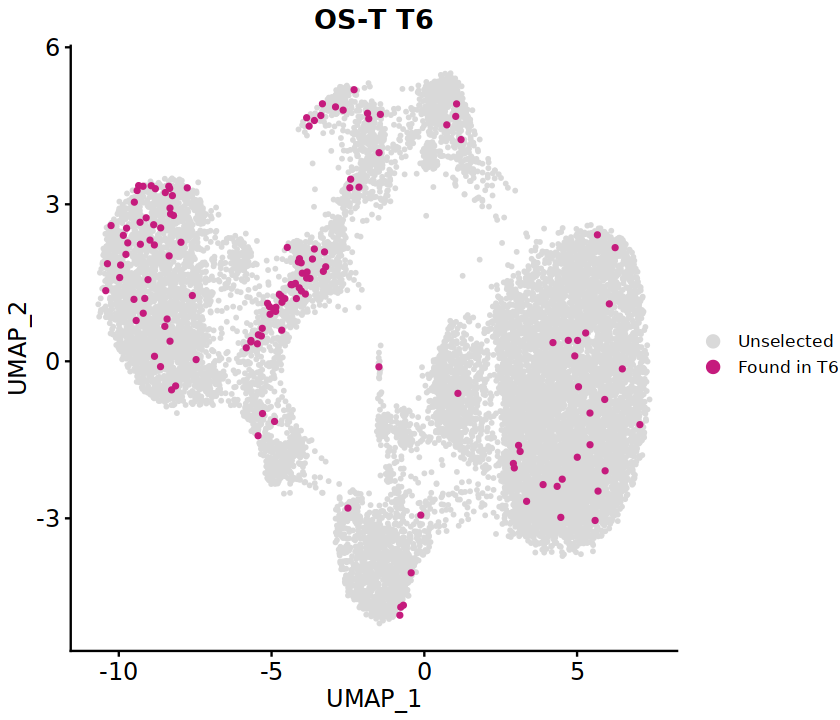

In [138]:
options(repr.plot.width = 7, repr.plot.height = 6, warn=-1,verbose = FALSE)

plt <- DimPlot(seurat_tcr, group.by = "highlight",
               cells.highlight=barcodes, 
                 na.value="#d9d9d9", 
        pt.size = 0.6)  +  
  scale_color_manual(labels = c("Unselected", "Found in T6"), values = c("#d9d9d9", "#c51b7d")) +
  theme(axis.text.x = element_text(size = 14),
              axis.text.y = element_text(size = 14),
              text = element_text(size = 14),
              legend.text = element_text(size = 10),
       plot.margin = unit(c(0, 0, 0, 0), "cm")) + 
       labs(title=tp)

plt

In [139]:
list_plots <- c(list_plots,list(plt+NoLegend()))

`summarise()` has grouped output by 'cdr3'. You can override using the `.groups` argument.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


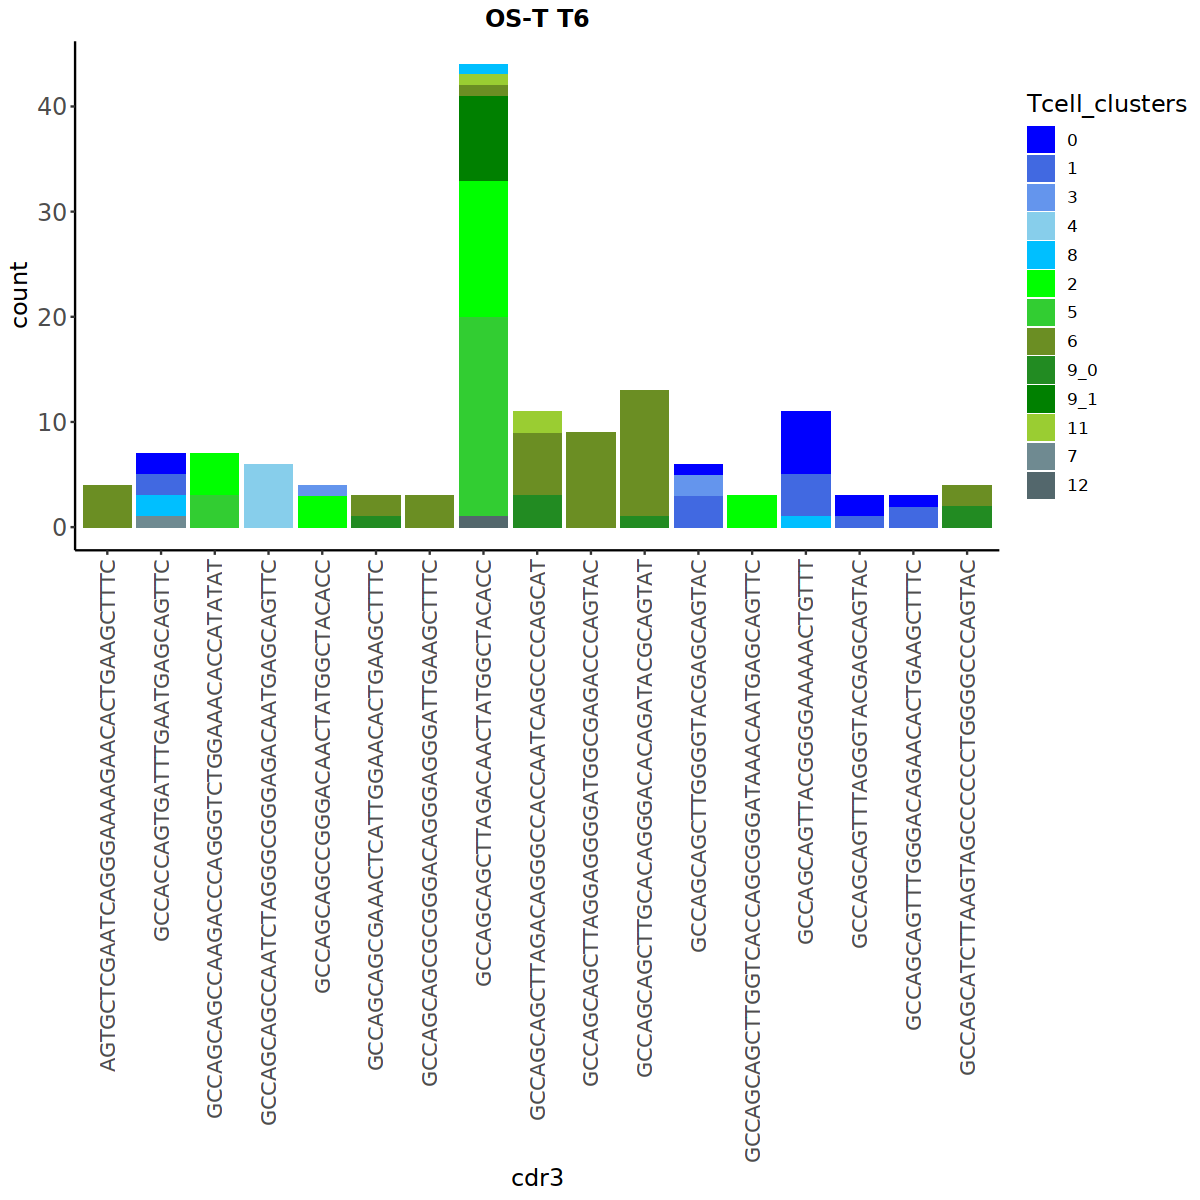

In [140]:
options(repr.plot.width = 10, repr.plot.height = 10, warn=-1,verbose = FALSE)
df_plot <- pink_pheno %>% group_by(cdr3, !!as.name(lvl)) %>%
        summarise(
        count = n()
  ) %>% arrange(desc(count))

barplt <- pheno_bar(df_plot, lvl,tp,tumor_pal)
barplt

In [141]:
list_plots <- c(list_plots,list(barplt+NoLegend()))

In [142]:
proportions <- prop.table(table(pink_pheno$Tcell_clusters))

In [143]:
# fix order
proportions <- prop.table(table(pink_pheno$Tcell_clusters))
keys_to_move <- c("6", "9_0", "11")
elements_to_move <- proportions[keys_to_move]
remaining_elements <- proportions[!(names(proportions) %in% keys_to_move)]
proportions <- c(remaining_elements, elements_to_move)

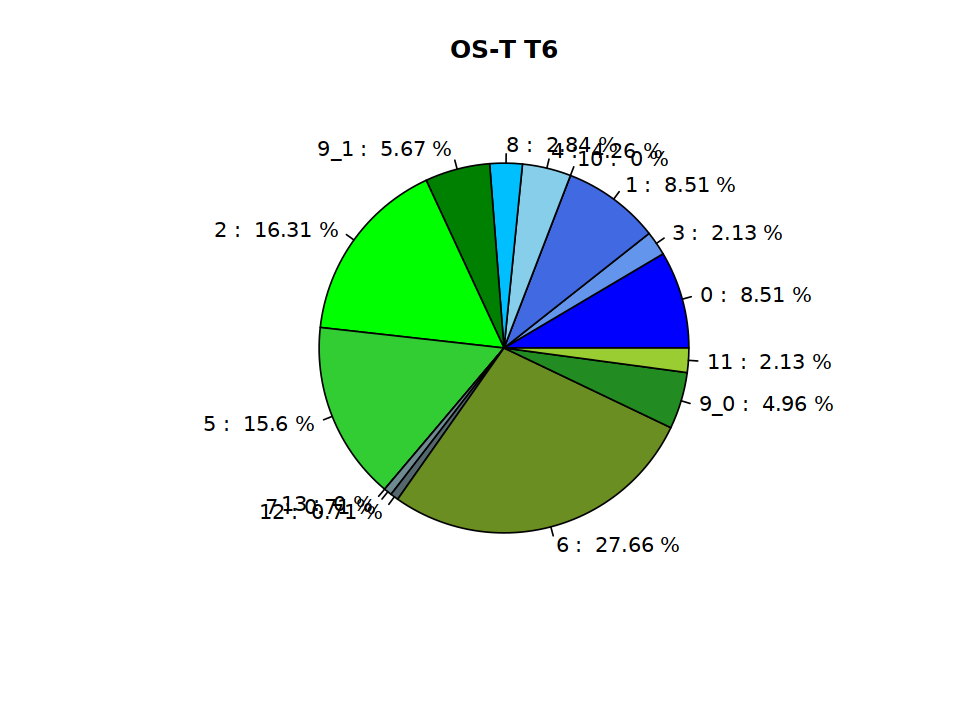

In [144]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)
pie(proportions, 
    labels = paste(names(proportions), ": ", 
                   round(proportions * 100, 2), "%"), 
     main = tp, col = unlist(tumor_pal[names(proportions)]))

In [145]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)

svg(here(glue("{tcr}/{plt_dir}/5.3-Tcells_pie_prop_{tp}.svg")))
pie_plot <- pie(proportions, 
   labels = names(proportions), 
     main =tp, col = unlist(tumor_pal[names(proportions)]), cex=2)
dev.off()

png 
  2

In [146]:
proportions <- prop.table(table(pink_pheno$Tcell_clusters_all))

In [147]:
# keep same order as before
keys_to_move <- names(proportions)[grepl("S", names(proportions))]
elements_to_move <- proportions[keys_to_move]
remaining_elements2 <- proportions[!(names(proportions) %in% keys_to_move)]
remaining_elements2 = remaining_elements2[names(remaining_elements)]
proportions <- c(remaining_elements, elements_to_move)

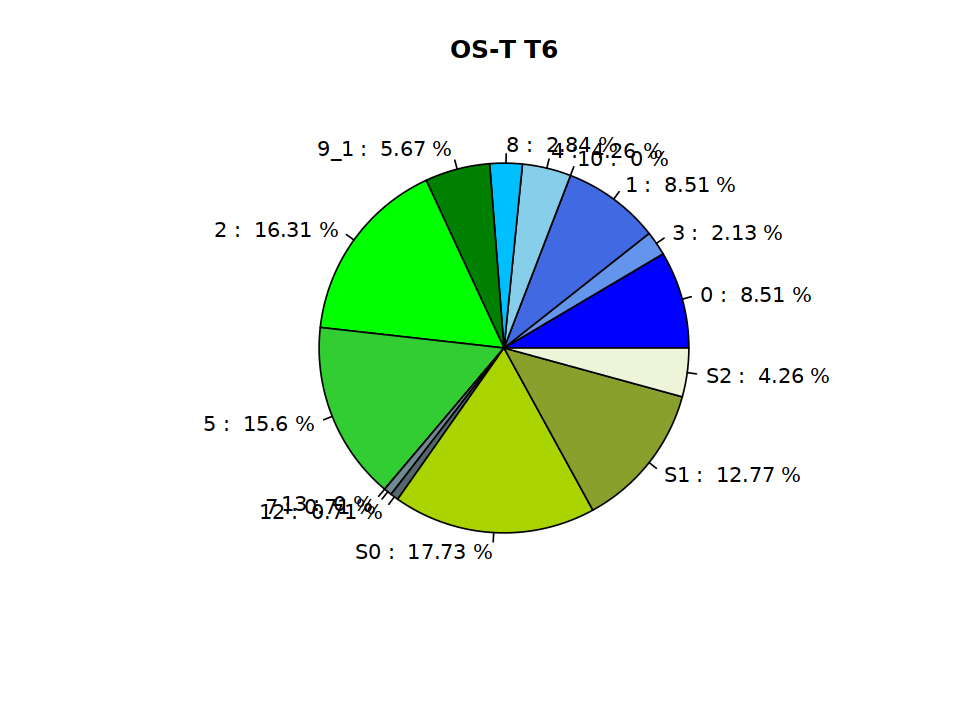

In [148]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)
pie(proportions, 
    labels = paste(names(proportions), ": ", 
                   round(proportions * 100, 2), "%"), 
     main = tp, col = unlist(tumor_pal[names(proportions)]))

In [149]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)

svg(here(glue("{tcr}/{plt_dir}/5.3-Tcells_pie_prop_{tp}_h.svg")))
pie_plot <- pie(proportions, 
   labels = names(proportions), 
     main =tp, col = unlist(tumor_pal[names(proportions)]), cex=2)
dev.off()

png 
  2

Expanded in T7 found more than 1

In [150]:
df_plot <- df_summary %>% 
    dplyr::filter(counts_T7_OS > 1) %>%
    arrange(desc(counts_T7_OS))
df_plot

cdr3                                                   Freq_Tumor
1  GCCATCAGTGAGTCTCGTCTGTTCACTGAAGCTTTC                    3        
2  GCCAGCAGCGAAACTCATTGGAACACTGAAGCTTTC                    3        
3  GCCAGCAGCCTCCAAGAGACCCAGTAC                             3        
4  GCCAGCAGCTTAGCCAGAGGCACAGATACGCAGTAT                   13        
5  GCCAGCAGTTTAACCCGGGACACTGAAGCTTTC                       3        
6  GCCAGCGGACAGGGGGCTTCCACAGATACGCAGTAT                    8        
7  GCCAGCAGTTTCGGGGGGGACGGGGGGACCCAGTAC                   12        
8  GCCAGCAGTTTTAGCAATCAGCCCCAGCAT                         12        
9  GCCAGCAGTTACTACAATGAGCAGTTC                             8        
10 GCCAGCAGTTTAATCGAACTGACTAGCGGGAGGTTGGGGTACAATGAGCAGTTC  8        
11 GCCAGCAGCTTGGGGTACGAGCAGTAC                             6        
12 GCCAGCATCTTAAGTAGCCCCCCTGGGGCCCAGTAC                    4        
13 GCCAGCAGCTTGCACAGGGACACAGATACGCAGTAT                   13        
14 GCCAGCAGCTTGGGACACAGCACAGATACGCAGTAT                    8        
15 GCCAGCAGCTACACC                                         3        
16 GCCAGCAGCCCTCTTACAGGGGGCTATGGCTACACC                   11        
17 GCCAGCAGCTTAGGAGGGGATGGCGAGACCCAGTAC                    9        
18 AGTGCTCGAATCAGGGAAAAGAACACTGAAGCTTTC                    4        
19 GCCAGCAGCCAAGGGAACACTGAAGCTTTC                          3        
20 GCCAGCAGCTGGGACACCTACGAGCAGTAC                          3        
21 GCCAGCAGCTTGGTCACCAGCGGGATAAACAATGAGCAGTTC              3        
22 GCCAGCAGTTTAGGTTACGAGCAGTAC                            20        
23 GCCAGCAGTTTACAGGGCACAGATACGCAGTAT                       9        
24 GCCAGCAGCCAAGGGAATGAGCAGTTC                             6        
25 GCCAGCAGCCCGGACAACTATGGCTACACC                          4        
26 GCCAGCAGCTTCATGAACACTGAAGCTTTC                          4        
27 AGTGCTAGAGCAGGGGGCACTGAAGCTTTC                          3        
28 GCCAGCAGCTTAGGGGAAAATGAGCAGTTC                          3        
29 GCCAGCAGCTTGGGAACTCCATCGGGTGAAAAACTGTTT                 3        
30 GCCAGCAGTTTAGGGTACGAGCAGTAC                             3        
31 GCCAGCAGTTTGGGACAGAACACTGAAGCTTTC                       3        
   counts_T1_OS counts_T2_3_OS counts_T4_OS counts_T5_OS counts_T6_OS
1   0           18              1            1            1          
2   1            0             12            9            4          
3   2            0              0            0            0          
4   0            0              7            1            0          
5   0            0              9            2            0          
6   1            0              8            2            1          
7   0            0              0            2            1          
8   0            0              0            1            0          
9   7            6              3            2            0          
10  0            0              7            3            1          
11 12            1              0            1            3          
12  0            0             70           11            3          
13  1            0              0           50           10          
14  0            0              1            4            0          
15  0            0              0            0            0          
16  3            0              4            0            0          
17  0            0              7            4            2          
18  0            0              3            0            3          
19  5            0              0            3            0          
20  0            0              0            1            0          
21  3            5             20            5           14          
22  0            0              1            0            1          
23  7            0              1            0            1          
24  0            0              0            0            0          
25  0            0              0            

In [151]:
print(dim(df_plot))
print(length(unique(df_plot$cdr3)))

[1] 31  8
[1] 31


In [152]:
seurat_tcr <- highlightClonotypes(seurat_tcr, 
              cloneCall="cdr3", 
              sequence = unique(df_plot$cdr3))

In [153]:
brown_pheno <- seurat_tcr@meta.data %>%
    dplyr::filter(!is.na(highlight)) %>%
    select(c("cdr3", lvl,"Tcell_clusters_all"))

In [154]:
barcodes <- seurat_tcr@meta.data %>%
    dplyr::filter(!is.na(highlight)) %>%
    rownames_to_column(var = "Barcode") %>%
    pull(Barcode)

In [155]:
head(seurat_tcr@meta.data)

orig.ident    nCount_RNA nFeature_RNA
T0_CD3pos_AAACCTGAGCAGCCTC-1 SCGRES_99_100 1718        912        
T0_CD3pos_AAACCTGAGCAGCGTA-1 SCGRES_99_100 5583       1906        
T0_CD3pos_AAACCTGAGCTAACTC-1 SCGRES_99_100 9529       3297        
T0_CD3pos_AAACCTGAGGGTGTTG-1 SCGRES_99_100 4068       1554        
T0_CD3pos_AAACCTGAGGTGTTAA-1 SCGRES_99_100 5378       2152        
T0_CD3pos_AAACCTGCAAGCGAGT-1 SCGRES_99_100 2656       1117        
                             sample_org     timepoint replicate sample_id
T0_CD3pos_AAACCTGAGCAGCCTC-1 CC2269CD3pos_1 T0        1         T0_CD3pos
T0_CD3pos_AAACCTGAGCAGCGTA-1 CC2269CD3pos_1 T0        1         T0_CD3pos
T0_CD3pos_AAACCTGAGCTAACTC-1 CC2269CD3pos_1 T0        1         T0_CD3pos
T0_CD3pos_AAACCTGAGGGTGTTG-1 CC2269CD3pos_1 T0        1         T0_CD3pos
T0_CD3pos_AAACCTGAGGTGTTAA-1 CC2269CD3pos_1 T0        1         T0_CD3pos
T0_CD3pos_AAACCTGCAAGCGAGT-1 CC2269CD3pos_1 T0        1         T0_CD3pos
                             pct_mt   percent.ribo doublet_score ⋯
T0_CD3pos_AAACCTGAGCAGCCTC-1 4.016298 18.62631     0.03559951    ⋯
T0_CD3pos_AAACCTGAGCAGCGTA-1 1.970267 29.84059     0.14168766    ⋯
T0_CD3pos_AAACCTGAGCTAACTC-1 1.899465 15.11176     0.07415991    ⋯
T0_CD3pos_AAACCTGAGGGTGTTG-1 2.261554 31.98132     0.40553360    ⋯
T0_CD3pos_AAACCTGAGGTGTTAA-1 1.822239 19.41242     0.09983242    ⋯
T0_CD3pos_AAACCTGCAAGCGAGT-1 3.049699 20.36898     0.02405428    ⋯
                             barcode                     
T0_CD3pos_AAACCTGAGCAGCCTC-1 T0_CD3pos_AAACCTGAGCAGCCTC-1
T0_CD3pos_AAACCTGAGCAGCGTA-1 T0_CD3pos_AAACCTGAGCAGCGTA-1
T0_CD3pos_AAACCTGAGCTAACTC-1 NA                          
T0_CD3pos_AAACCTGAGGGTGTTG-1 T0_CD3pos_AAACCTGAGGGTGTTG-1
T0_CD3pos_AAACCTGAGGTGTTAA-1 T0_CD3pos_AAACCTGAGGTGTTAA-1
T0_CD3pos_AAACCTGCAAGCGAGT-1 T0_CD3pos_AAACCTGCAAGCGAGT-1
                             CTgene                   
T0_CD3pos_AAACCTGAGCAGCCTC-1 TRBV5-6.NA.TRBJ1-2.TRBC1 
T0_CD3pos_AAACCTGAGCAGCGTA-1 TRBV5-1.NA.TRBJ1-2.TRBC1 
T0_CD3pos_AAACCTGAGCTAACTC-1 NA                       
T0_CD3pos_AAACCTGAGGGTGTTG-1 TRBV3-1.NA.TRBJ2-1.TRBC2 
T0_CD3pos_AAACCTGAGGTGTTAA-1 TRBV12-3.NA.TRBJ2-1.TRBC2
T0_CD3pos_AAACCTGCAAGCGAGT-1 TRBV6-1.NA.TRBJ1-6.TRBC1 
                             CTnt                                            
T0_CD3pos_AAACCTGAGCAGCCTC-1 TGTGCCAGCAGCTTGTGGGGTAAAAGTCTTGGCTACACCTTC      
T0_CD3pos_AAACCTGAGCAGCGTA-1 TGCGCCAGCAGCTTGGATAACTATGGCTACACCTTC            
T0_CD3pos_AAACCTGAGCTAACTC-1 NA                                              
T0_CD3pos_AAACCTGAGGGTGTTG-1 TGTGCCAGCAGCCTCTATGACAGGGAAAGCGGCAATGAGCAGTTCTTC
T0_CD3pos_AAACCTGAGGTGTTAA-1 TGTGCCAGCAGTGCCGGGACTTCATACAATGAGCAGTTCTTC      
T0_CD3pos_AAACCTGCAAGCGAGT-1 TGTGCCAGCAGTGAAGCTGGGGAAATATGGTATTCACCCCTCCACTTT
                             CTaa            
T0_CD3pos_AAACCTGAGCAGCCTC-1 CASSLWGKSLGYTF  
T0_CD3pos_AAACCTGAGCAGCGTA-1 CASSLDNYGYTF    
T0_CD3pos_AAACCTGAGCTAACTC-1 NA              
T0_CD3pos_AAACCTGAGGGTGTTG-1 CASSLYDRESGNEQFF
T0_CD3pos_AAACCTGAGGTGTTAA-1 CASSAGTSYNEQFF  
T0_CD3pos_AAACCTGCAAGCGAGT-1 CASSEAGEIWYSPLHF
                             CTstrict                                                                                                                                   
T0_CD3pos_AAACCTGAGCAGCCTC-1 TRAV29/DV5.TRAJ40.TRAC_TGTGCAGCAAGCGCGGGAACCTACAAATACATCTTT_TRBV5-6.NA.TRBJ1-2.TRBC1_TGTGCCAGCAGCTTGTGGGGTAAAAGTCTTGGCTACACCTTC            
T0_CD3pos_AAACCTGAGCAGCGTA-1 NA_NA_TRBV5-1.NA.TRBJ1-2.TRBC1_TGCGCCAGCAGCTTGGATAACTATGGCTACACCTTC                                                                        
T0_CD3pos_AAACCTGAGCTAACTC-1 NA                                                                                                                                         
T0_CD3pos_AAACCTGAGGGTGTTG-1 TRAV29/DV5.TRAJ49.TRAC_TGTGCAGCAAGCCTACCGAACACCGGTAACCAGTTCTATTTT_TRBV3-1.NA.TRBJ2-1.TRBC2_TGTGCCAGCAGCCTCTATGACAGGGAAAGCGGCAATGAGCAGTTCTTC
T0_CD3pos_AAACCTGAGGTGTTAA-1 TRAV35.TRAJ48.TRAC_TGTGCTGGGCGCGGATCTAAC

In [156]:
tp = "OS-T T7"

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


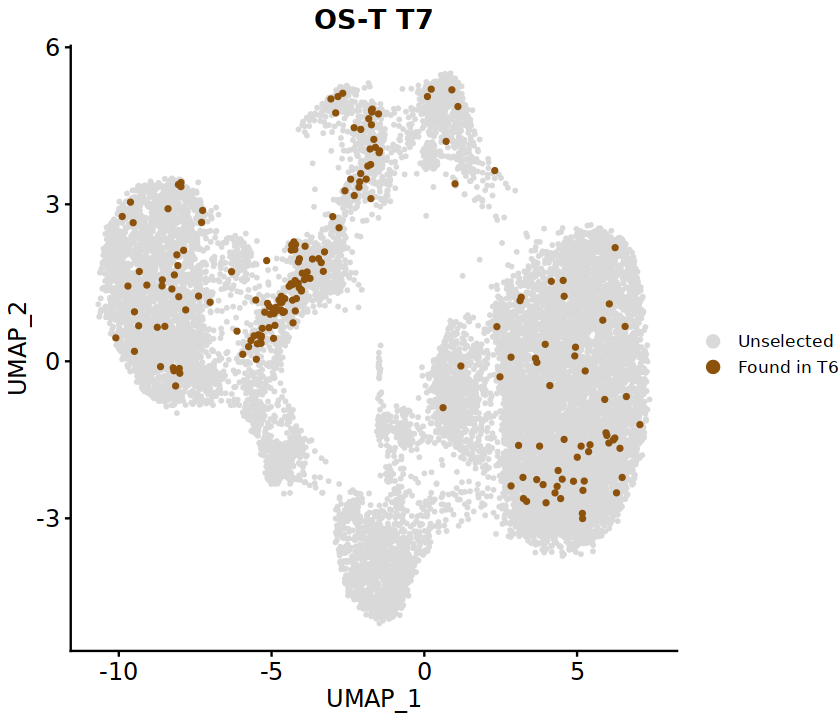

In [157]:
options(repr.plot.width = 7, repr.plot.height = 6, warn=-1,verbose = FALSE)

plt <- DimPlot(seurat_tcr, group.by = "highlight",
               cells.highlight=barcodes, 
                 na.value="#d9d9d9", 
        pt.size = 0.6)  +  
  scale_color_manual(labels = c("Unselected", "Found in T6"), values = c("#d9d9d9", "#8c510a")) +
  theme(axis.text.x = element_text(size = 14),
              axis.text.y = element_text(size = 14),
              text = element_text(size = 14),
              legend.text = element_text(size = 10),
       plot.margin = unit(c(0, 0, 0, 0), "cm")) + 
       labs(title=tp)

plt

In [158]:
list_plots <- c(list_plots,list(plt+NoLegend()))

`summarise()` has grouped output by 'cdr3'. You can override using the `.groups` argument.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


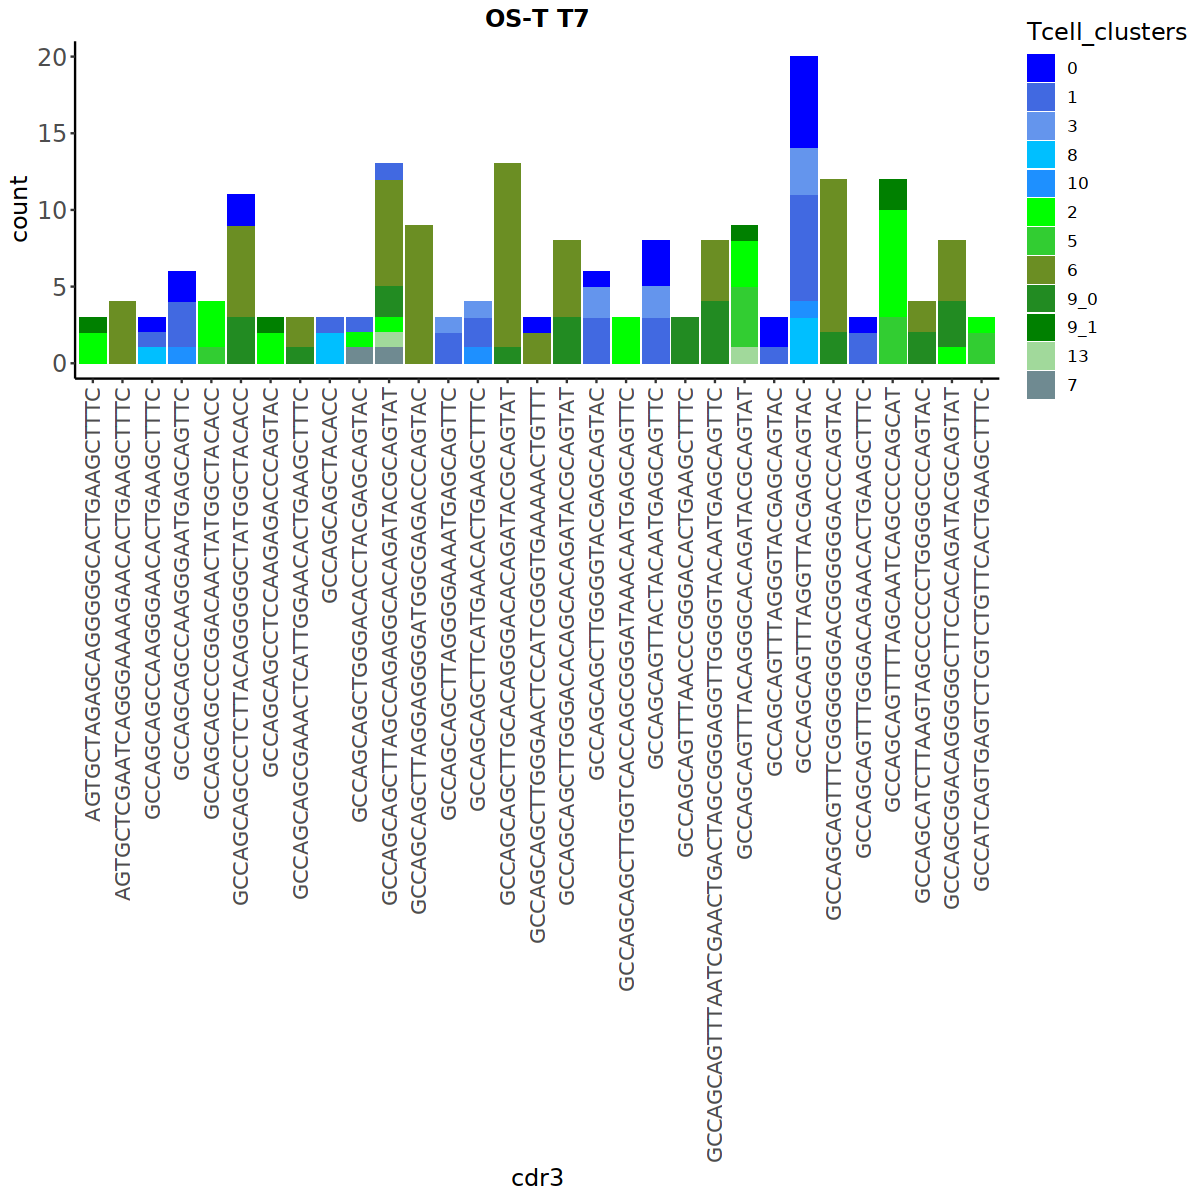

In [159]:
options(repr.plot.width = 10, repr.plot.height = 10, warn=-1,verbose = FALSE)
df_plot <- brown_pheno %>% group_by(cdr3, !!as.name(lvl)) %>%
        summarise(
        count = n()
  ) %>% arrange(desc(count))

barplt <- pheno_bar(df_plot, lvl,tp,tumor_pal)
barplt

In [160]:
list_plots <- c(list_plots,list(barplt+NoLegend()))

In [161]:
proportions <- prop.table(table(brown_pheno$Tcell_clusters))

In [162]:
# fix order
proportions <- prop.table(table(brown_pheno$Tcell_clusters))
keys_to_move <- c("6", "9_0", "11")
elements_to_move <- proportions[keys_to_move]
remaining_elements <- proportions[!(names(proportions) %in% keys_to_move)]
proportions <- c(remaining_elements, elements_to_move)

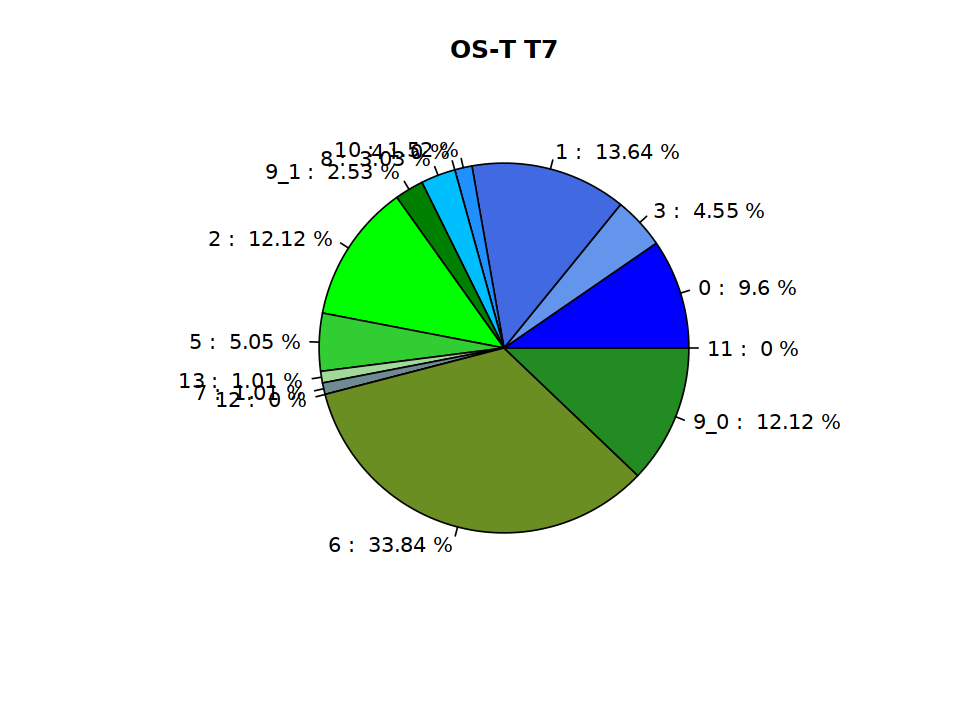

In [163]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)
pie(proportions, 
    labels = paste(names(proportions), ": ", 
                   round(proportions * 100, 2), "%"), 
     main = tp, col = unlist(tumor_pal[names(proportions)]))

In [164]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)

svg(here(glue("{tcr}/{plt_dir}/5.3-Tcells_pie_prop_{tp}.svg")))
pie_plot <- pie(proportions, 
   labels = names(proportions), 
     main =tp, col = unlist(tumor_pal[names(proportions)]), cex=2)
dev.off()

png 
  2

In [165]:
proportions <- prop.table(table(brown_pheno$Tcell_clusters_all))

In [166]:
# keep same order as before
keys_to_move <- names(proportions)[grepl("S", names(proportions))]
elements_to_move <- proportions[keys_to_move]
remaining_elements2 <- proportions[!(names(proportions) %in% keys_to_move)]
remaining_elements2 = remaining_elements2[names(remaining_elements)]
proportions <- c(remaining_elements, elements_to_move)

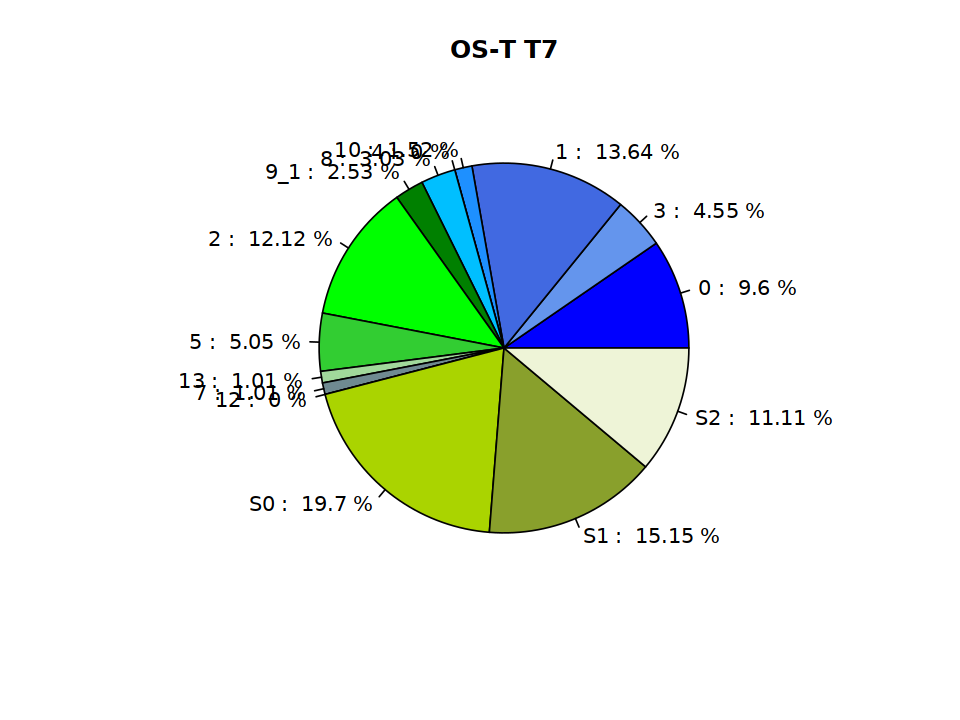

In [167]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)
pie(proportions, 
    labels = paste(names(proportions), ": ", 
                   round(proportions * 100, 2), "%"), 
     main = tp, col = unlist(tumor_pal[names(proportions)]))

In [168]:
options(repr.plot.width =8, repr.plot.height = 6, warn=-1,verbose = FALSE)

svg(here(glue("{tcr}/{plt_dir}/5.3-Tcells_pie_prop_{tp}_h.svg")))
pie_plot <- pie(proportions, 
   labels = names(proportions), 
     main =tp, col = unlist(tumor_pal[names(proportions)]), cex=2)
dev.off()

png 
  2

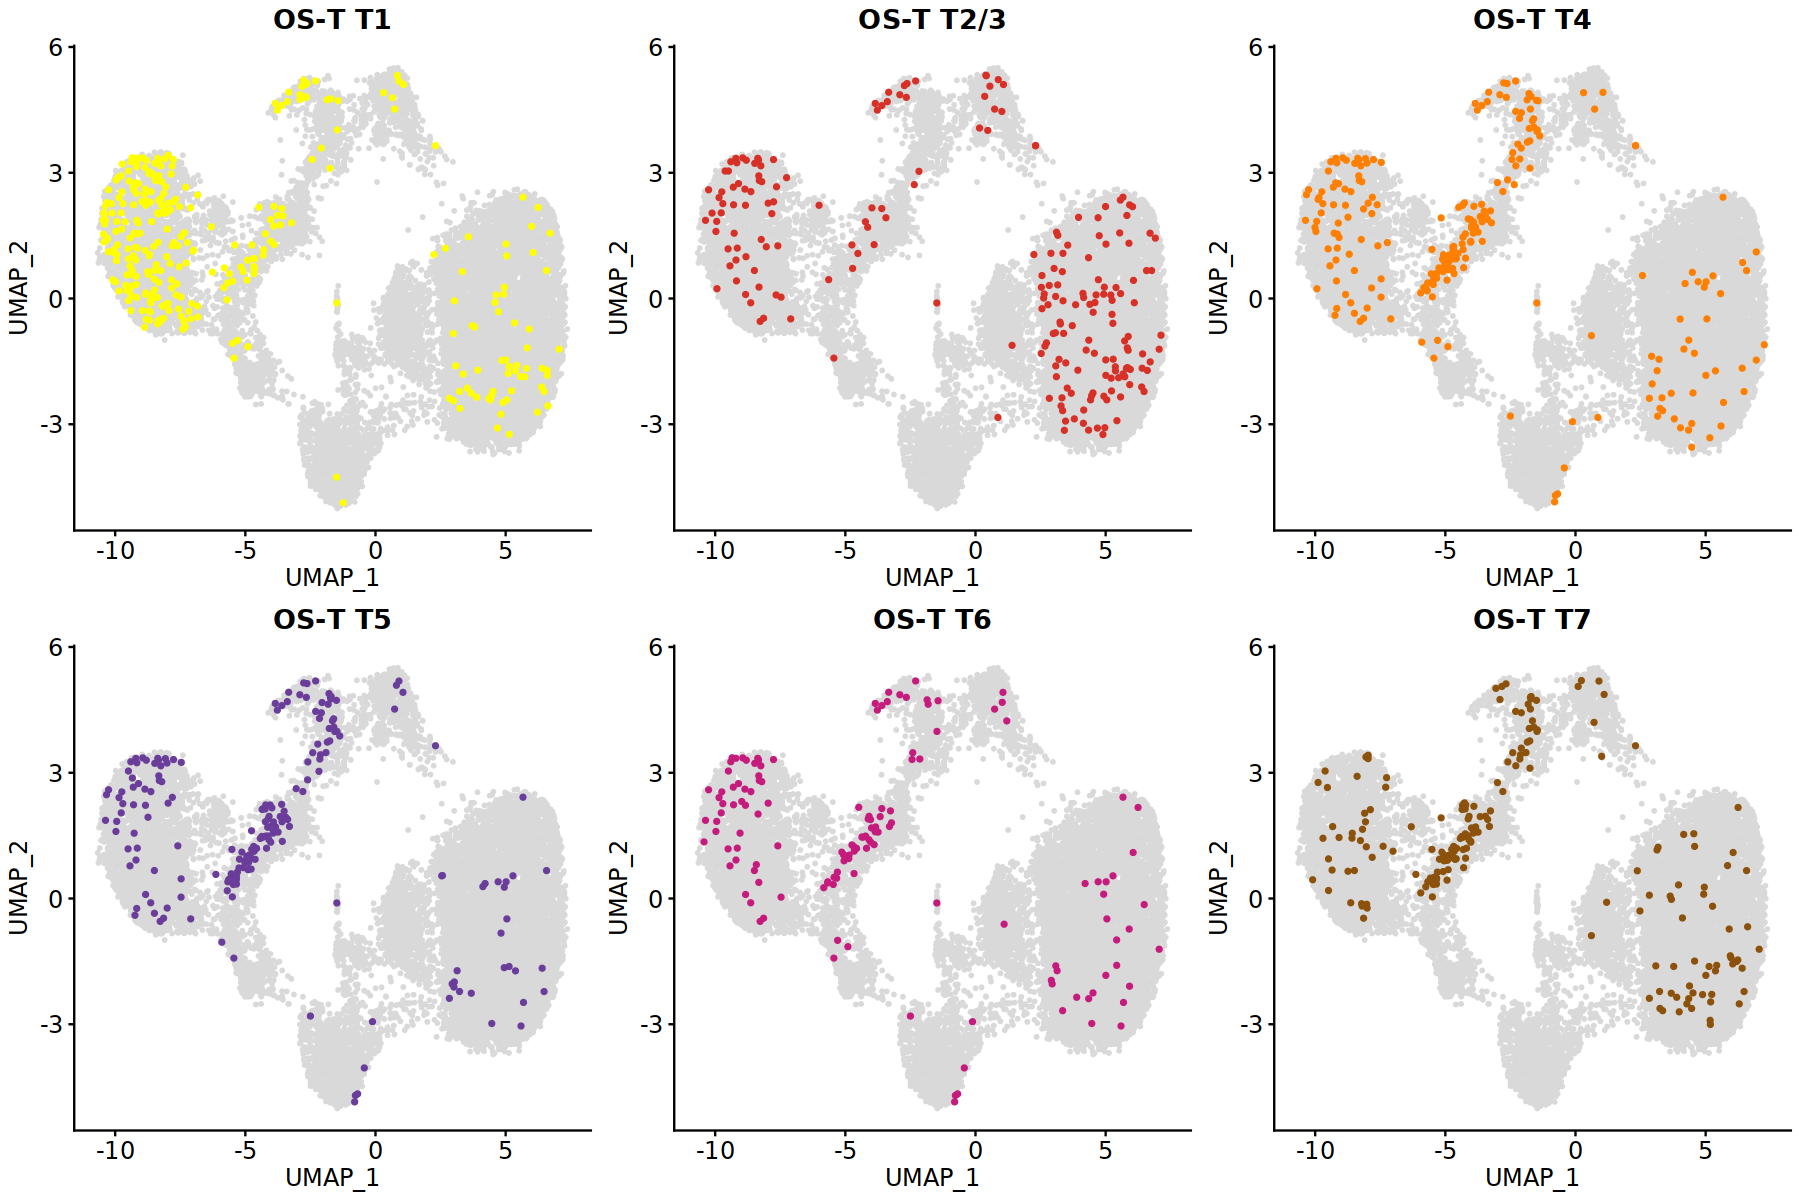

In [169]:
options(repr.plot.width = 15, repr.plot.height = 10, warn=-1,verbose = FALSE)
cp <- plot_grid(plotlist = list_plots[c(1,3,5,7,9,11)],
                   align = "hv",
                   axis = "trbl",
                   ncol = 3,
                   nrow = 2)
cp

In [170]:
save_plot(plot = cp, filename=here(glue("{tcr}/{plt_dir}/5.3-umap_tumor_OST.png")),
          base_width=15, base_height=10)

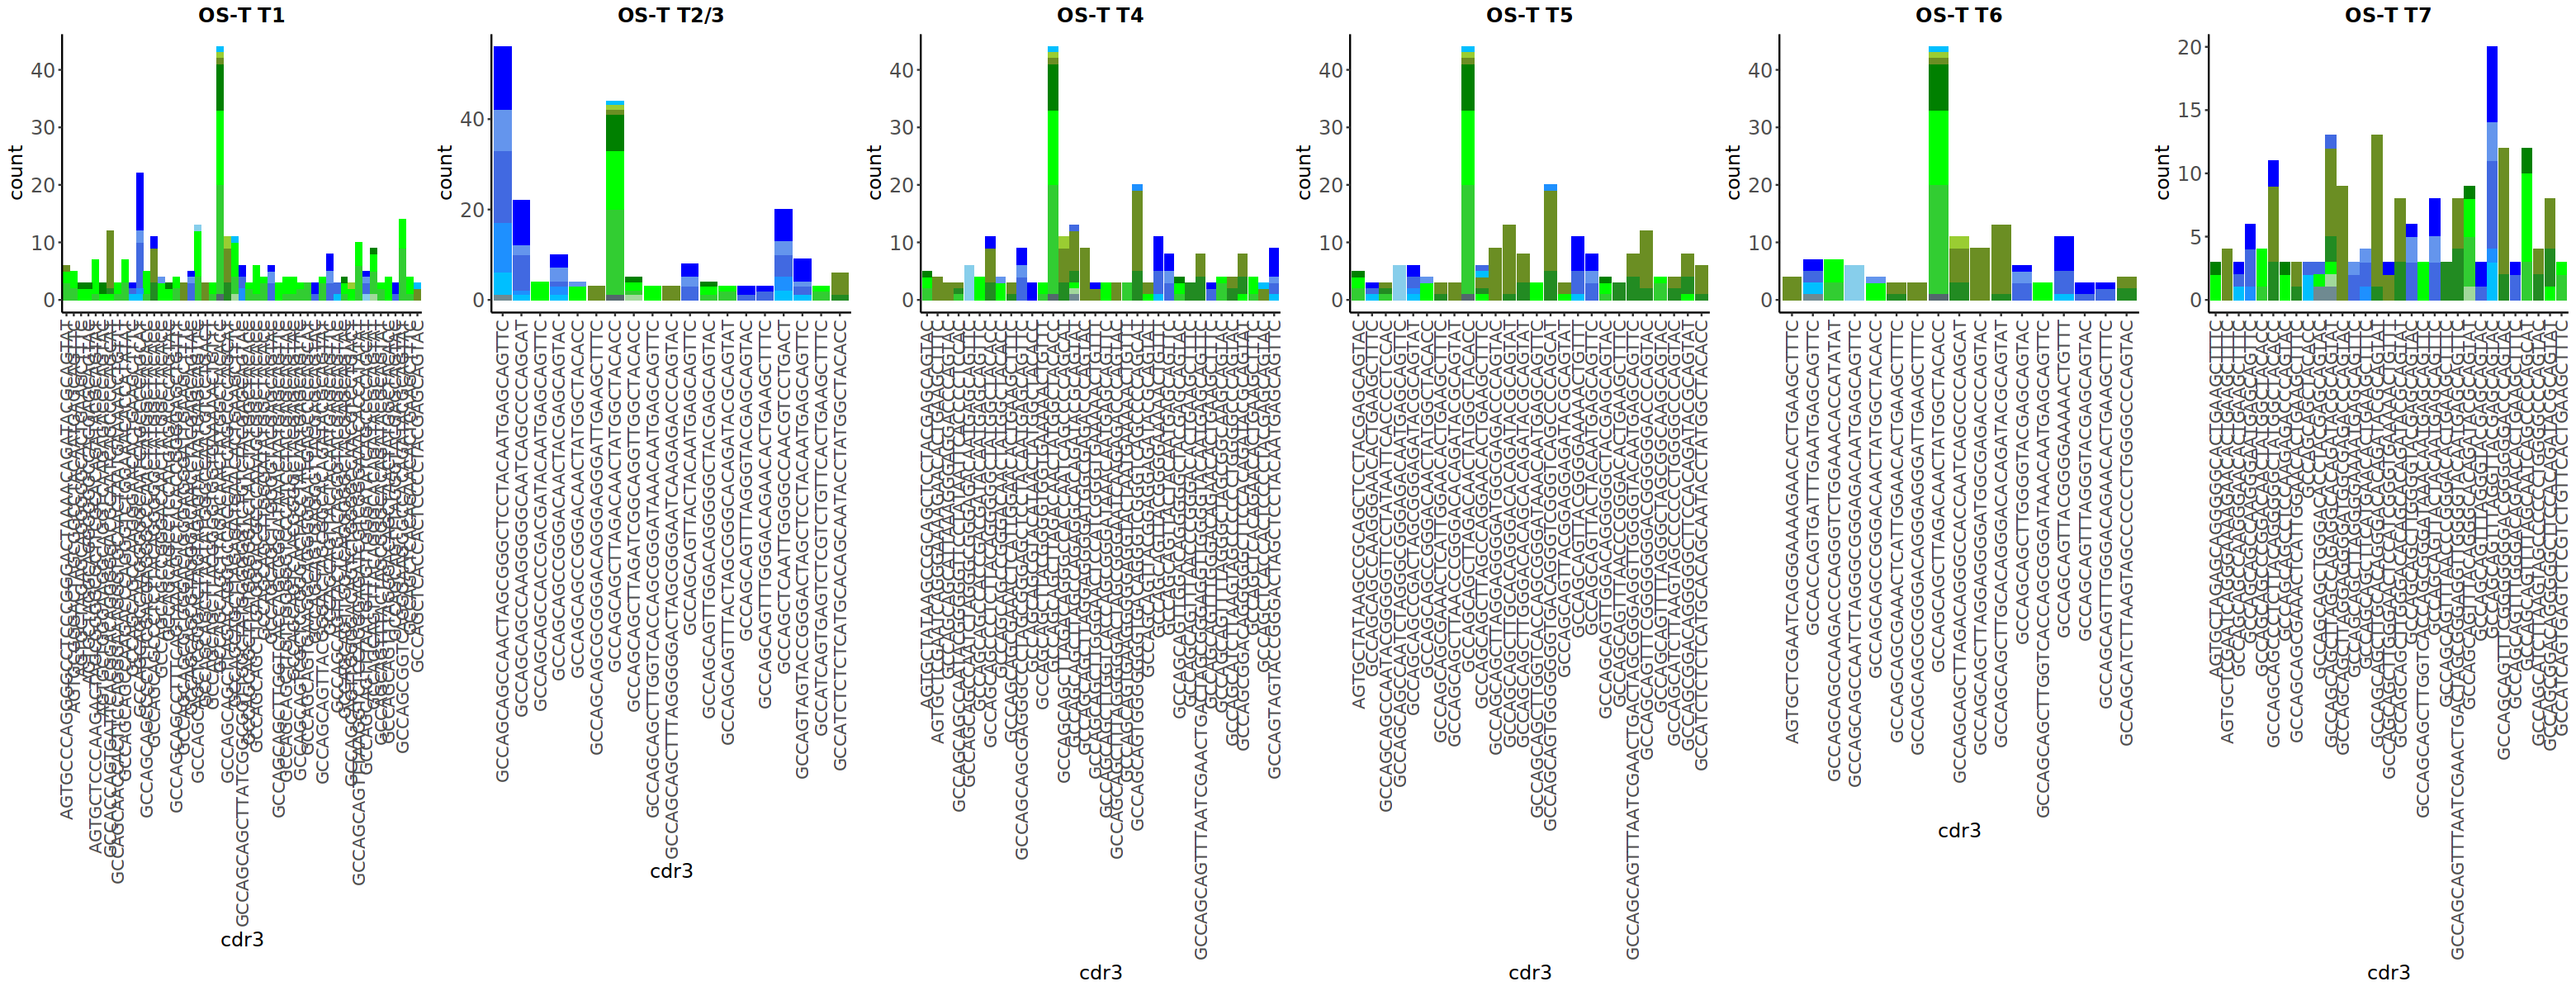

In [171]:
options(repr.plot.width = 26, repr.plot.height = 10, warn=-1,verbose = FALSE)
cp <- plot_grid(plotlist = list_plots[c(2,4,6,8,10,12)],
                   align = "hv",
                   axis = "trbl",
                   ncol = 6,
                   nrow = 1)
cp

## Save

In [172]:
write.csv(yellow_pheno, here(glue("{tcr}/{robj_dir}/5.3-pheno_yellow_T1.csv")), row.names=TRUE)
write.csv(red_pheno, here(glue("{tcr}/{robj_dir}/5.3-pheno_red_T2_3.csv")), row.names=TRUE)
write.csv(orange_pheno, here(glue("{tcr}/{robj_dir}/5.3-pheno_orange_T4.csv")), row.names=TRUE)
write.csv(purple_pheno,here(glue("{tcr}/{robj_dir}/5.3-pheno_purple_T5.csv")), row.names=TRUE) 
write.csv(pink_pheno,here(glue("{tcr}/{robj_dir}/5.3-pheno_pink_T6.csv")), row.names=TRUE) 
write.csv(brown_pheno,here(glue("{tcr}/{robj_dir}/5.3-pheno_brown_T7.csv")), row.names=TRUE) 

## Session Info

In [173]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] cowplot_1.1.1       lubridate_1.9.3     forcats_1.0.0      
 [4] stringr_1.5.0       dplyr_1.1.3         purrr_1.0.2        
 [7] readr_2.1.4         tidyr_1.3.0         tibble_3.2.1       
[10] tidyverse_2.0.0     glue_1.6.2          here_1.0.1         
[13] scRepertoire_1.1